# Policy Gradient method using TF
We will use TF to apply PG method to CartPole environment

In [1]:
# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import display
from tqdm import tnrange, tqdm_notebook
import numpy as np
from collections import deque

%matplotlib inline

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='once'))

Now we create the environment (CartPole V0)

In [2]:
import gym
env = gym.make("CartPole-v0").env

[2017-10-14 15:20:13,009] Making new env: CartPole-v0


Now we will create a basic TF layer of an NN

In [3]:
import tensorflow as tf

class HiddenLayer:
    def __init__(self, M1, M2, f=tf.nn.tanh, use_bias=True):
        self.W = tf.Variable(tf.random_normal(shape=(M1, M2)))
        self.use_bias = use_bias
        if use_bias:
            self.b = tf.Variable(np.zeros(M2).astype(np.float32))
        self.f = f

    def forward(self, X):
        if self.use_bias:
            a = tf.matmul(X, self.W) + self.b
        else:
            a = tf.matmul(X, self.W)
        return self.f(a)

We will then create a class for the policy model (policy given its parameters)

In [4]:
class PolicyModel:
    def __init__(self, D, K, hidden_layer_sizes):
        # create the graph
        # K = number of actions
        self.layers = []
        M1 = D
        for M2 in hidden_layer_sizes:
            layer = HiddenLayer(M1, M2)
            self.layers.append(layer)
            M1 = M2

        # final layer
        # layer = HiddenLayer(M1, K, lambda x: x, use_bias=False)
        layer = HiddenLayer(M1, K, tf.nn.softmax, use_bias=False)
        self.layers.append(layer)

        # inputs and targets
        self.X = tf.placeholder(tf.float32, shape=(None, D), name='X')
        self.actions = tf.placeholder(tf.int32, shape=(None,), name='actions')
        self.advantages = tf.placeholder(tf.float32, shape=(None,), name='advantages')

        # calculate output and cost
        Z = self.X
        for layer in self.layers:
            Z = layer.forward(Z)
        p_a_given_s = Z
        # action_scores = Z
        # p_a_given_s = tf.nn.softmax(action_scores)
        # self.action_scores = action_scores
        self.predict_op = p_a_given_s

        # self.one_hot_actions = tf.one_hot(self.actions, K)

        selected_probs = tf.log(
          tf.reduce_sum(
            p_a_given_s * tf.one_hot(self.actions, K),
            reduction_indices=[1]
          )
        )

        # self.selected_probs = selected_probs
        cost = -tf.reduce_sum(self.advantages * selected_probs)
        # self.cost = cost
        # self.train_op = tf.train.AdamOptimizer(10e-2).minimize(cost)
        self.train_op = tf.train.AdagradOptimizer(10e-2).minimize(cost)
        # self.train_op = tf.train.MomentumOptimizer(10e-5, momentum=0.9).minimize(cost)
        # self.train_op = tf.train.GradientDescentOptimizer(10e-5).minimize(cost)

    def set_session(self, session):
        self.session = session

    def partial_fit(self, X, actions, advantages):
        X = np.atleast_2d(X)
        actions = np.atleast_1d(actions)
        advantages = np.atleast_1d(advantages)
        self.session.run(
            self.train_op,
            feed_dict={
                self.X: X,
                self.actions: actions,
                self.advantages: advantages,
            }
        )

    def predict(self, X):
        X = np.atleast_2d(X)
        return self.session.run(self.predict_op, feed_dict={self.X: X})

    def sample_action(self, X):
        p = self.predict(X)[0]
        return np.random.choice(len(p), p=p)

The next step will be to create the model to approximate value-function V

In [5]:
class ValueModel:
    def __init__(self, D, hidden_layer_sizes):
        # create the graph
        self.layers = []
        M1 = D
        for M2 in hidden_layer_sizes:
            layer = HiddenLayer(M1, M2)
            self.layers.append(layer)
            M1 = M2

        # final layer
        layer = HiddenLayer(M1, 1, lambda x: x)
        self.layers.append(layer)

        # inputs and targets
        self.X = tf.placeholder(tf.float32, shape=(None, D), name='X')
        self.Y = tf.placeholder(tf.float32, shape=(None,), name='Y')

        # calculate output and cost
        Z = self.X
        for layer in self.layers:
            Z = layer.forward(Z)
        Y_hat = tf.reshape(Z, [-1]) # the output
        self.predict_op = Y_hat

        cost = tf.reduce_sum(tf.square(self.Y - Y_hat))
        # self.train_op = tf.train.AdamOptimizer(10e-3).minimize(cost)
        # self.train_op = tf.train.MomentumOptimizer(10e-3, momentum=0.9).minimize(cost)
        self.train_op = tf.train.GradientDescentOptimizer(10e-5).minimize(cost)

    def set_session(self, session):
        self.session = session

    def partial_fit(self, X, Y):
        X = np.atleast_2d(X)
        Y = np.atleast_1d(Y)
        self.session.run(self.train_op, feed_dict={self.X: X, self.Y: Y})

    def predict(self, X):
        X = np.atleast_2d(X)
        return self.session.run(self.predict_op, feed_dict={self.X: X})

Next we will create a function that executes one episode using TD

In [6]:
def play_one_td(env, pmodel, vmodel, gamma, render=False):
    observation = env.reset()
    done = False
    totalreward = 0
    iters = 0
    
    frames=[]
    
    while not done and iters < 500:
        if render:
            frames.append(env.render(mode = 'rgb_array'))
        action = pmodel.sample_action(observation)
        prev_observation = observation
        observation, reward, done, _ = env.step(action)
        if done:
            reward -= 200
        # Update
        V_next = vmodel.predict(observation)
        G = reward + gamma * np.max(V_next)
        advantage = G - vmodel.predict(prev_observation)
        pmodel.partial_fit(prev_observation, action, advantage)
        vmodel.partial_fit(prev_observation, G)
        if reward == 1:
            totalreward += reward
        iters += 1
    return totalreward, frames

The following function, instead, will play one episode and use MC update (at the end of the episode)

In [7]:
def play_one_mc(env, pmodel, vmodel, gamma, render=False):
    observation = env.reset()
    done = False
    totalreward = 0
    iters = 0

    states = []
    actions = []
    rewards = []
    
    frames = []

    while not done and iters < 500:
        if render:
            frames.append(env.render(mode = 'rgb_array'))
        # if we reach 2000, just quit, don't want this going forever
        # the 200 limit seems a bit early
        action = pmodel.sample_action(observation)
        prev_observation = observation
        observation, reward, done, info = env.step(action)
        
        if done:
            reward = -200

        states.append(prev_observation)
        actions.append(action)
        rewards.append(reward)


        if reward == 1: # if we changed the reward to -200
            totalreward += reward
        iters += 1

    returns = []
    advantages = []
    G = 0
    for s, r in zip(reversed(states), reversed(rewards)):
        returns.append(G)
        advantages.append(G - vmodel.predict(s)[0])
        G = r + gamma*G
    returns.reverse()
    advantages.reverse()

    # update the models
    pmodel.partial_fit(states, actions, advantages)
    vmodel.partial_fit(states, returns)
    return totalreward, frames

Now we have everything to run

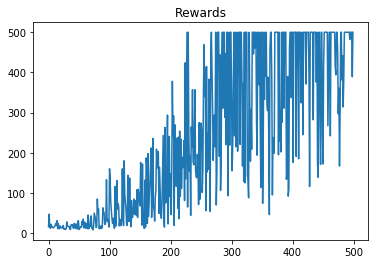

In [8]:
GAMMA = 0.99


D = env.observation_space.shape[0]
K = env.action_space.n
pmodel = PolicyModel(D, K, [])
vmodel = ValueModel(D, [10])

init = tf.global_variables_initializer()
session = tf.InteractiveSession()
session.run(init)
pmodel.set_session(session)
vmodel.set_session(session)

N_EPISODES = 500
totalrewards = np.empty(N_EPISODES)
for episode in tqdm_notebook(range(N_EPISODES), desc='Episodes'):
    totalreward, _ = play_one_mc(env, pmodel, vmodel, GAMMA)
    totalrewards[episode] = totalreward

plt.plot(totalrewards)
plt.title("Rewards")
plt.show()


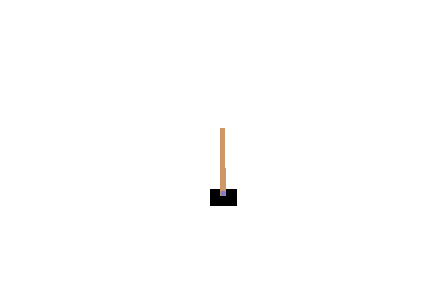
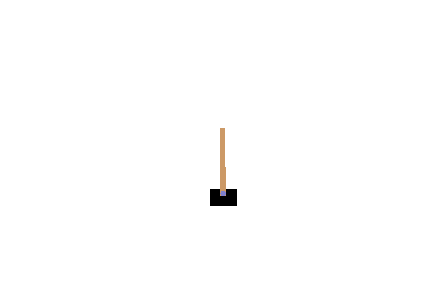
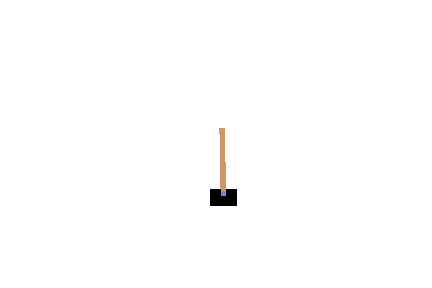
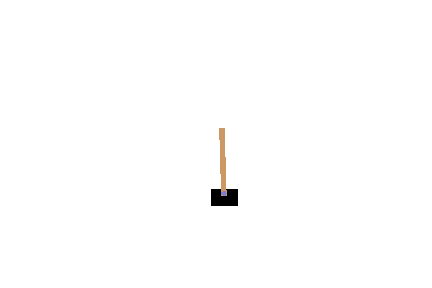
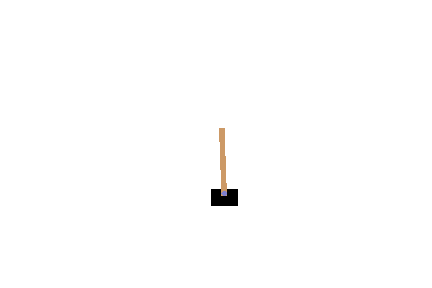
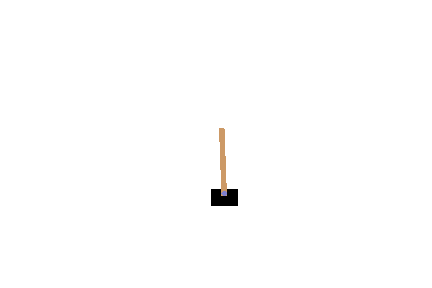
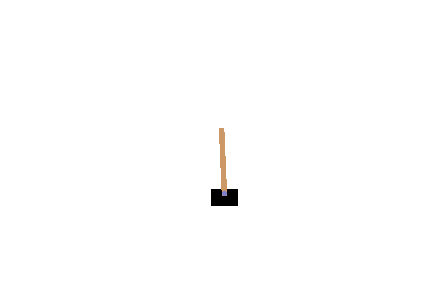
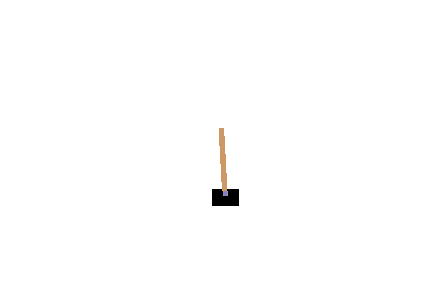
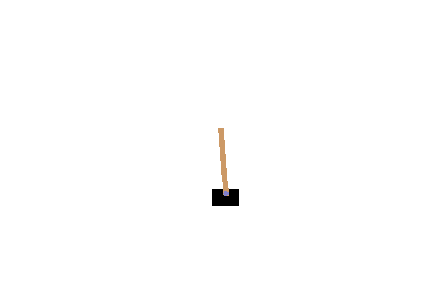
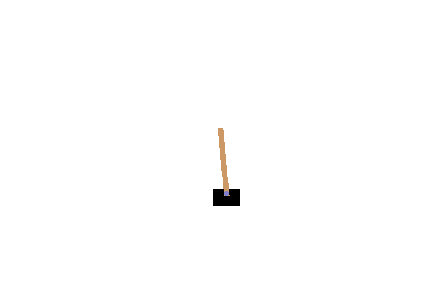
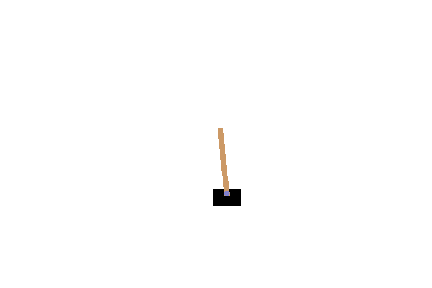
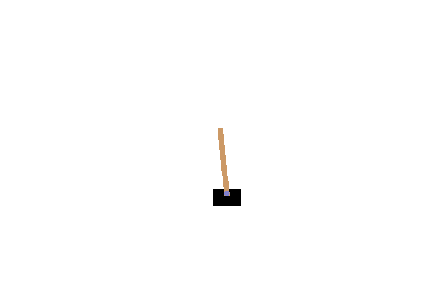
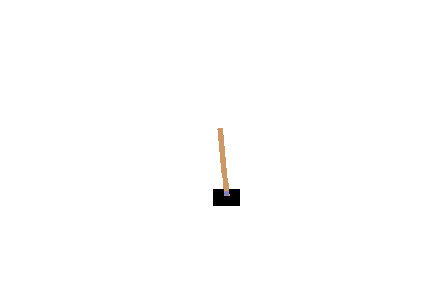
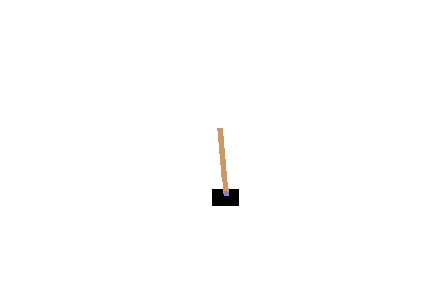
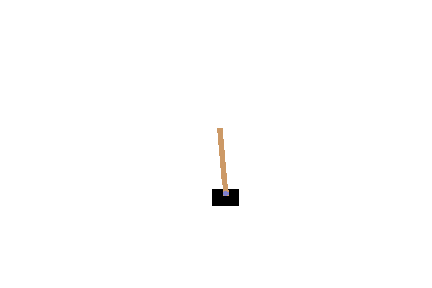
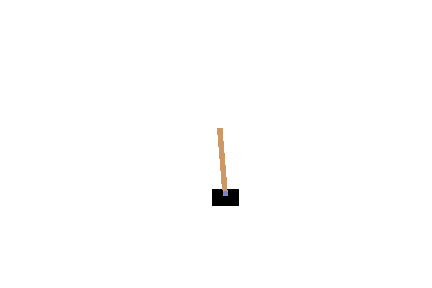
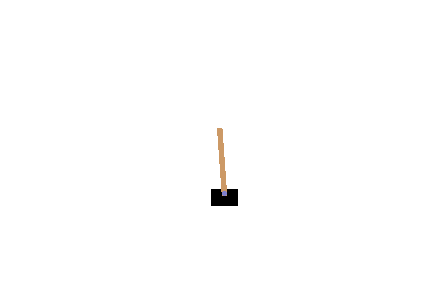
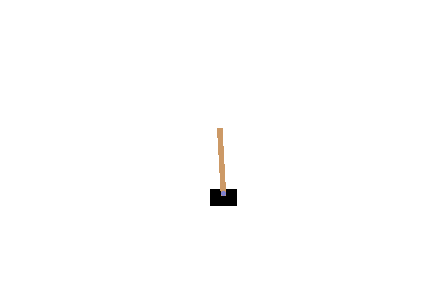
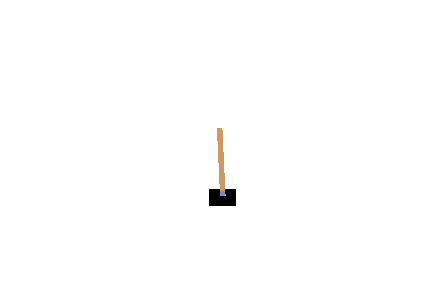
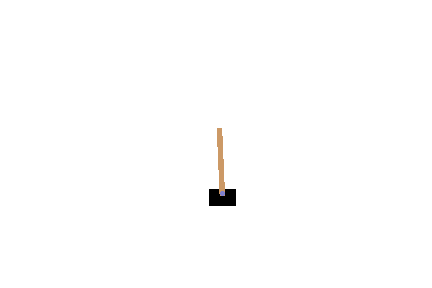
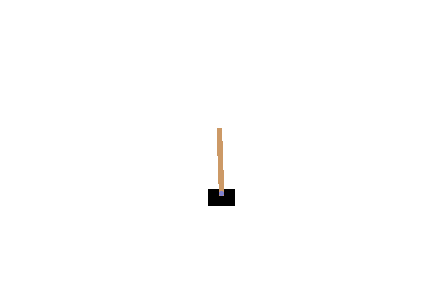
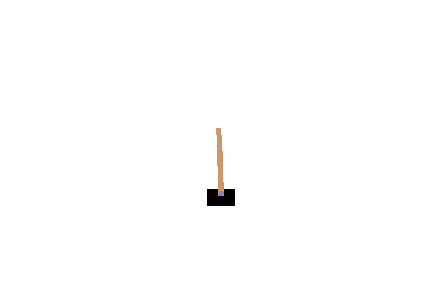
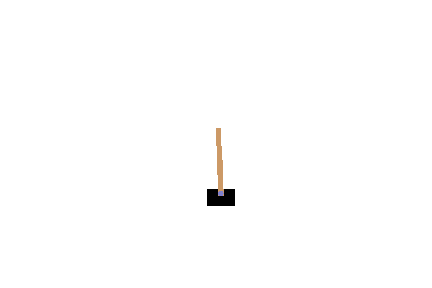
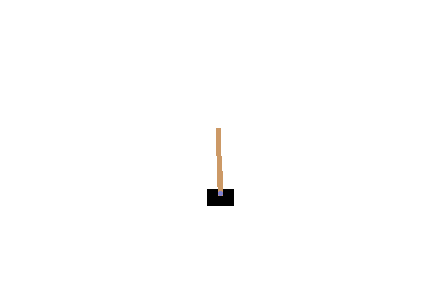
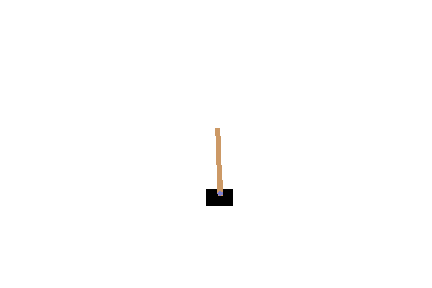
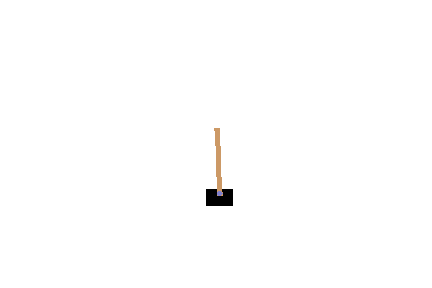
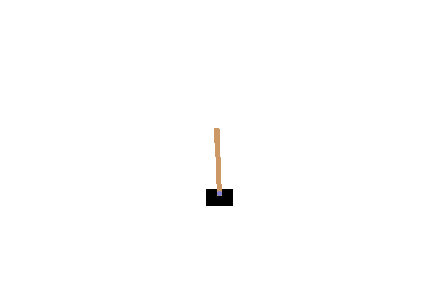
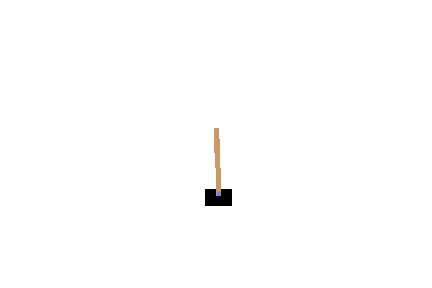
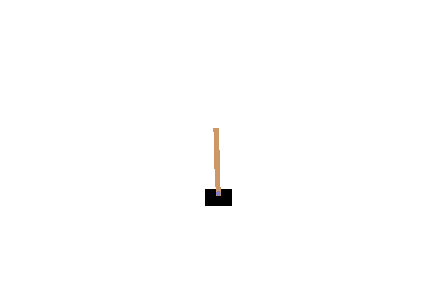
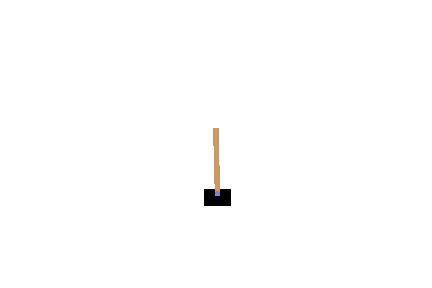
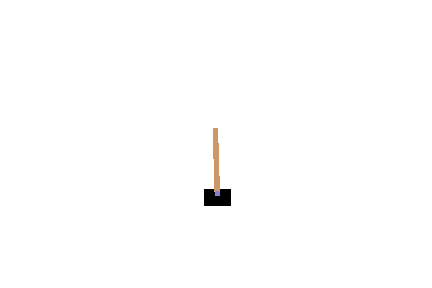
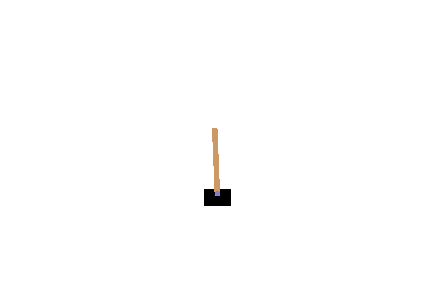
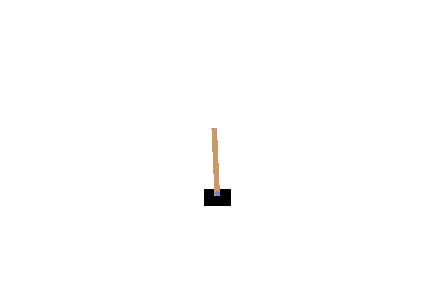
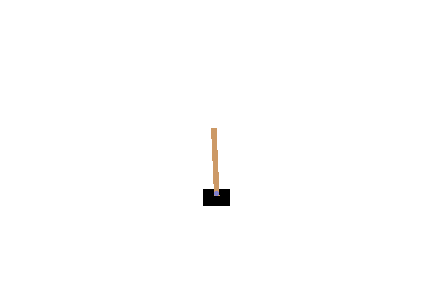
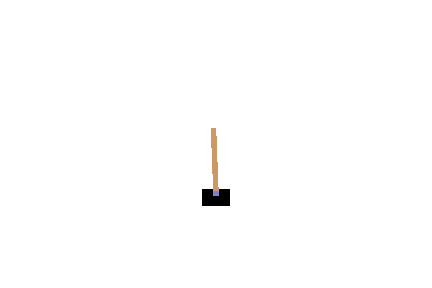
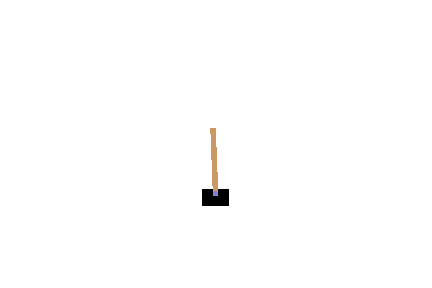
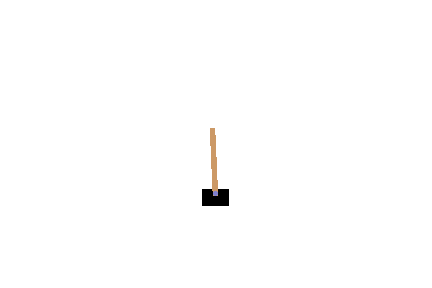
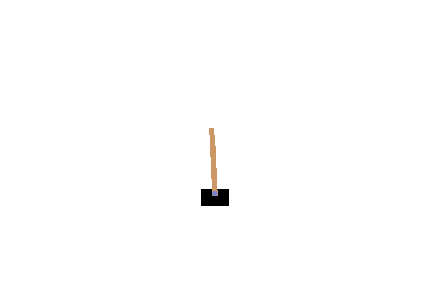
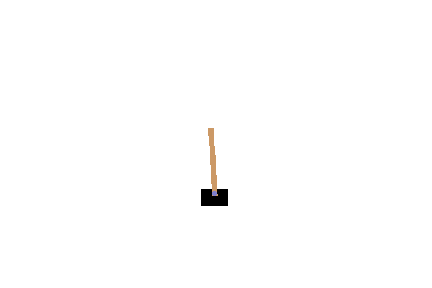
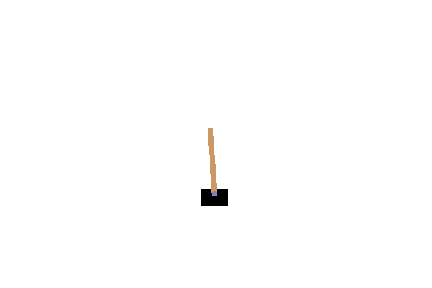
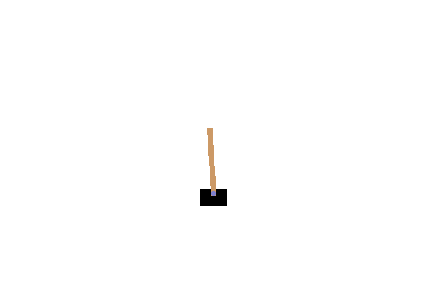
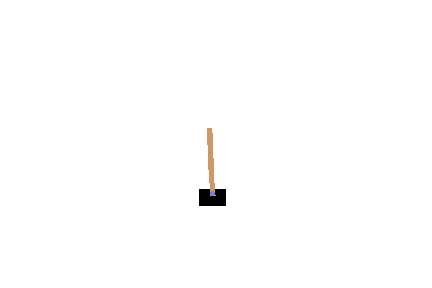
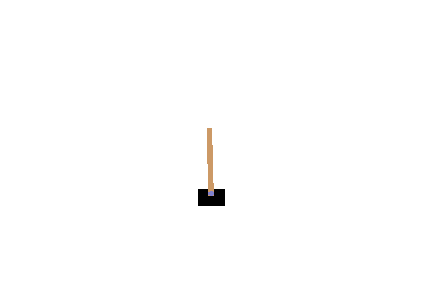
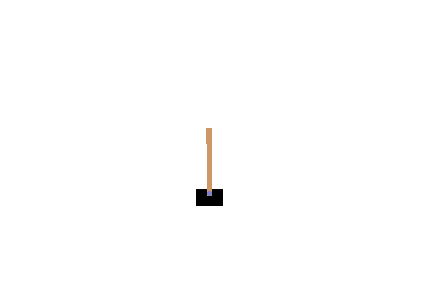
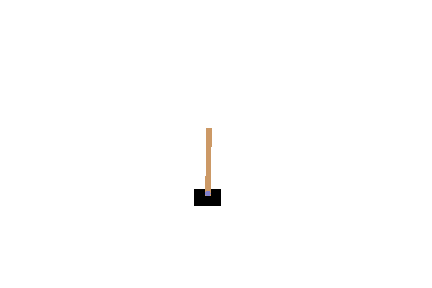
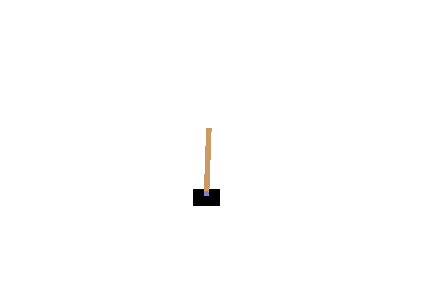
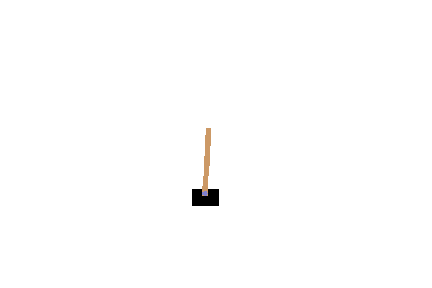
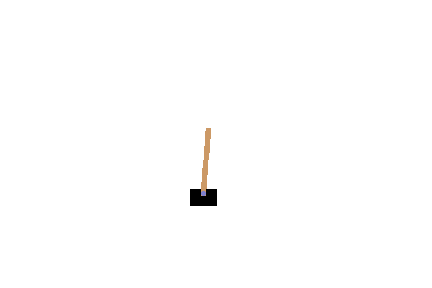
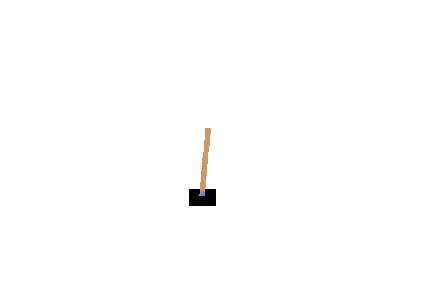
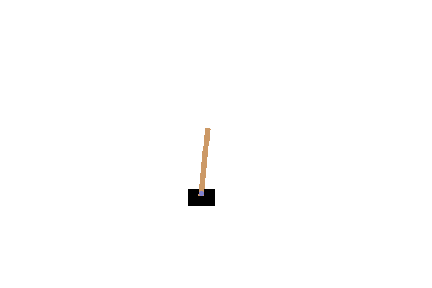
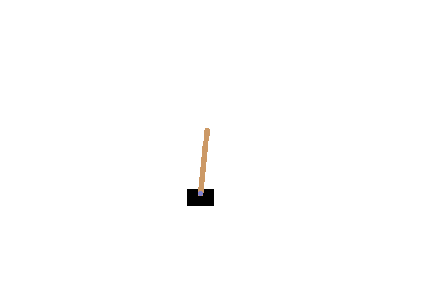
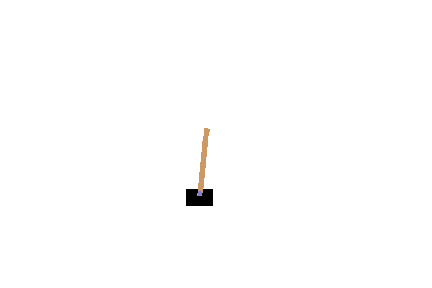
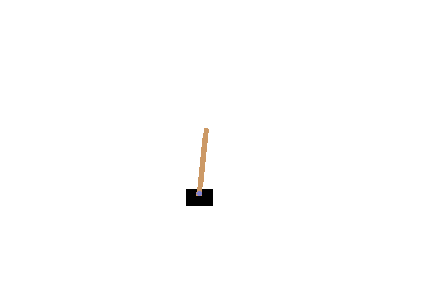
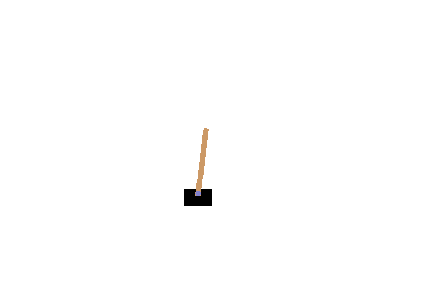
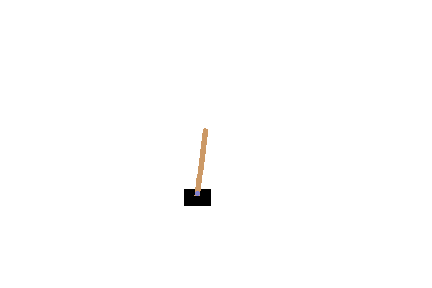
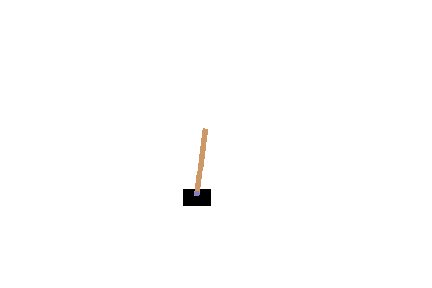
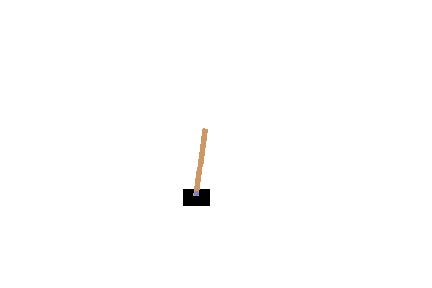
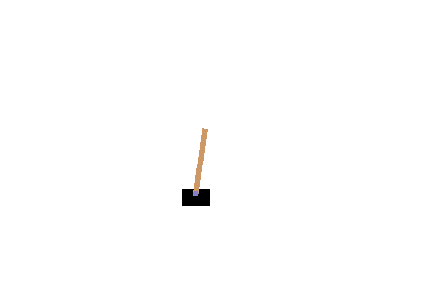
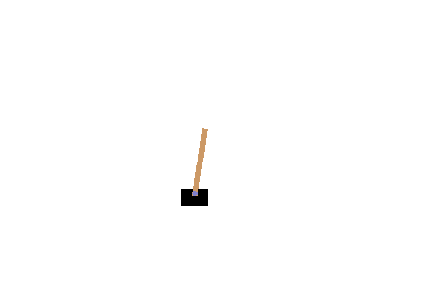
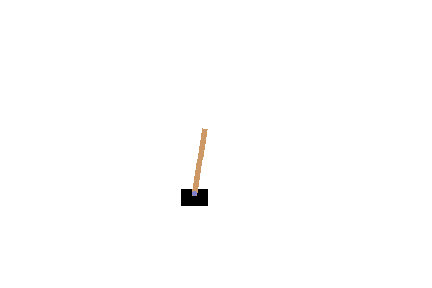
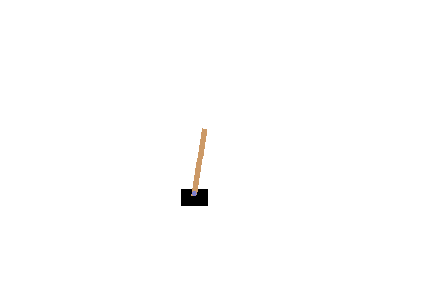
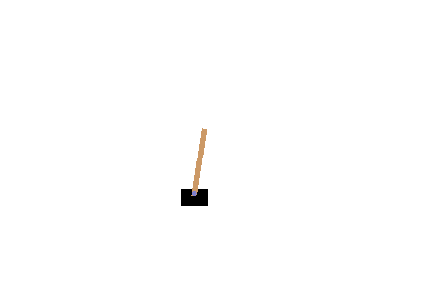
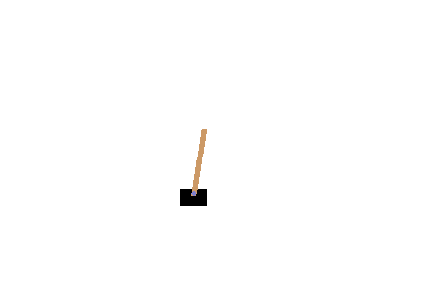
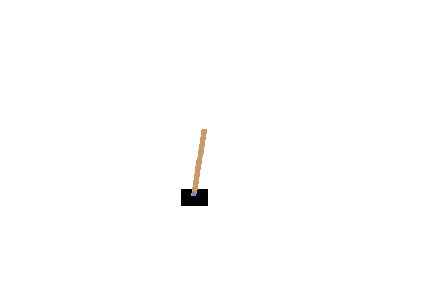
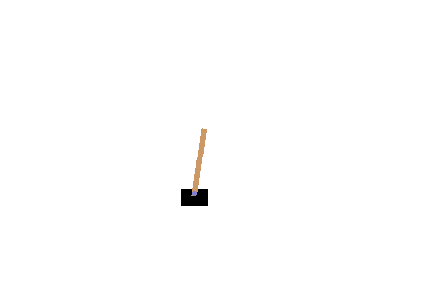
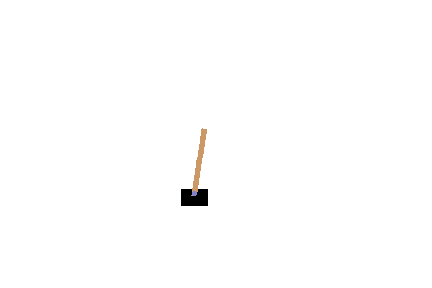
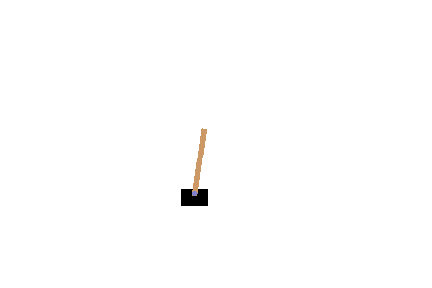
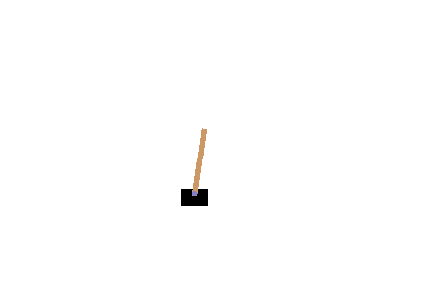
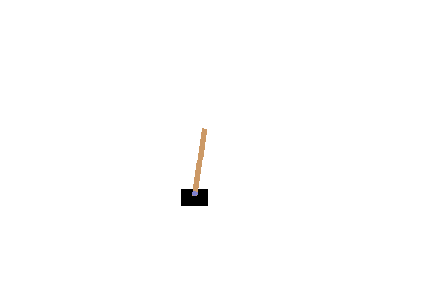
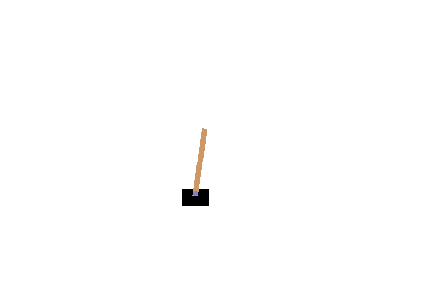
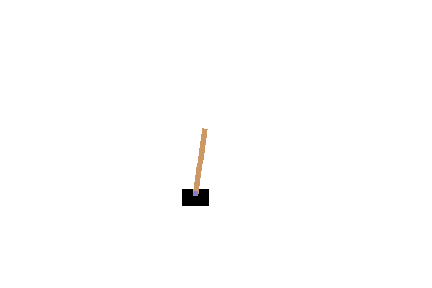
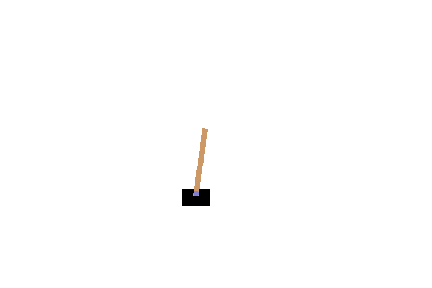
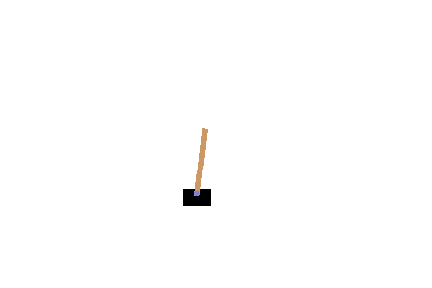
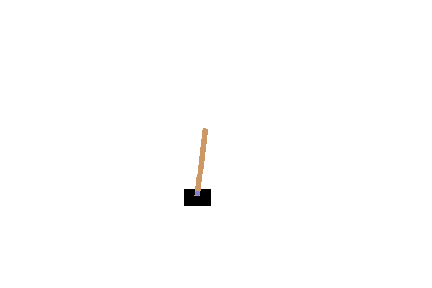
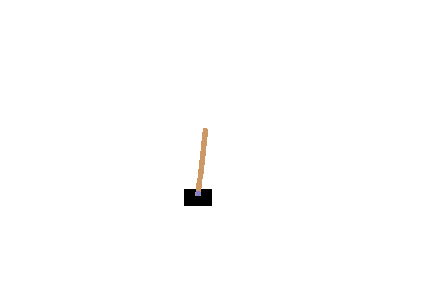
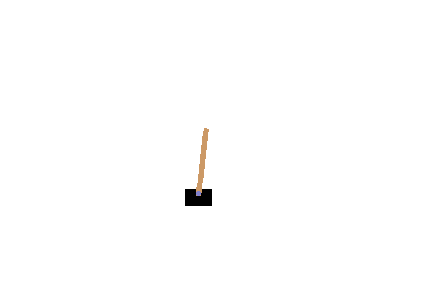
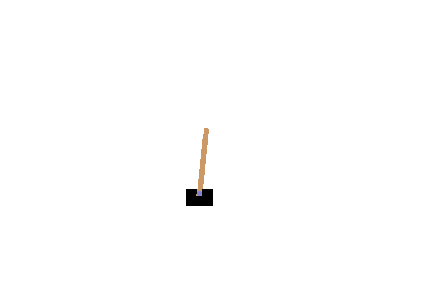
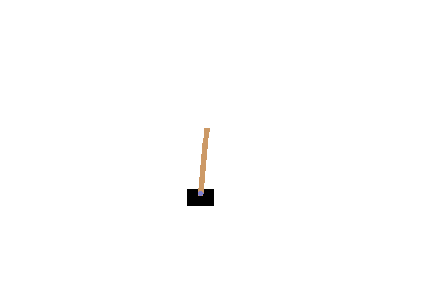
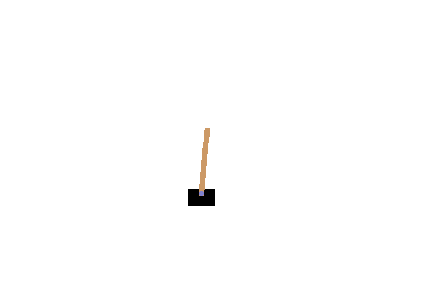
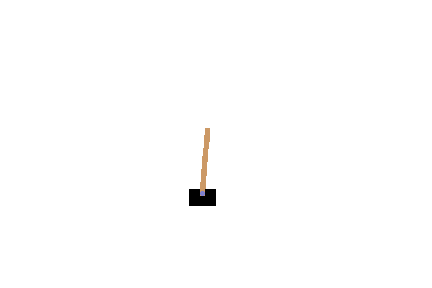
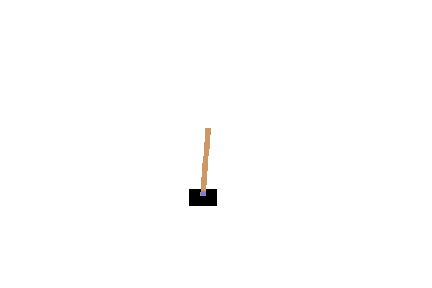
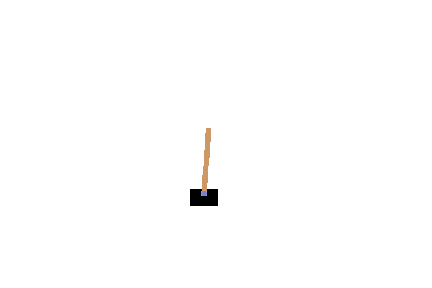
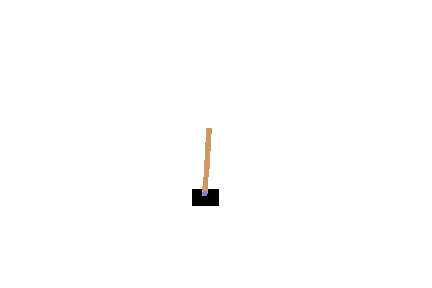
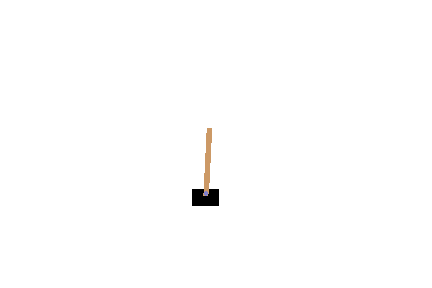
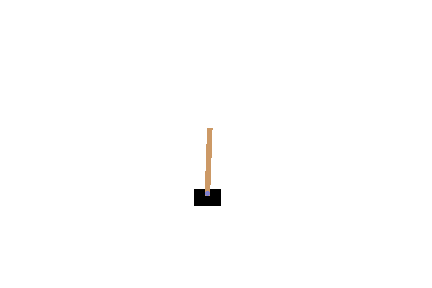
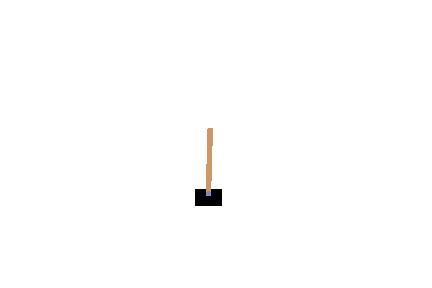
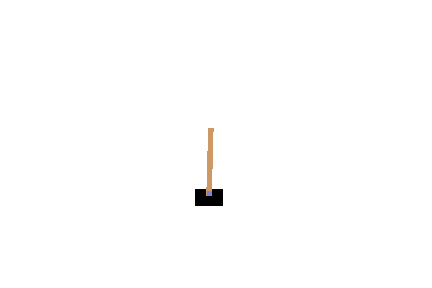
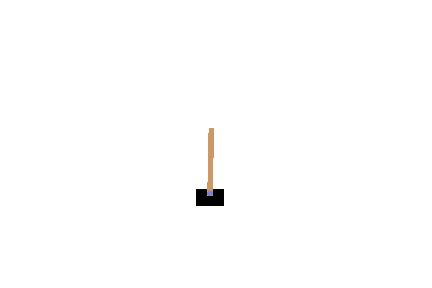
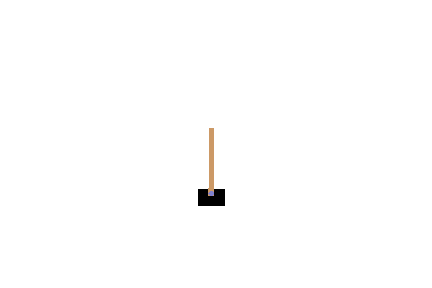
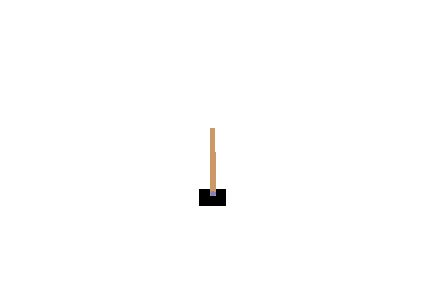
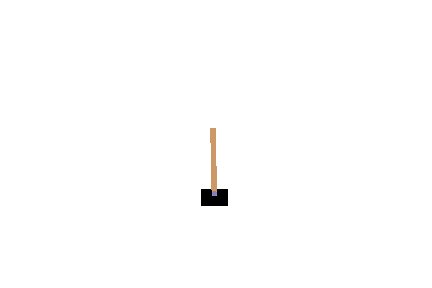
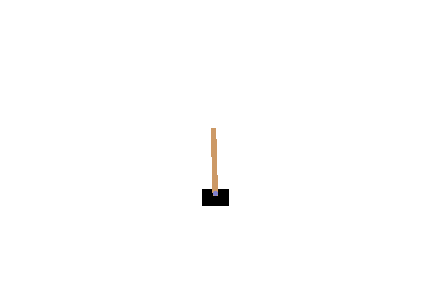
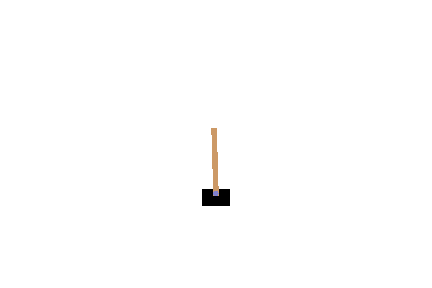
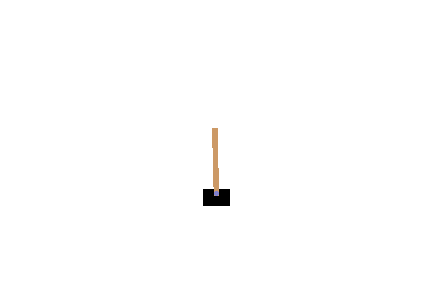
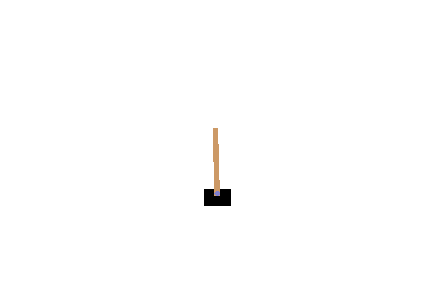
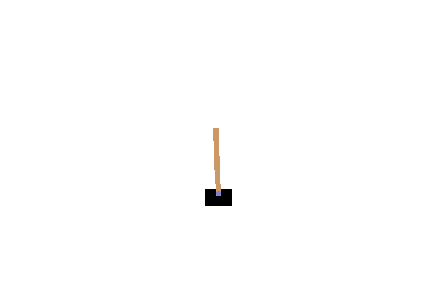
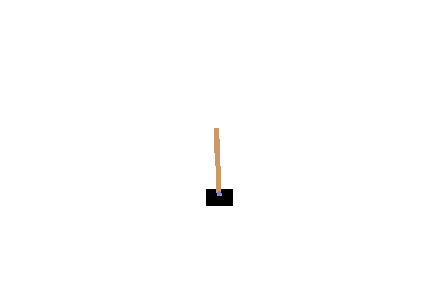
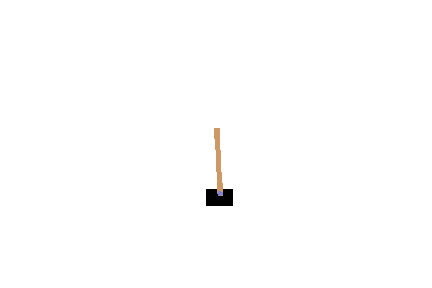
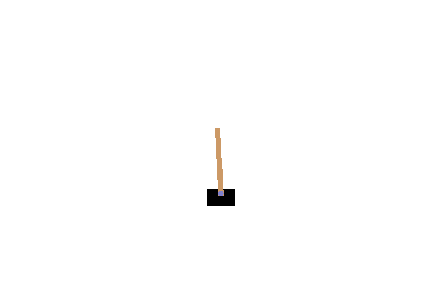
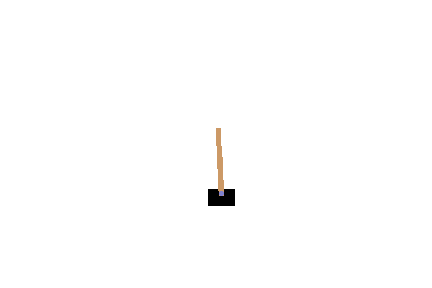
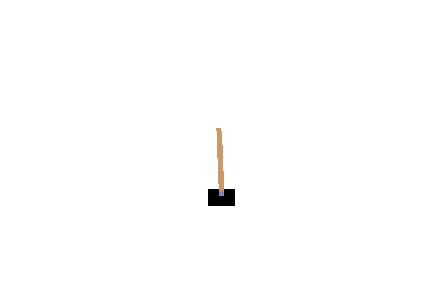
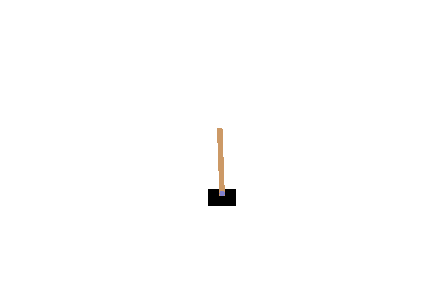
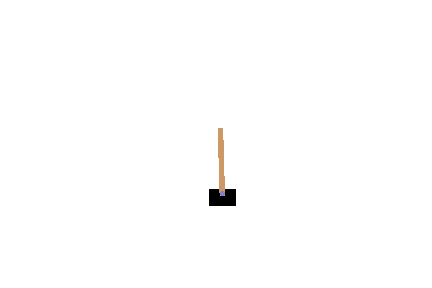
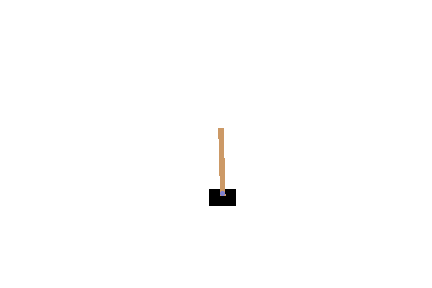
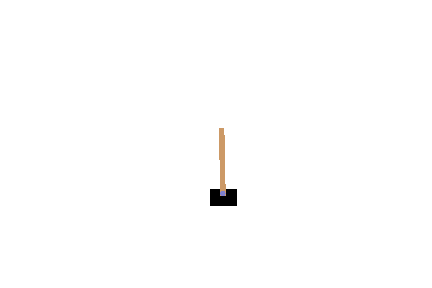
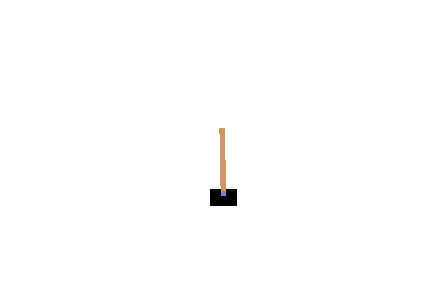
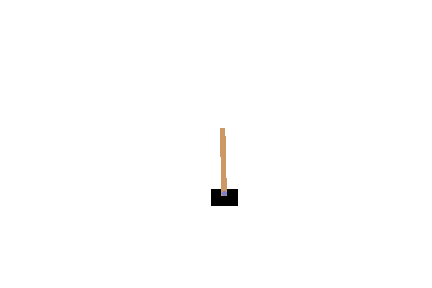
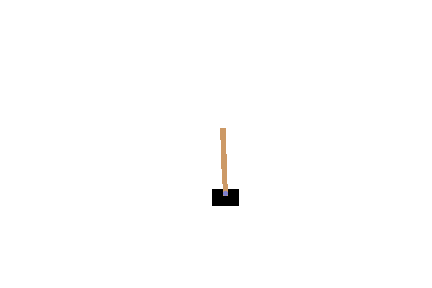
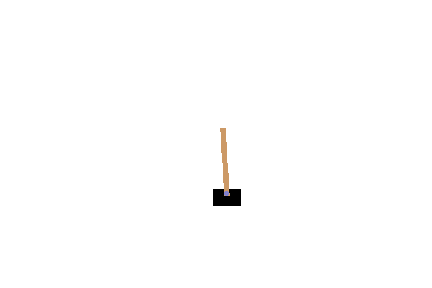
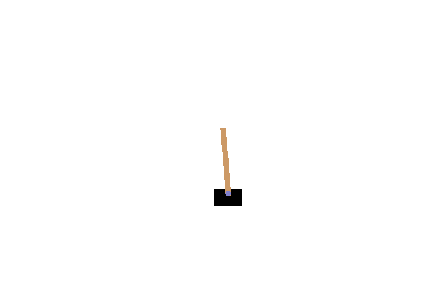
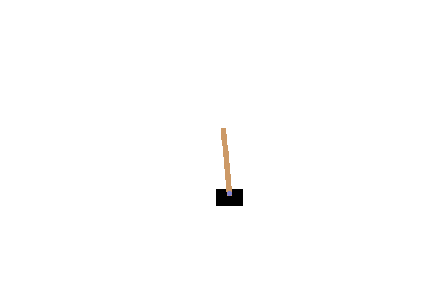
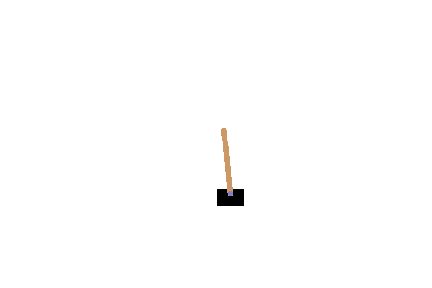
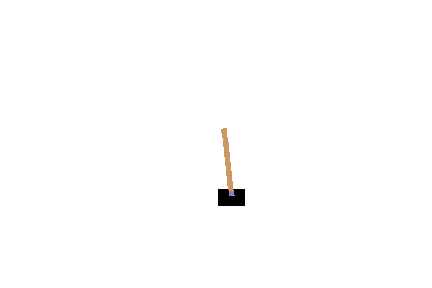
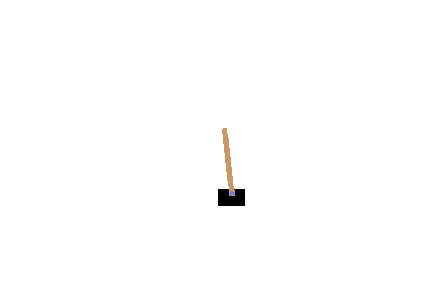
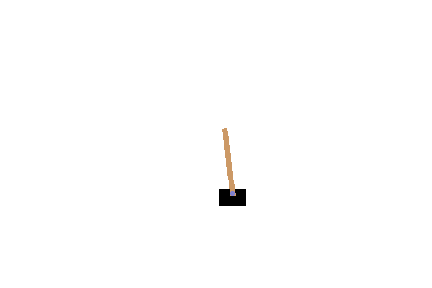
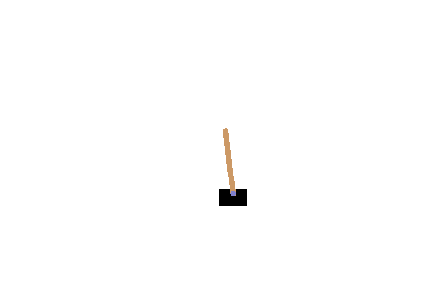
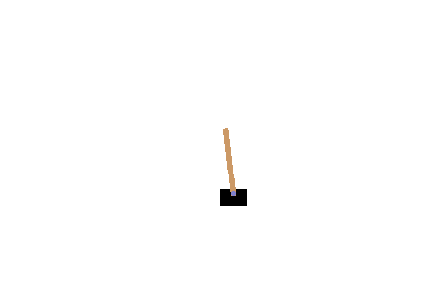
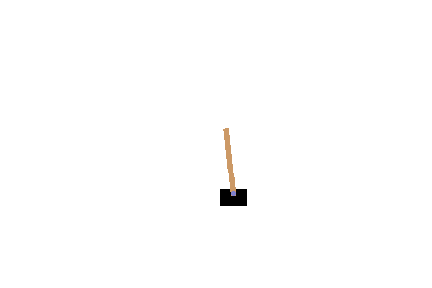
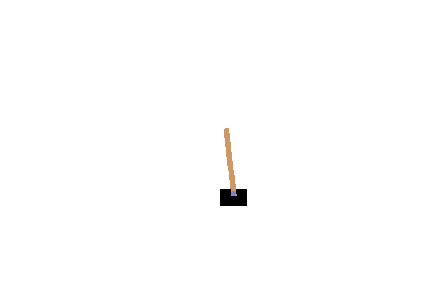
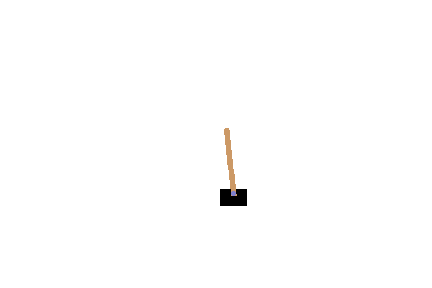
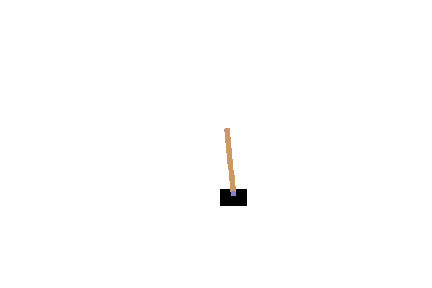
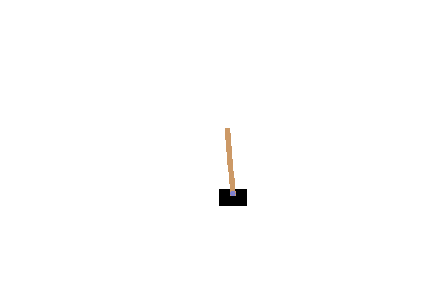
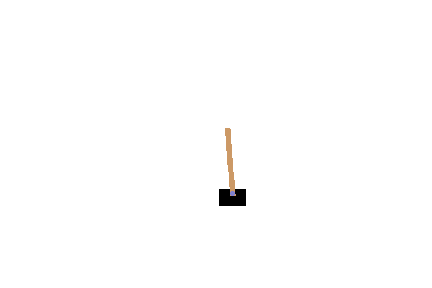
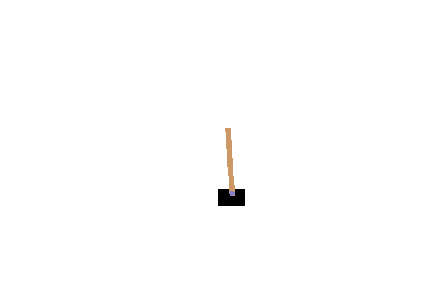
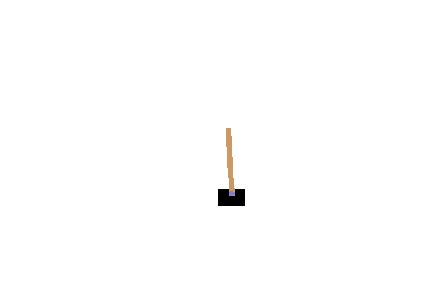
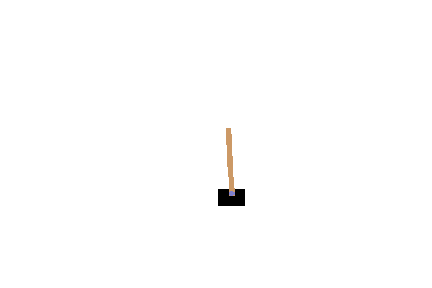
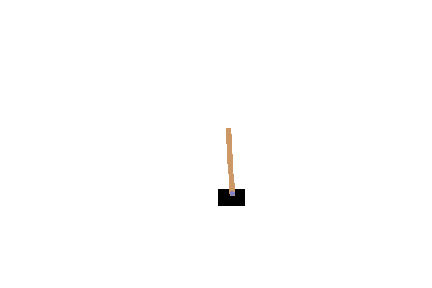
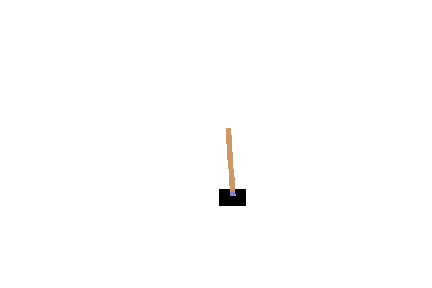
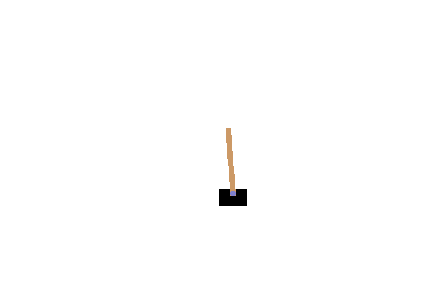
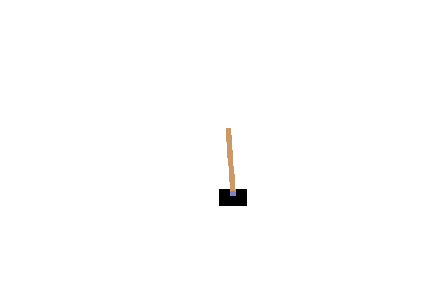
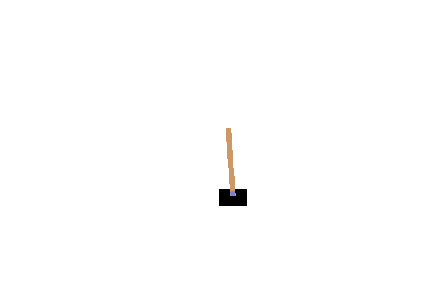
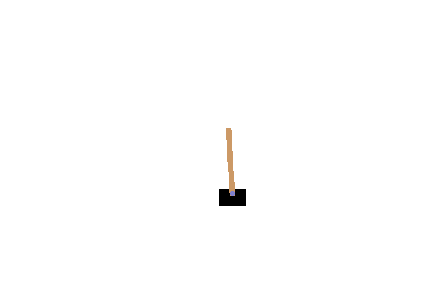
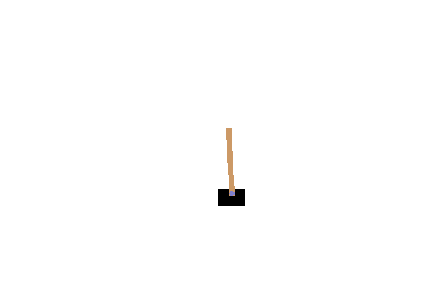
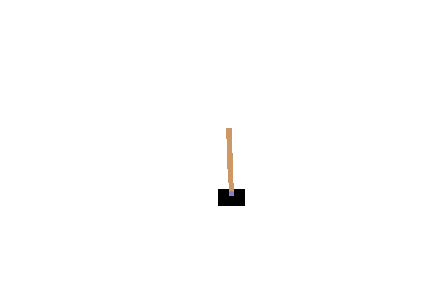
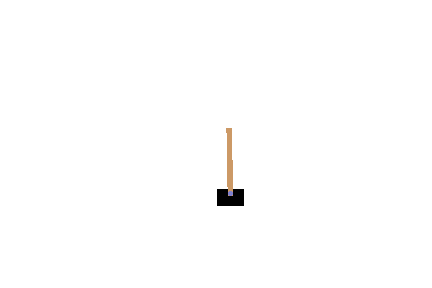
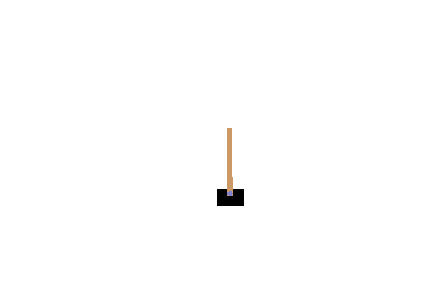
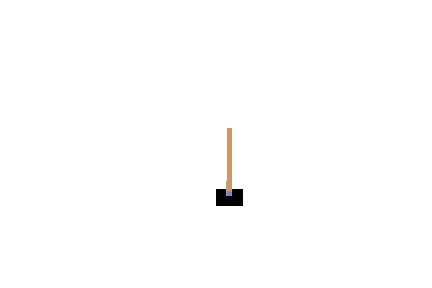
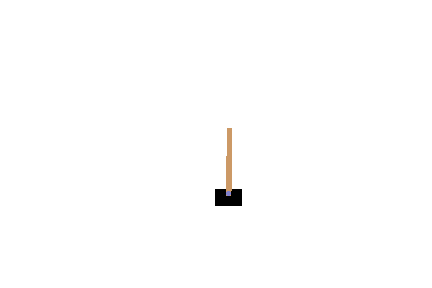
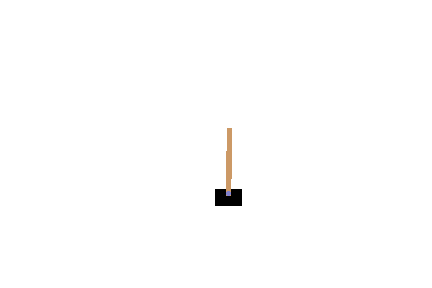
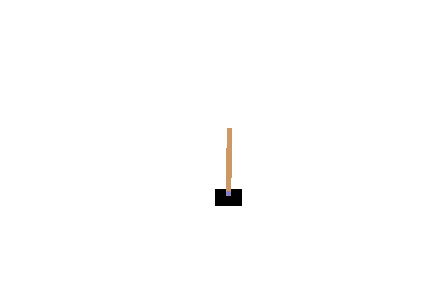
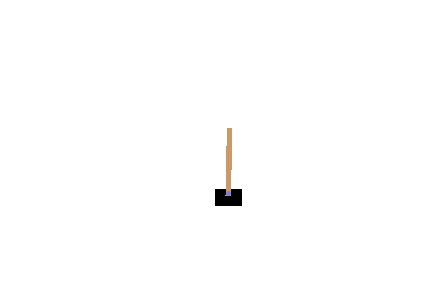
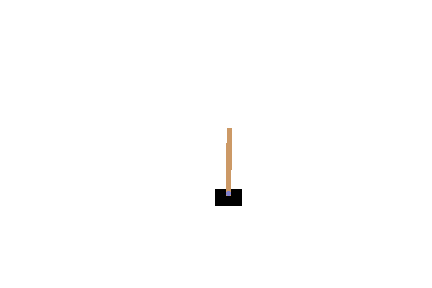
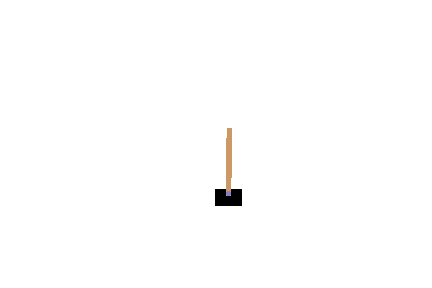
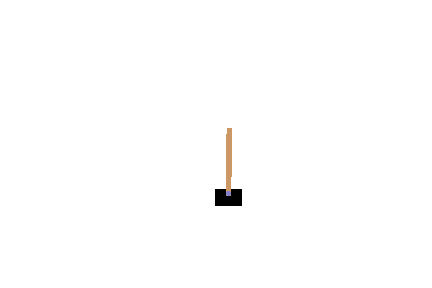
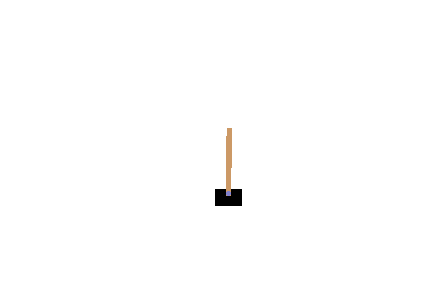
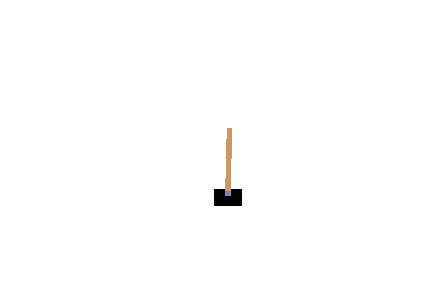
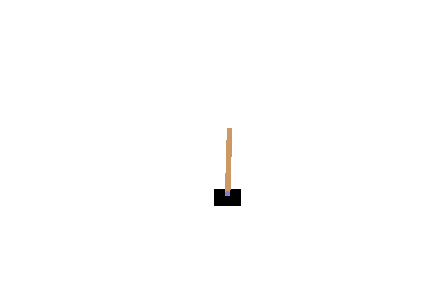
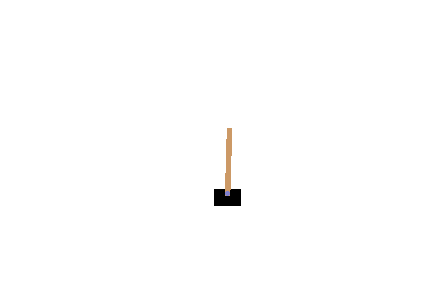
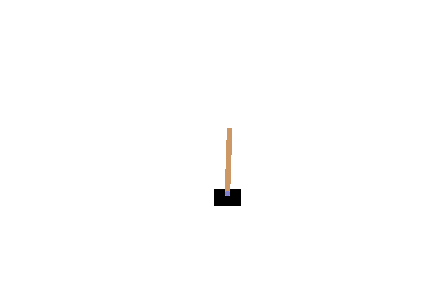
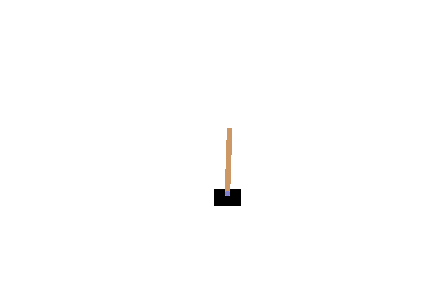
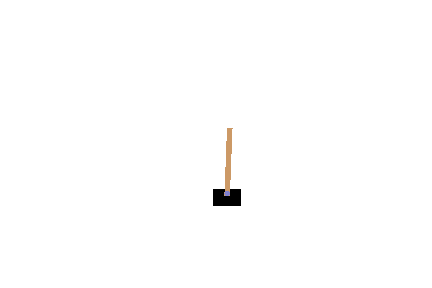
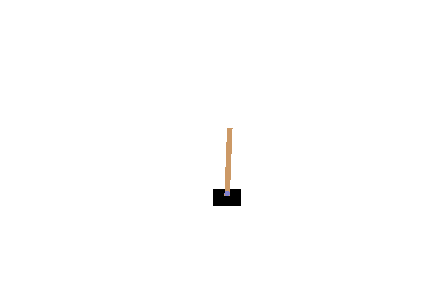
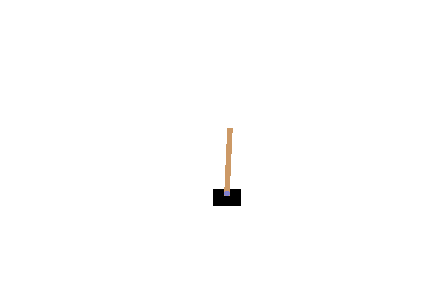
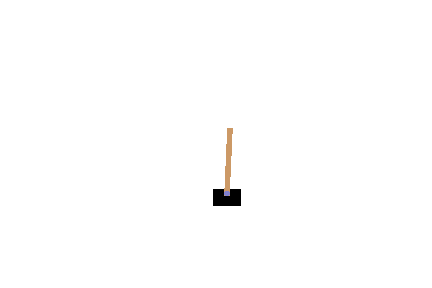
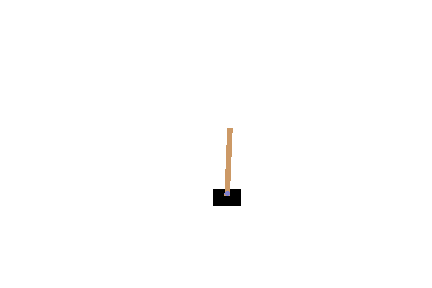
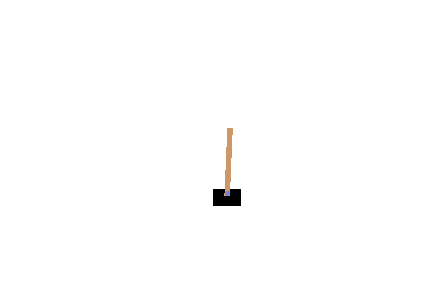
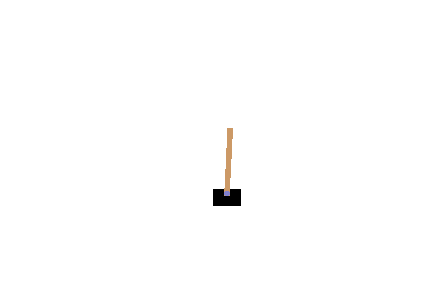
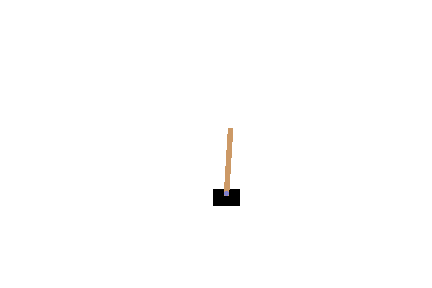
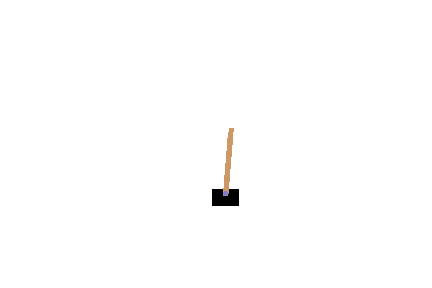
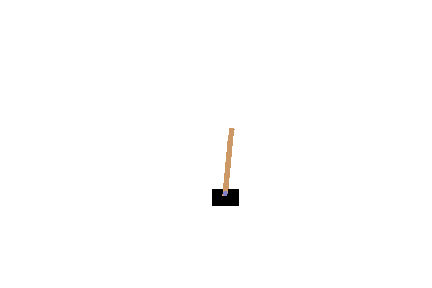
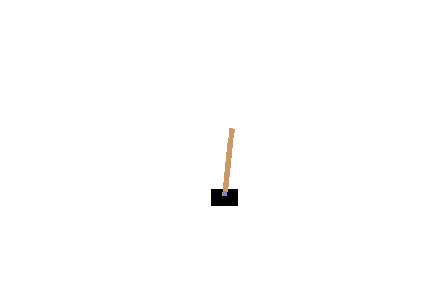
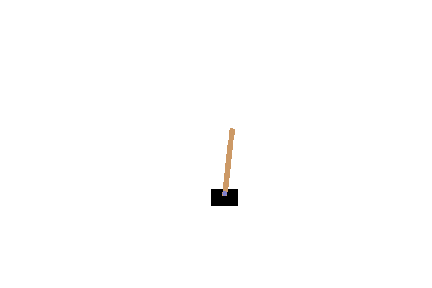
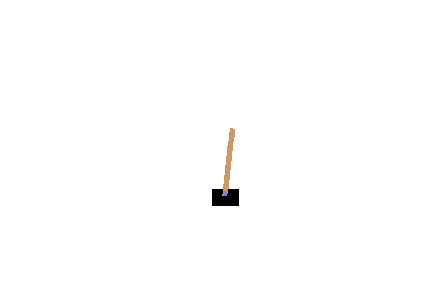
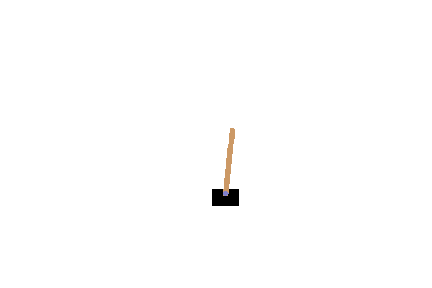
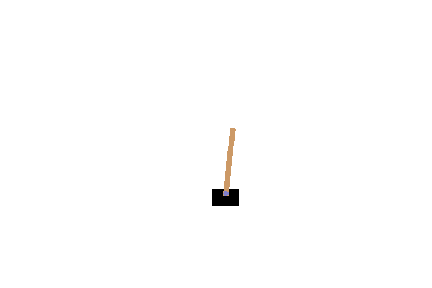
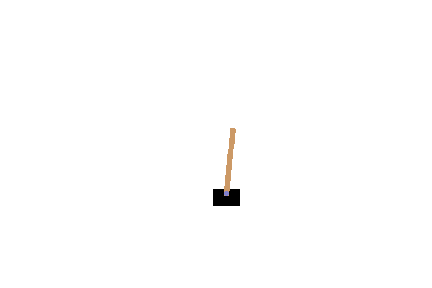
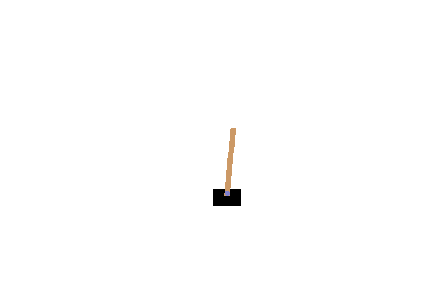
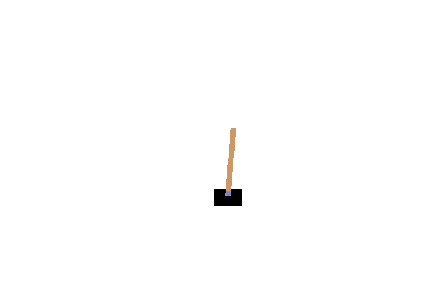
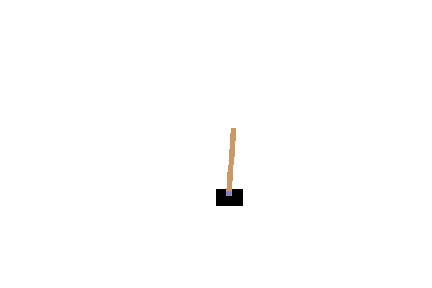
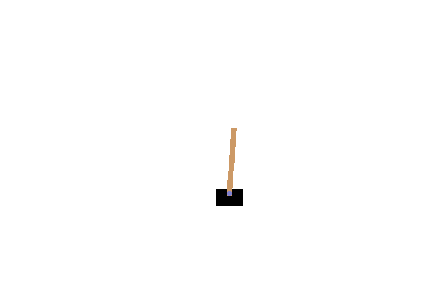
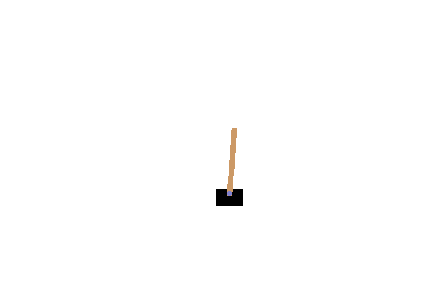
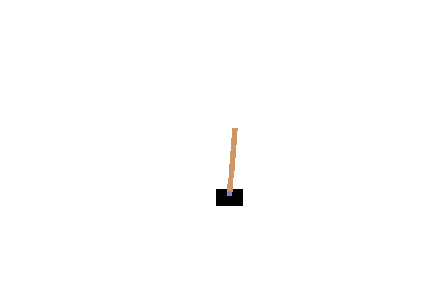
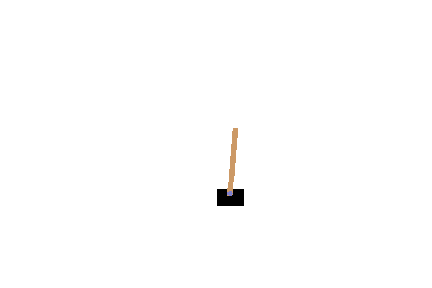
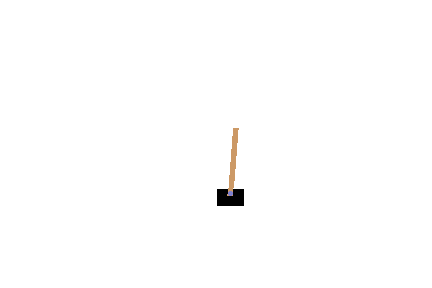
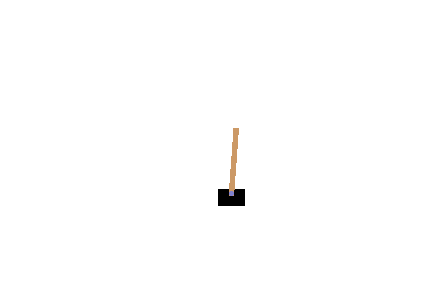
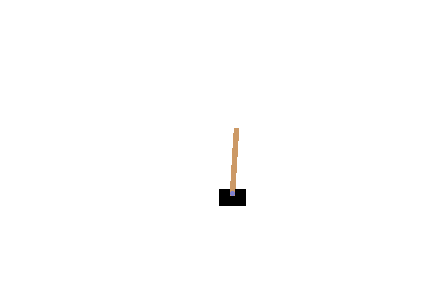
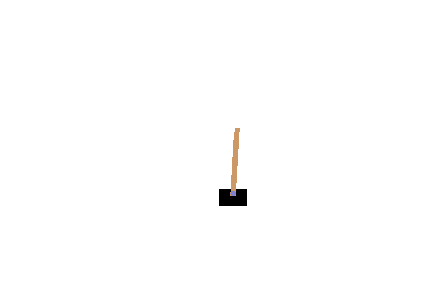
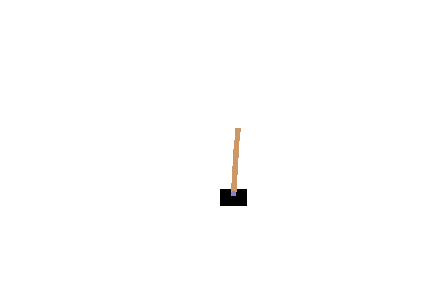
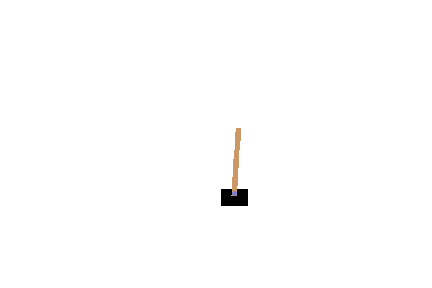
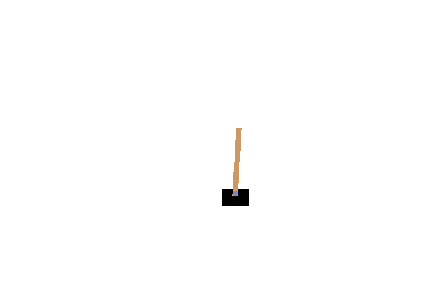
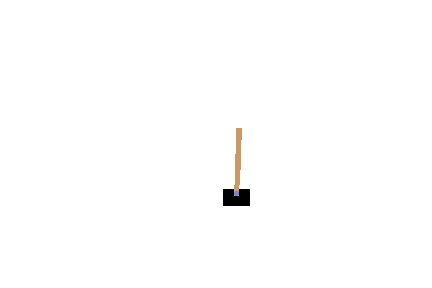
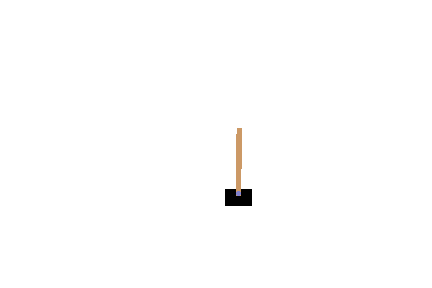
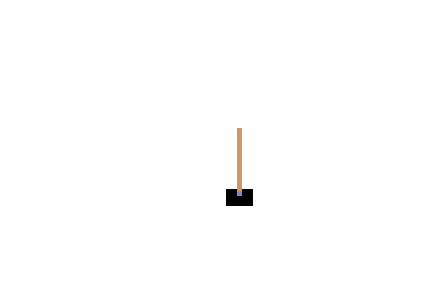
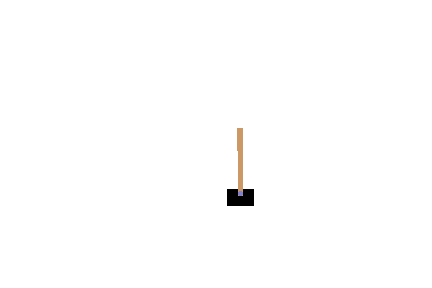
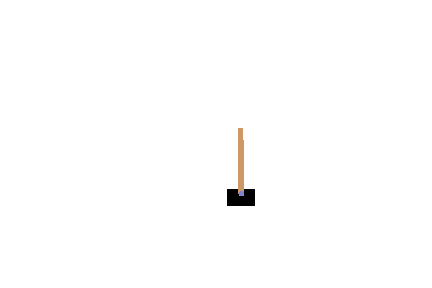
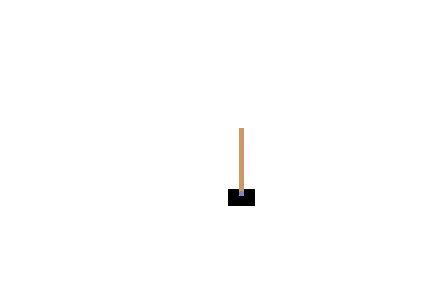
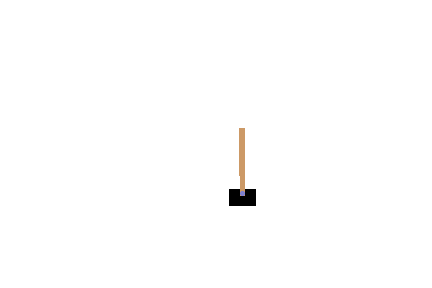
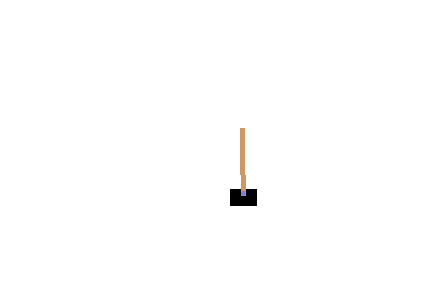
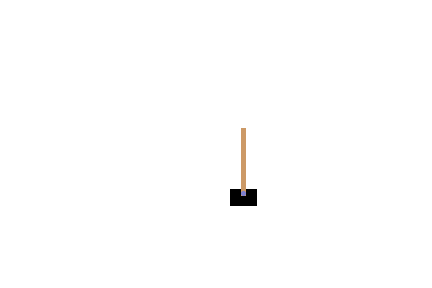
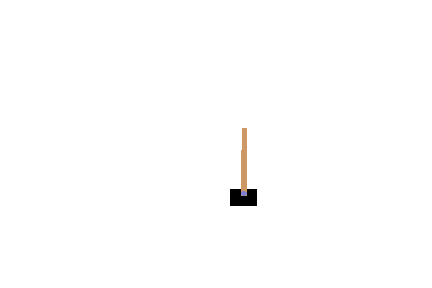
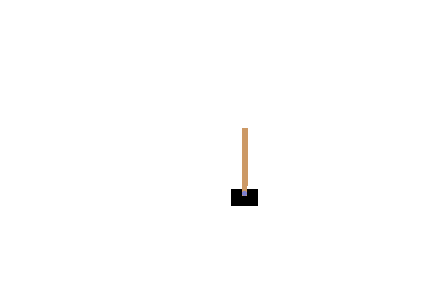
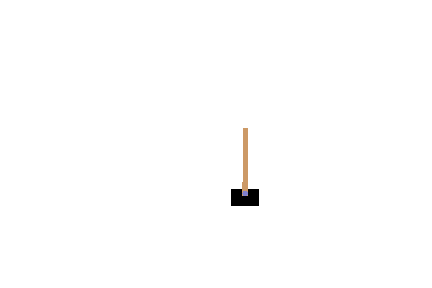
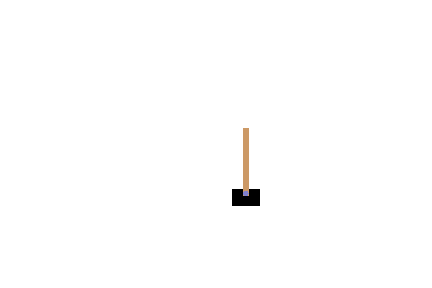
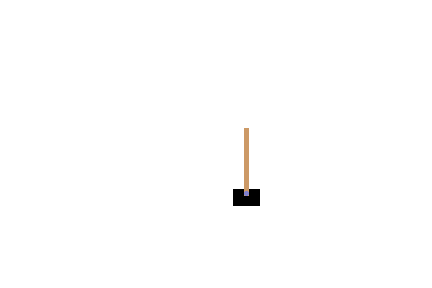
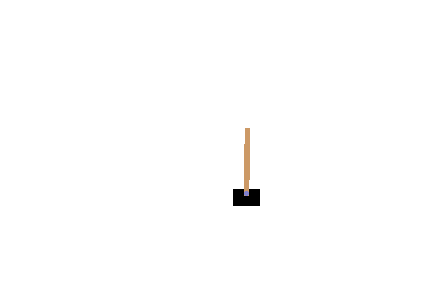
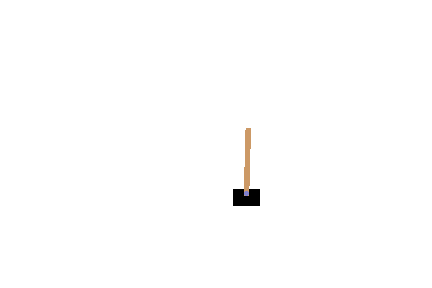
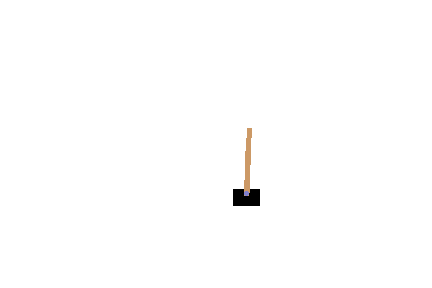
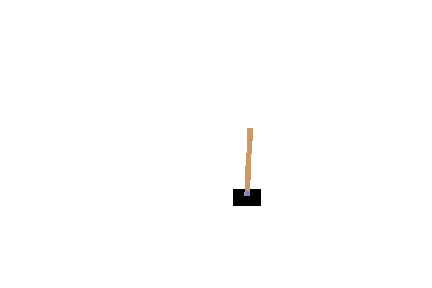
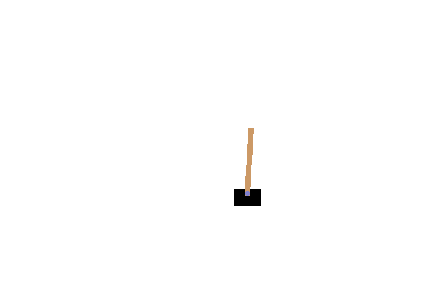
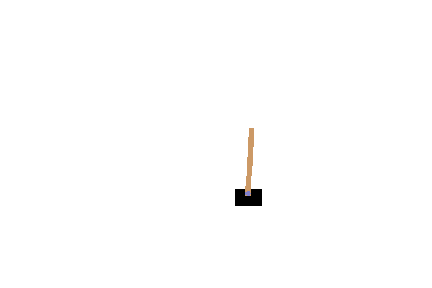
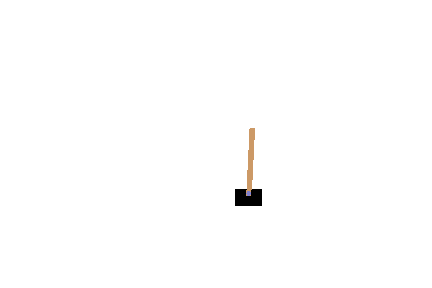
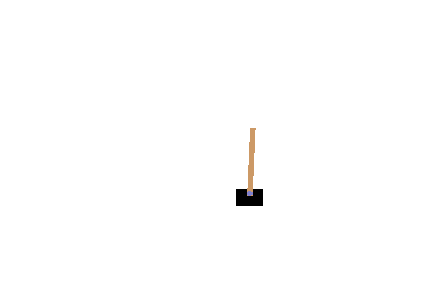
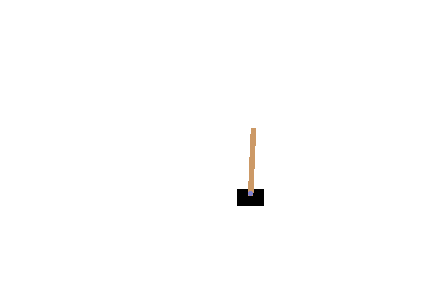
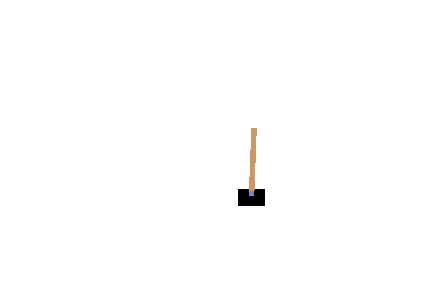
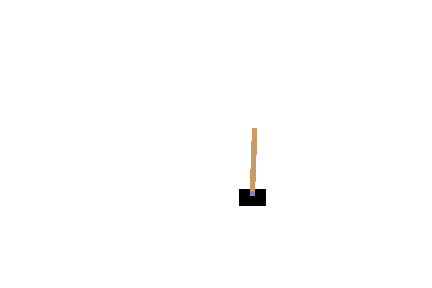
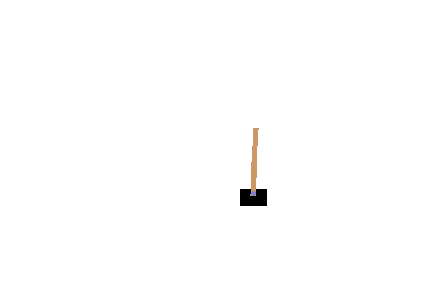
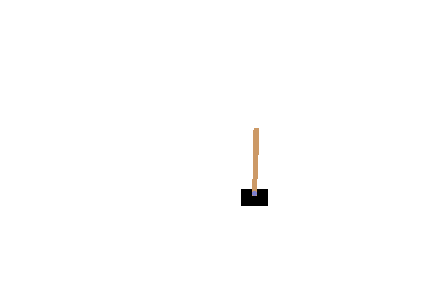
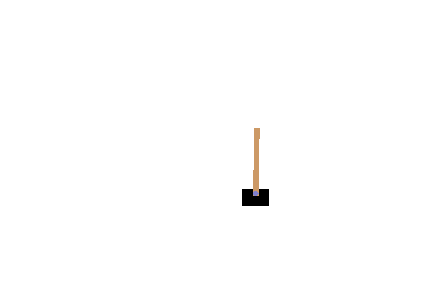
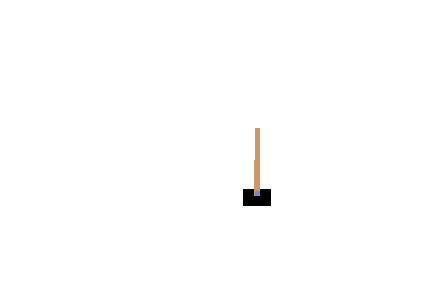
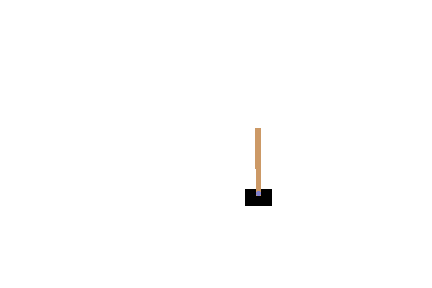
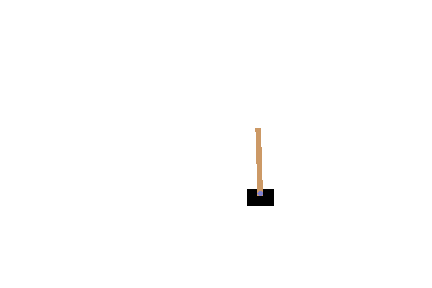
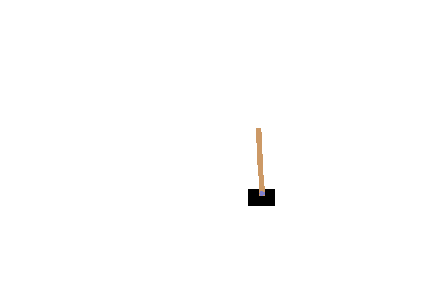
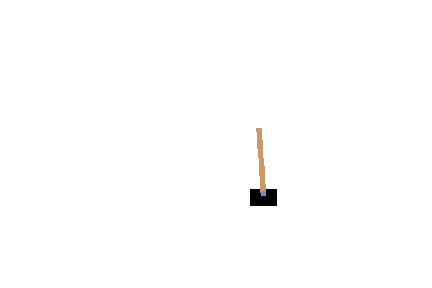
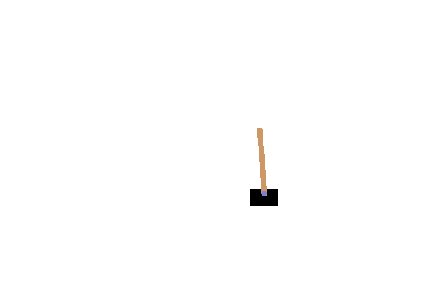
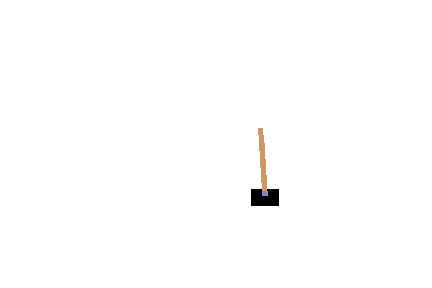
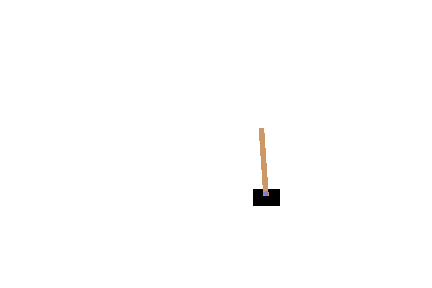
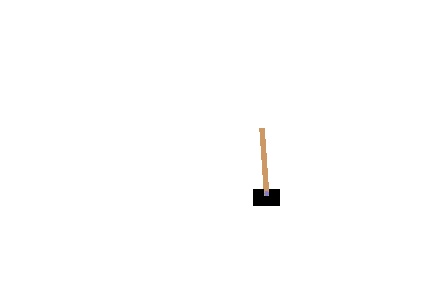
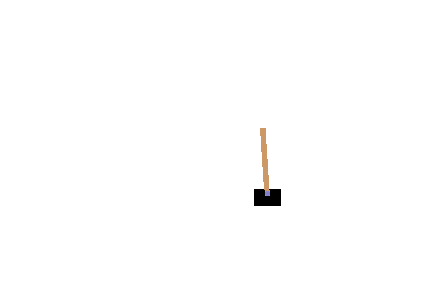
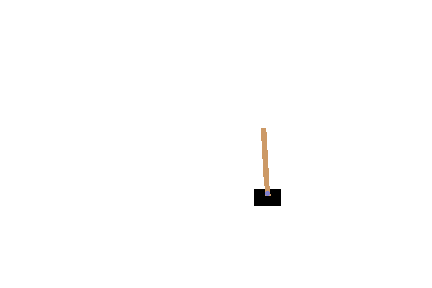
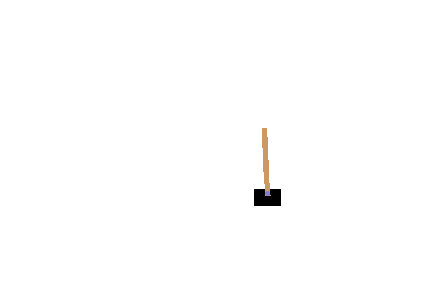
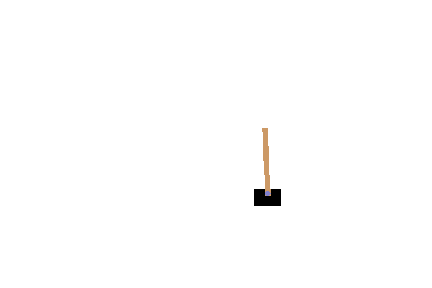
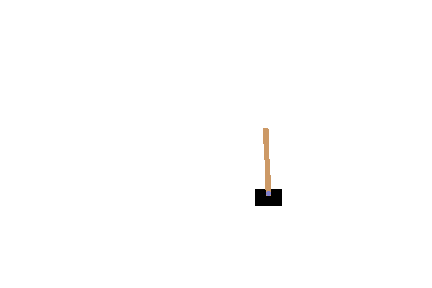
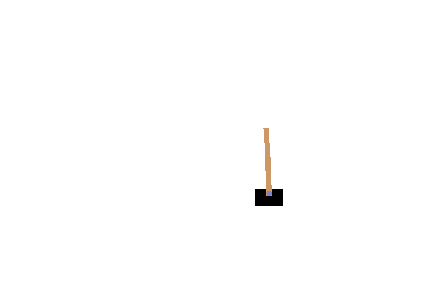
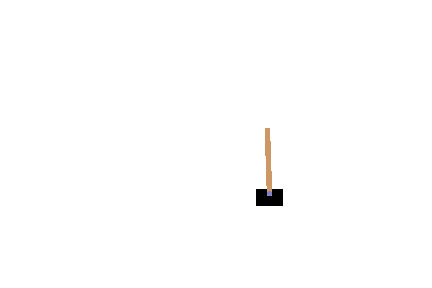
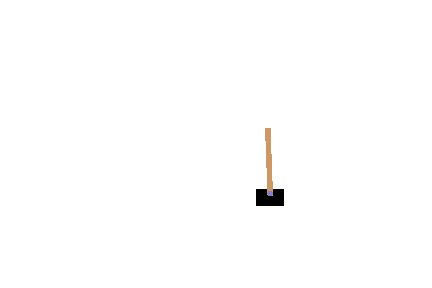
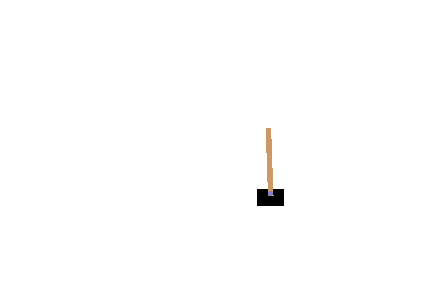
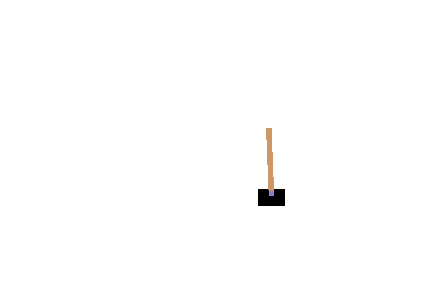
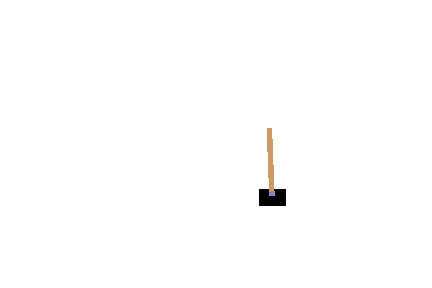
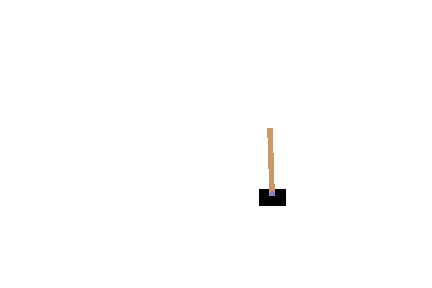
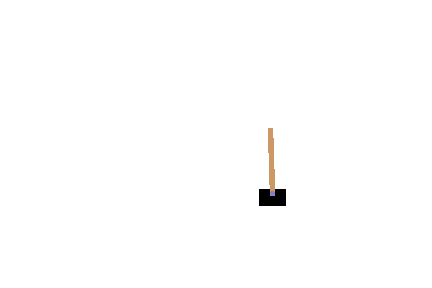
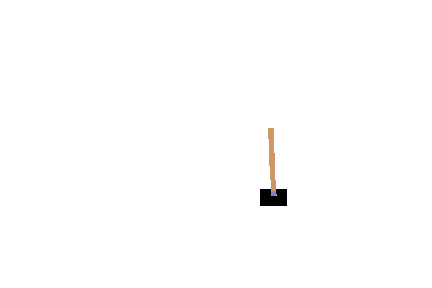
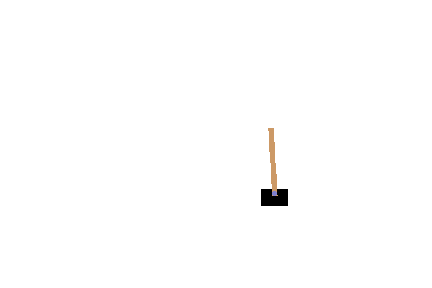
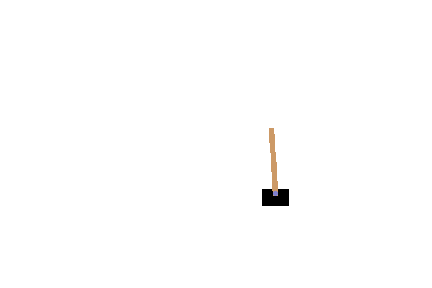
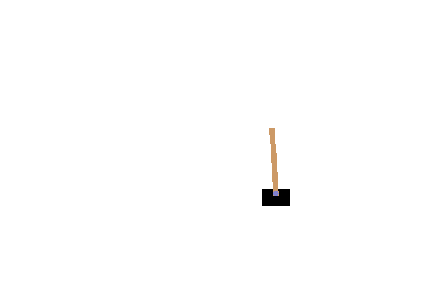
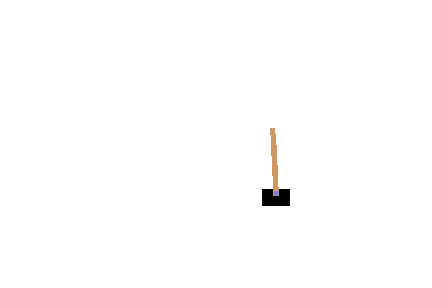
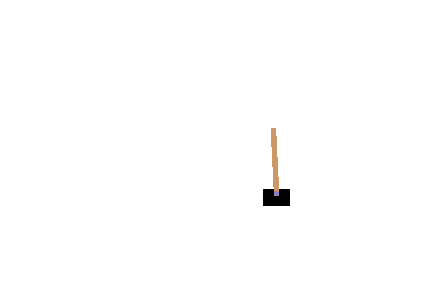
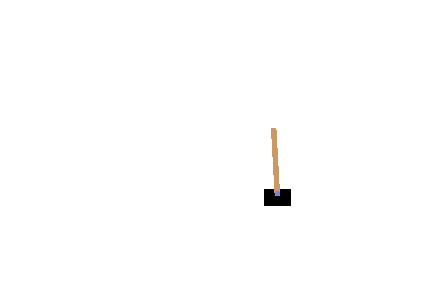
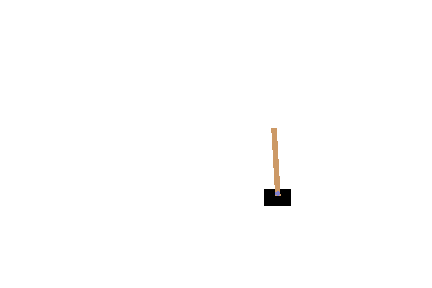
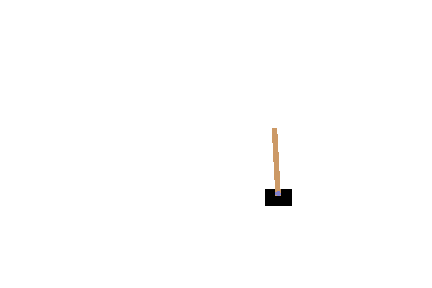
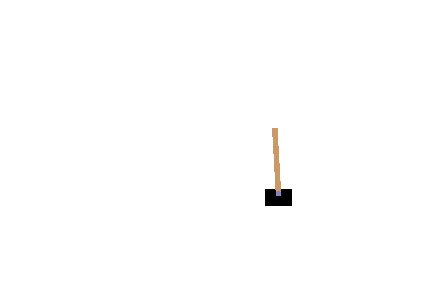
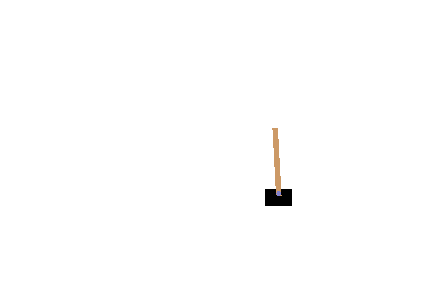
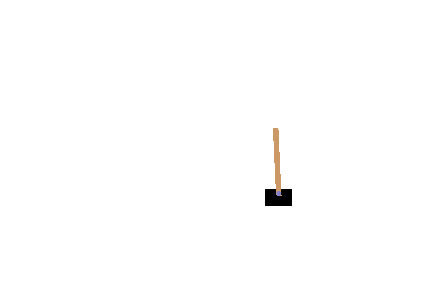
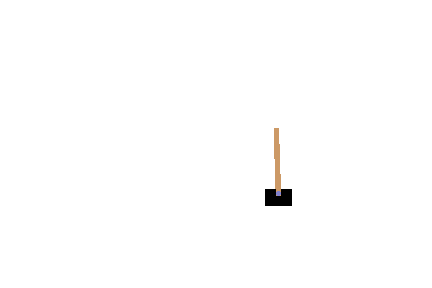
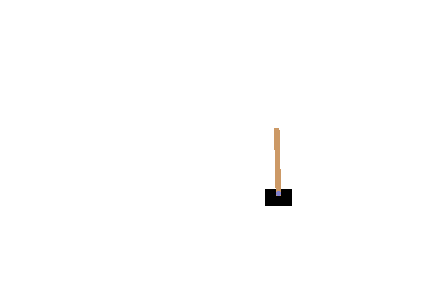
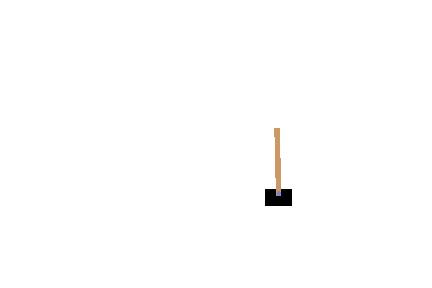
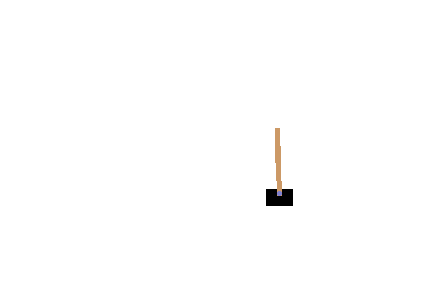
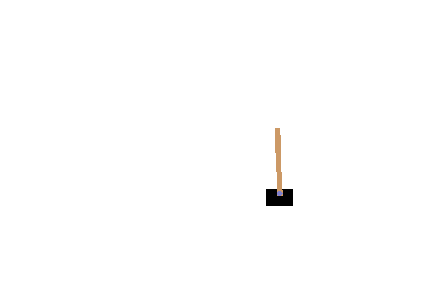
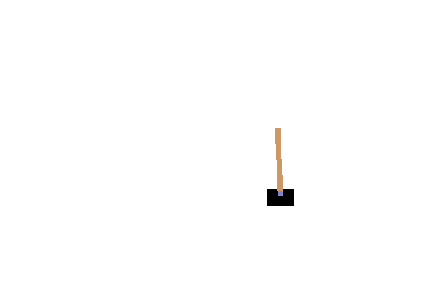
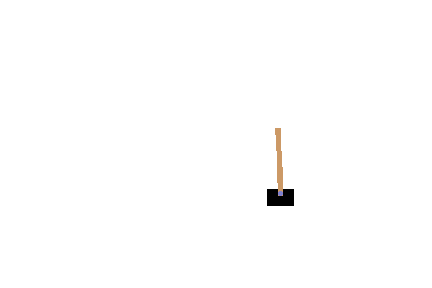
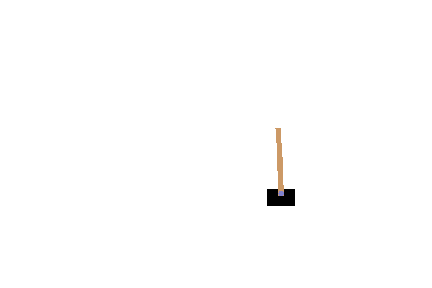
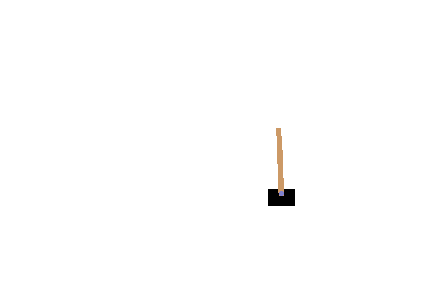
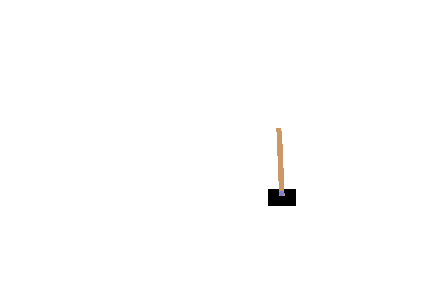
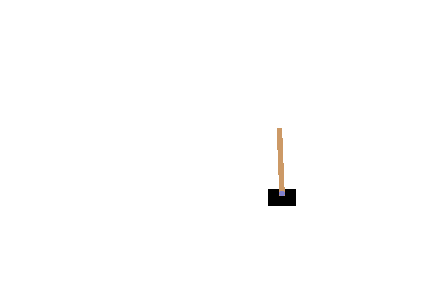
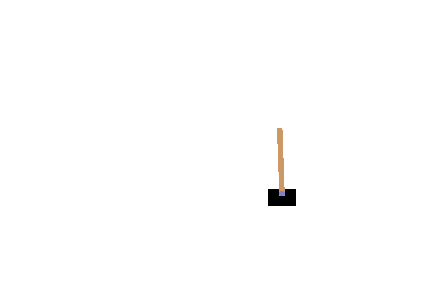
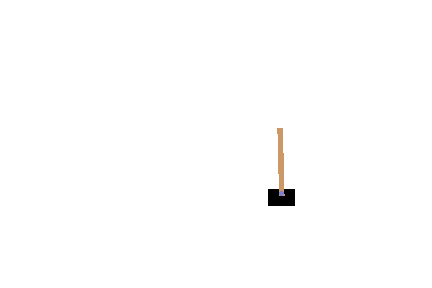
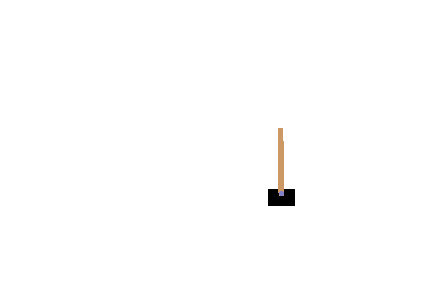
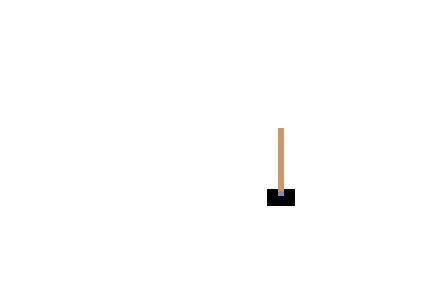
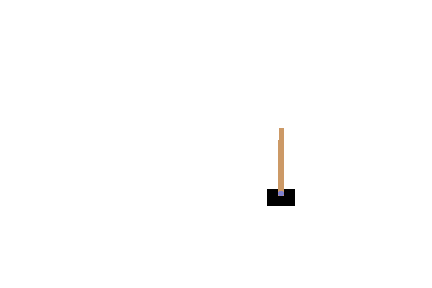
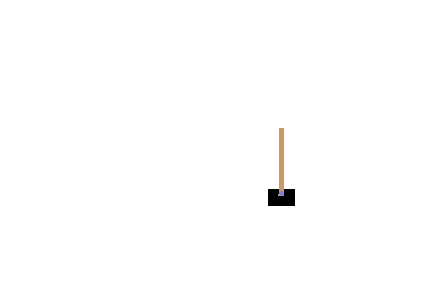
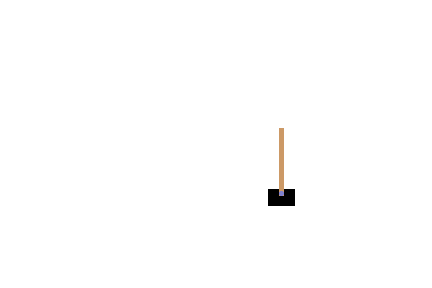
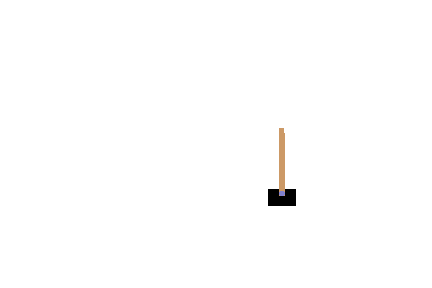
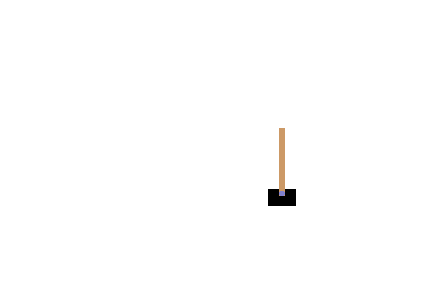
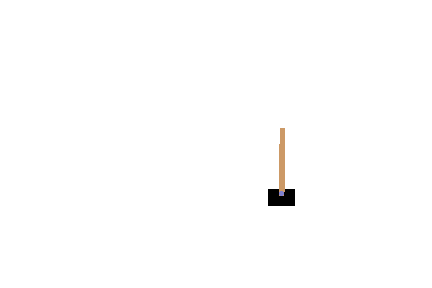
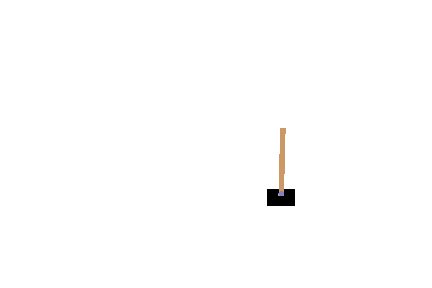
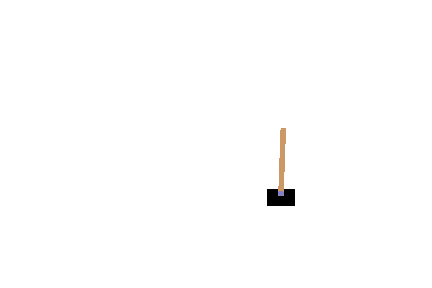
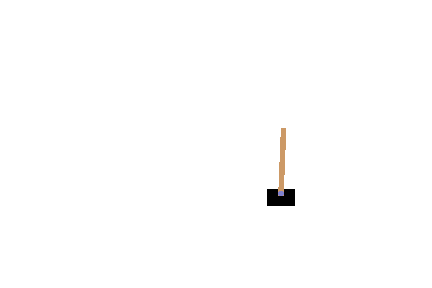
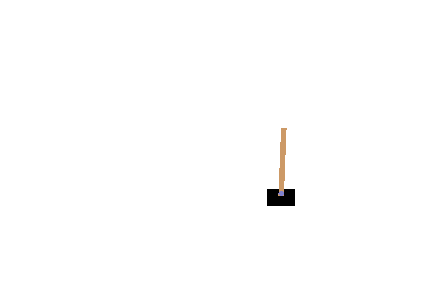
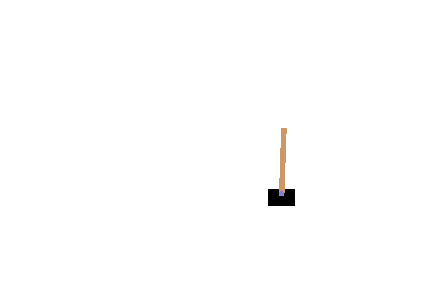
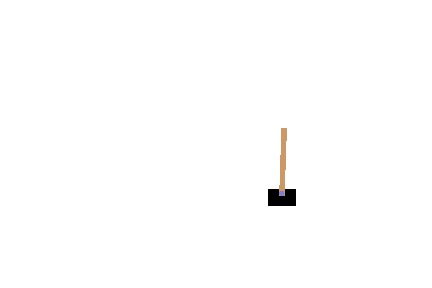
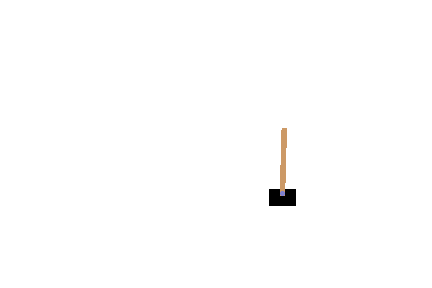
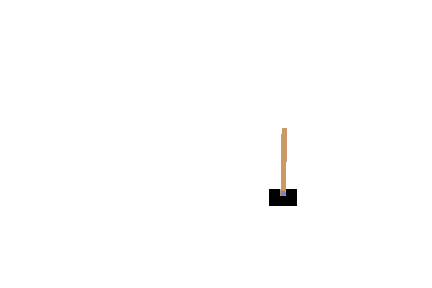
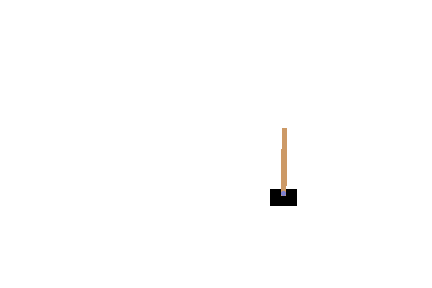
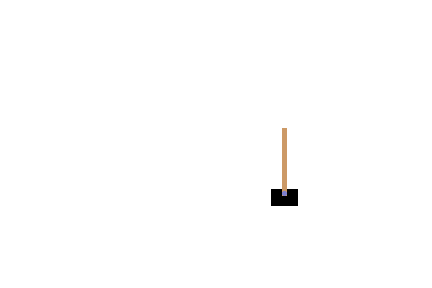
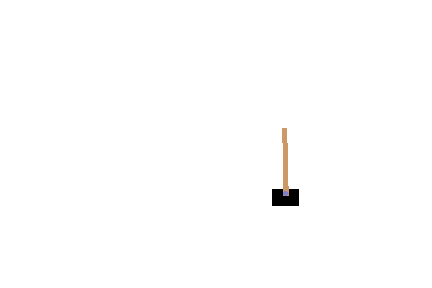
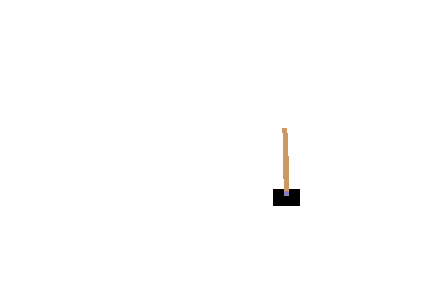
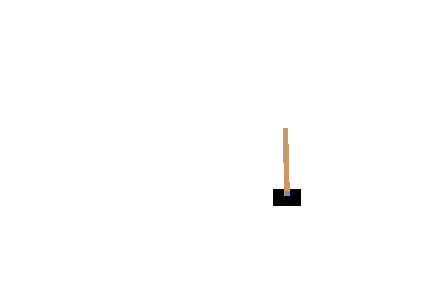
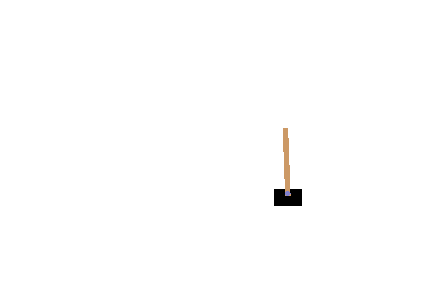
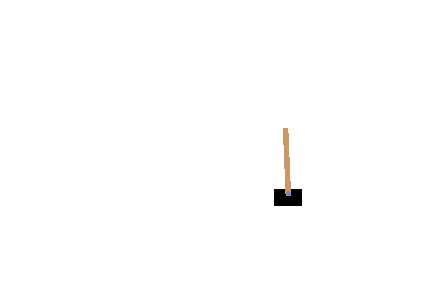
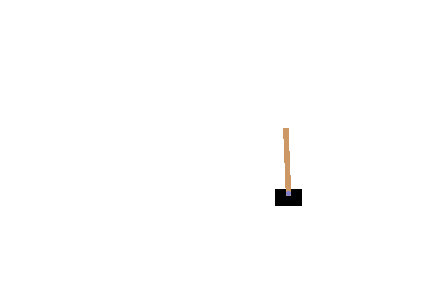
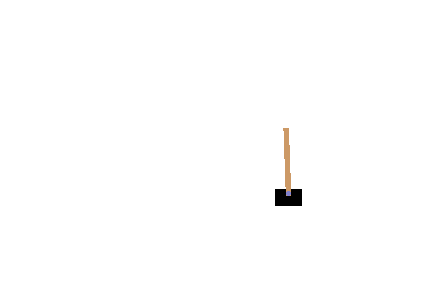
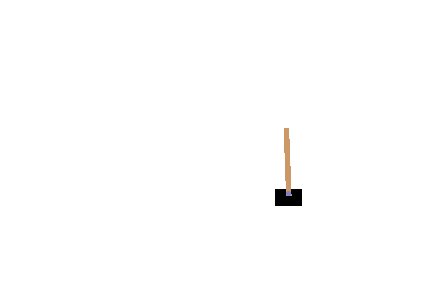
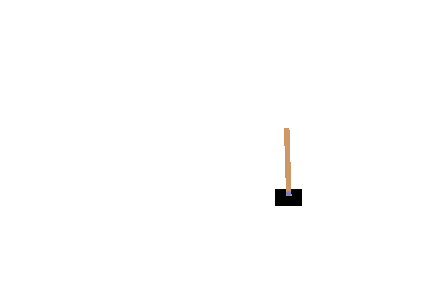
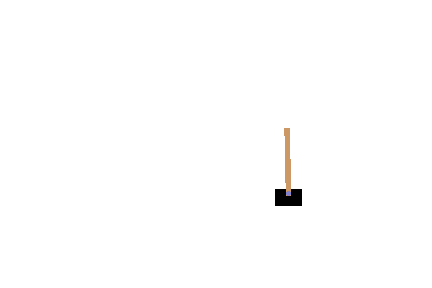
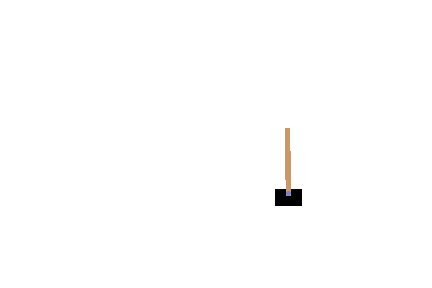
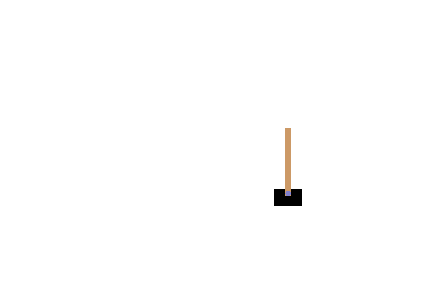
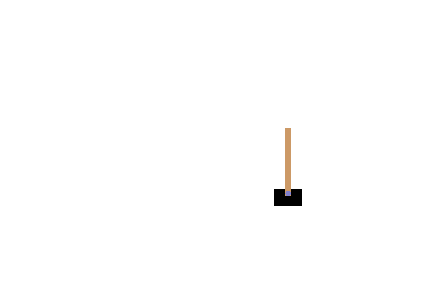
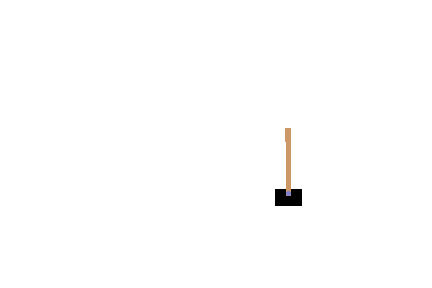
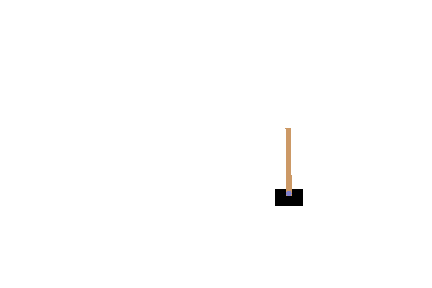
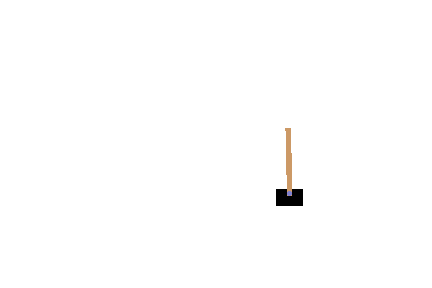
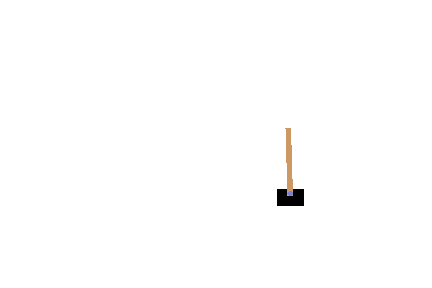
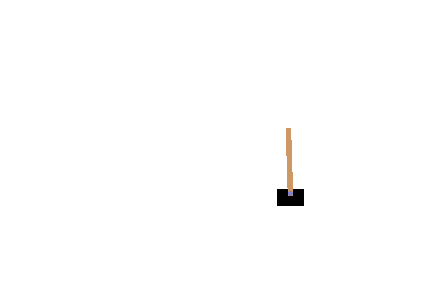
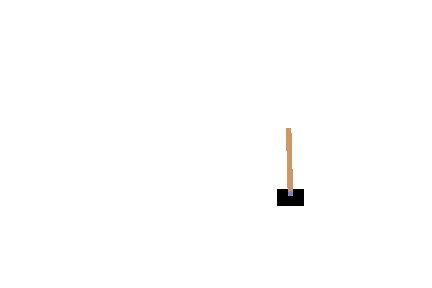
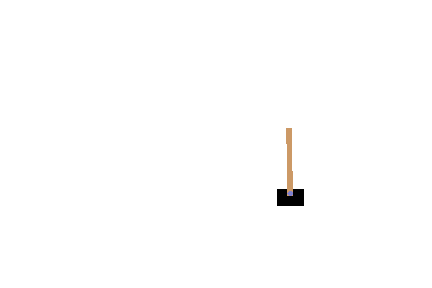
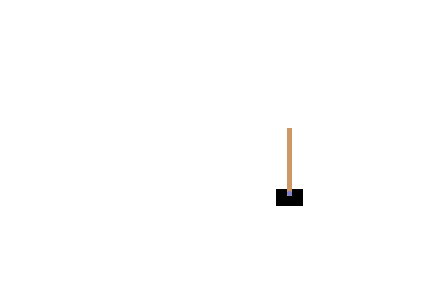
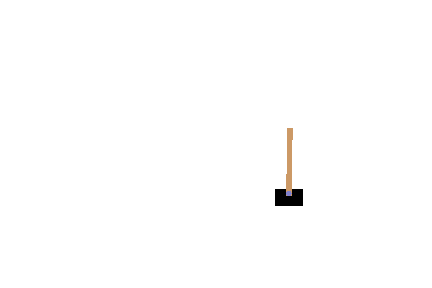
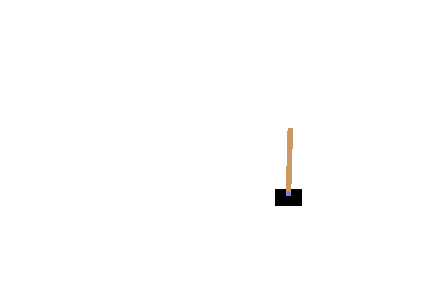
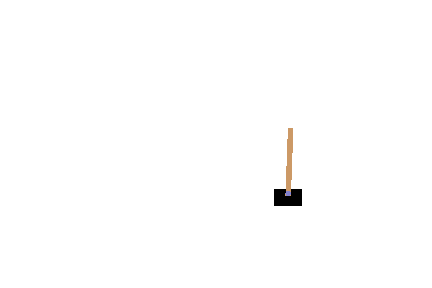
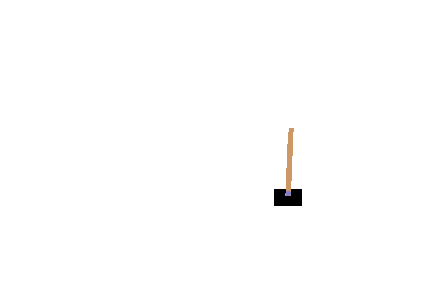
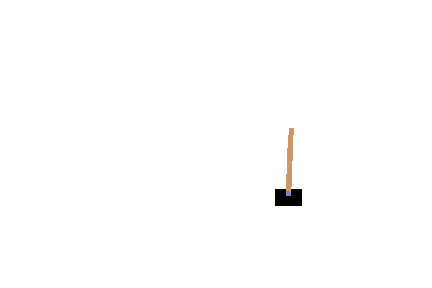
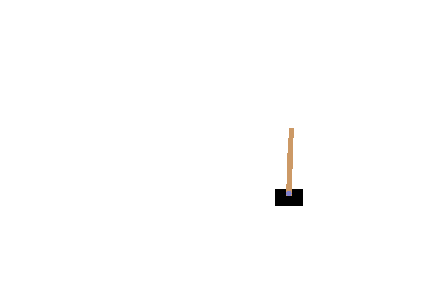
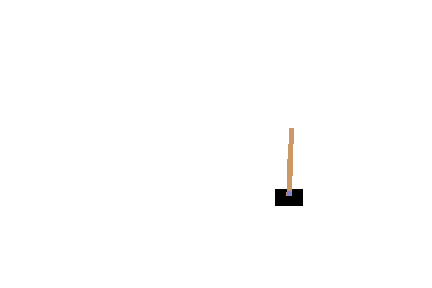
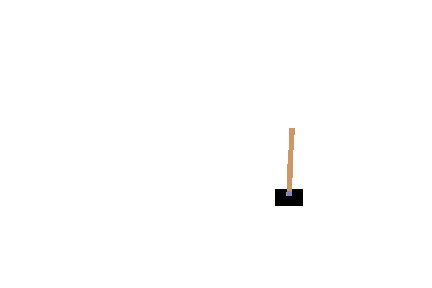
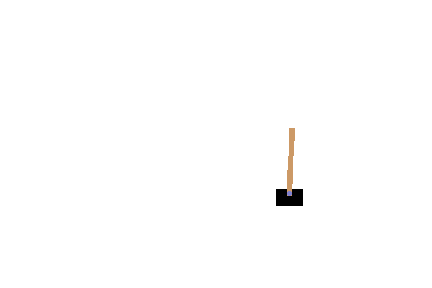
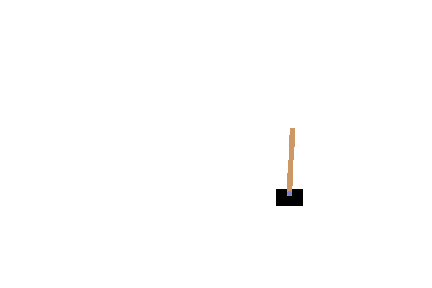
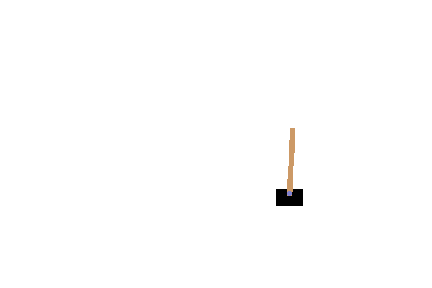
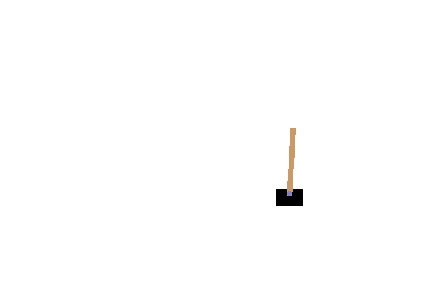
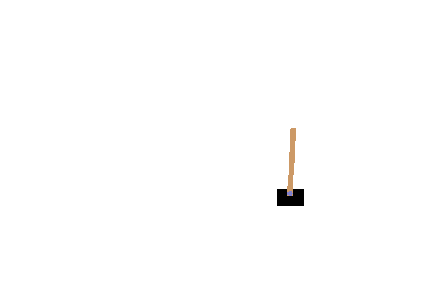
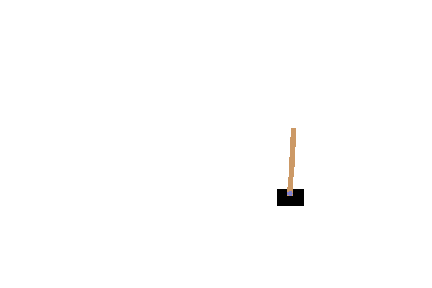
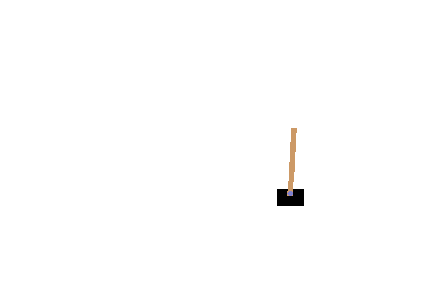
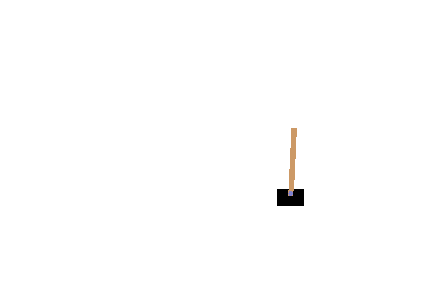
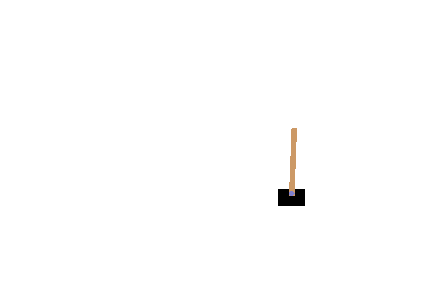
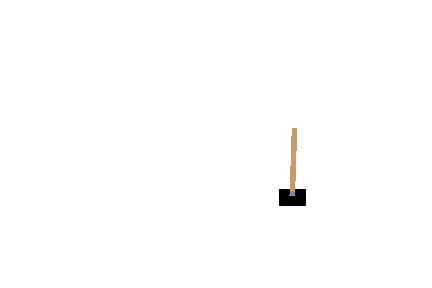
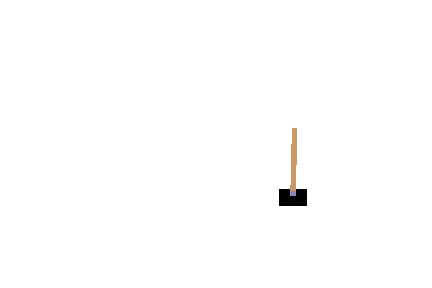
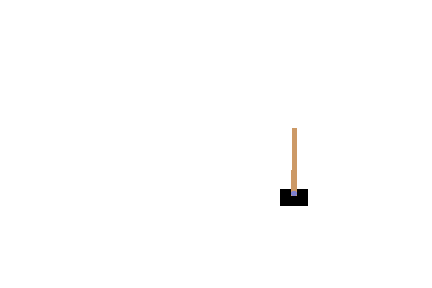
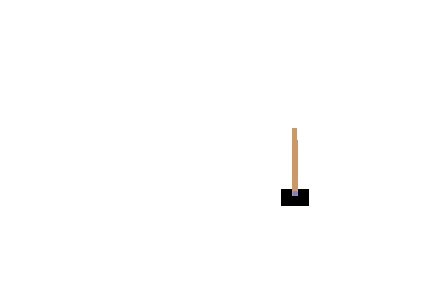
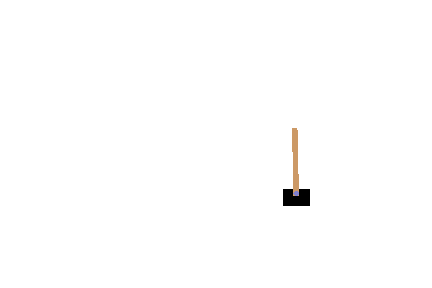
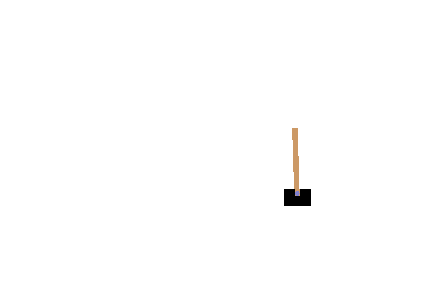
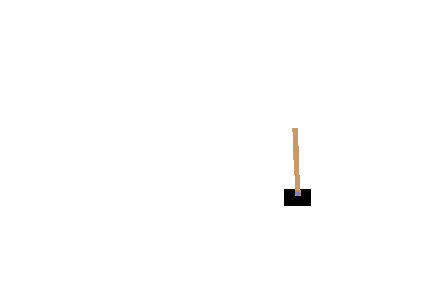
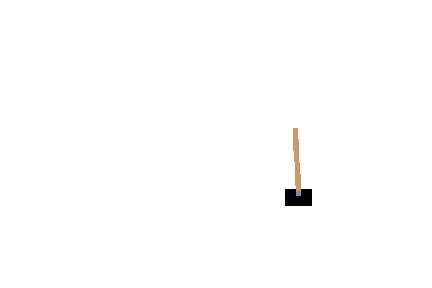
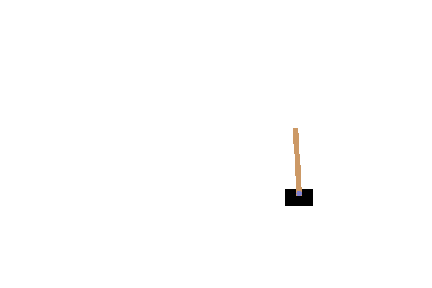
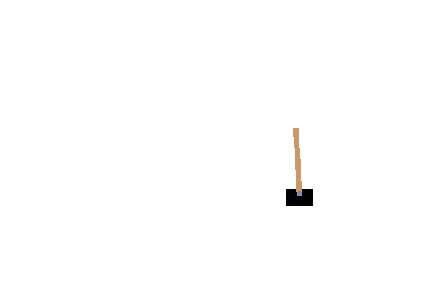
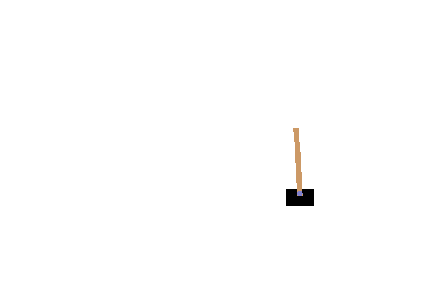
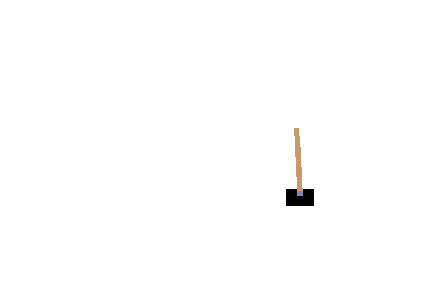
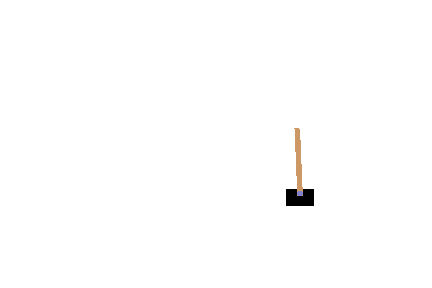
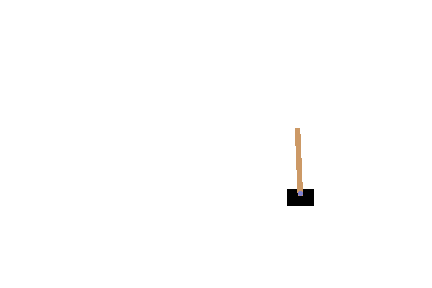
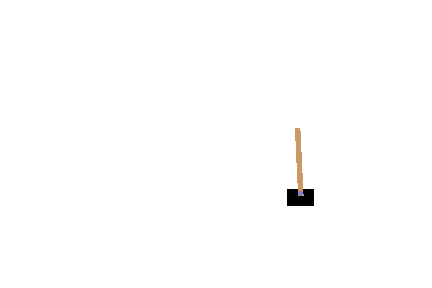
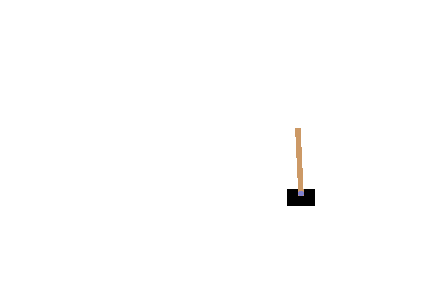
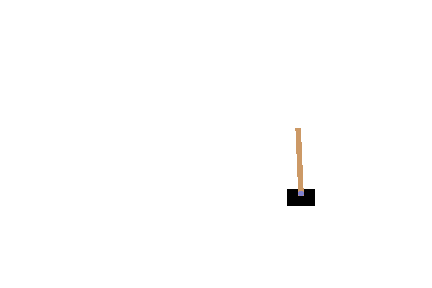
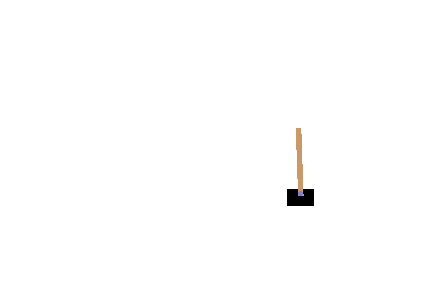
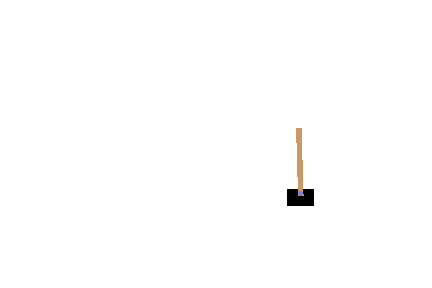
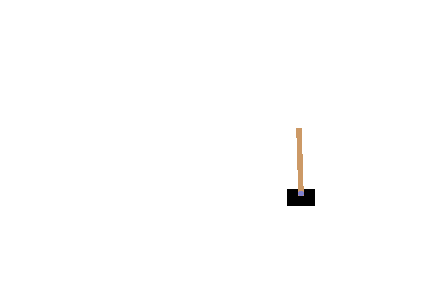
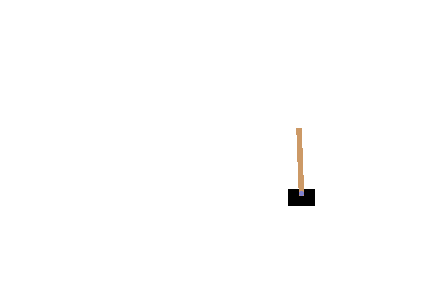
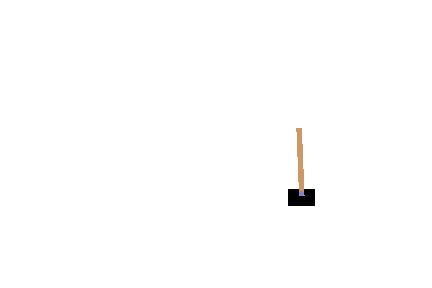
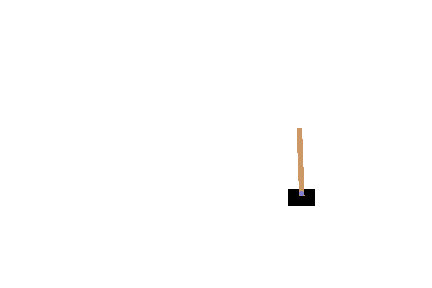
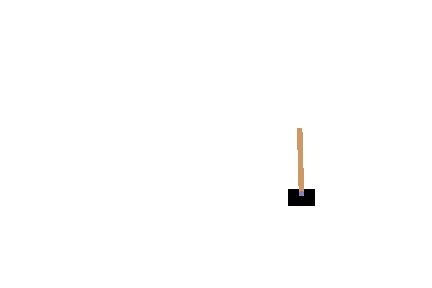
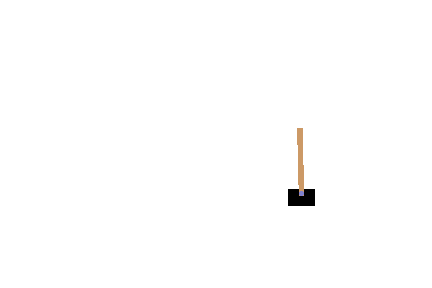
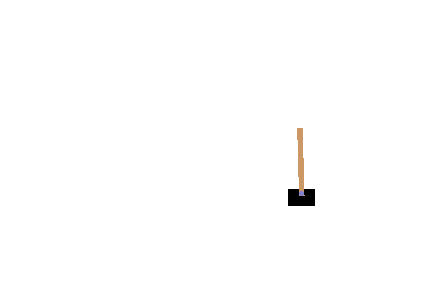
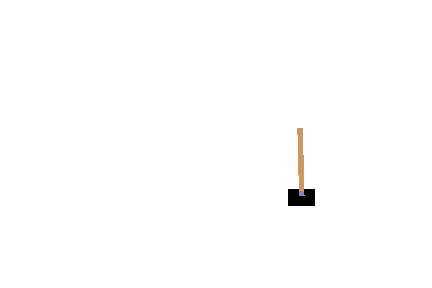
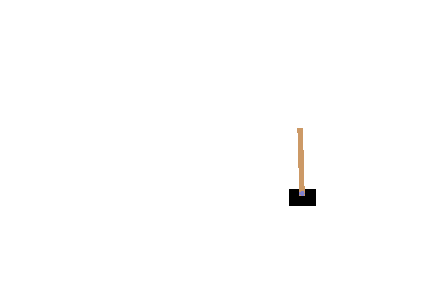
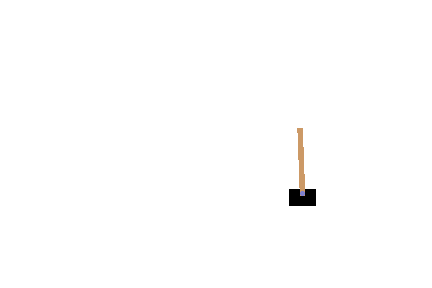
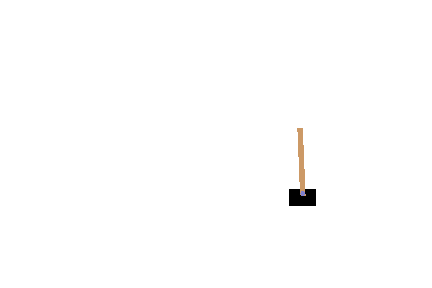
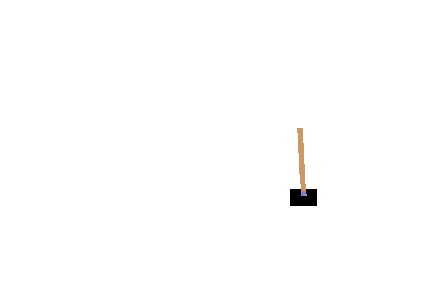
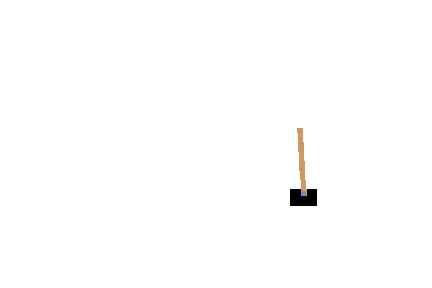
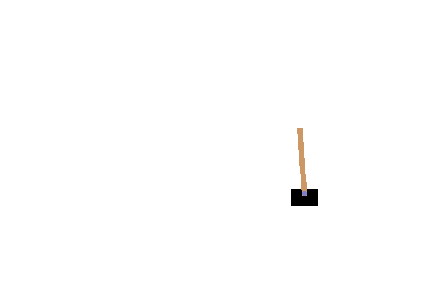
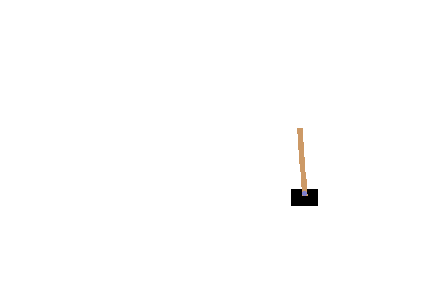
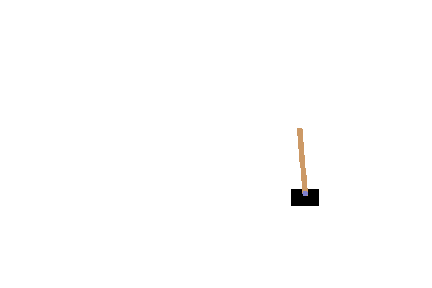
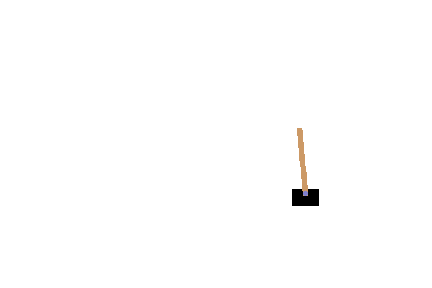
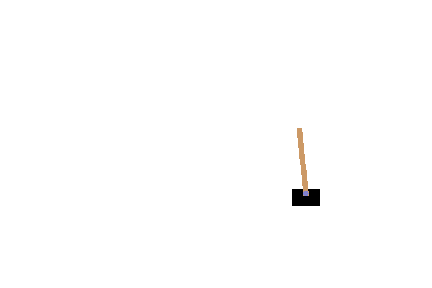
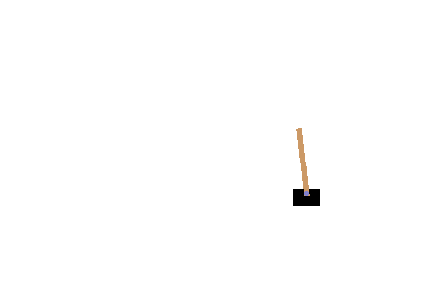
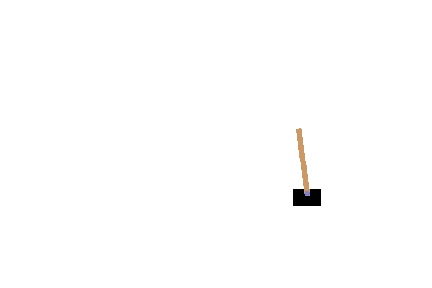
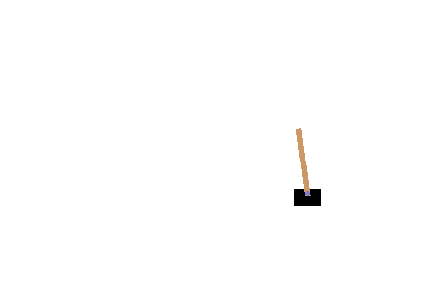
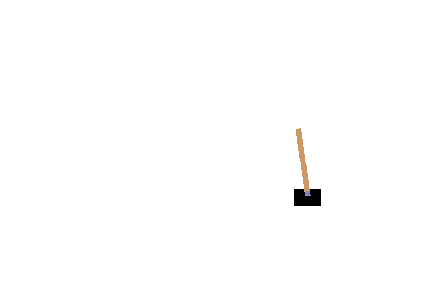
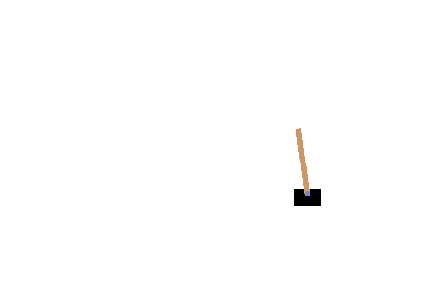
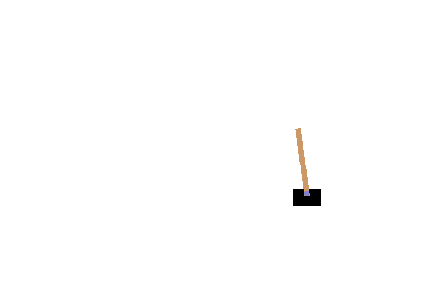
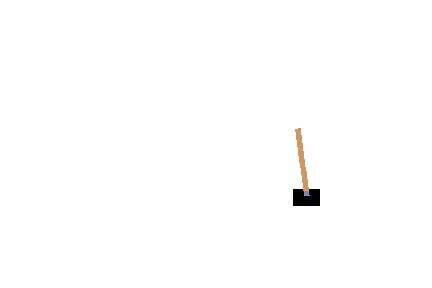
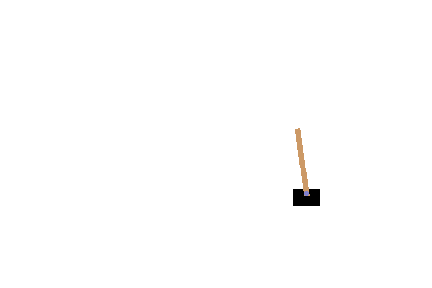
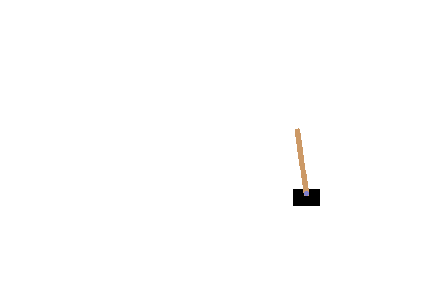
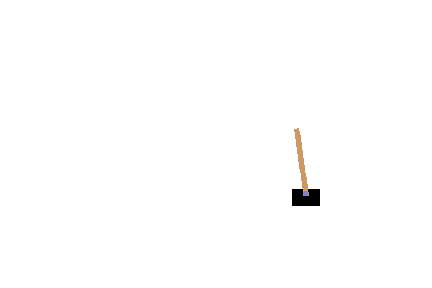
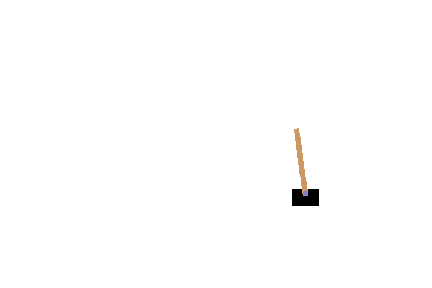
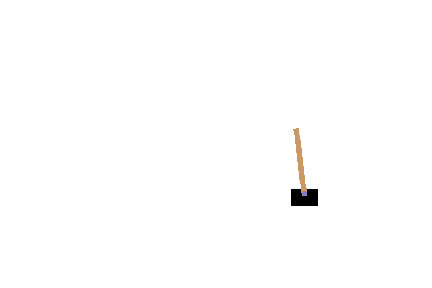
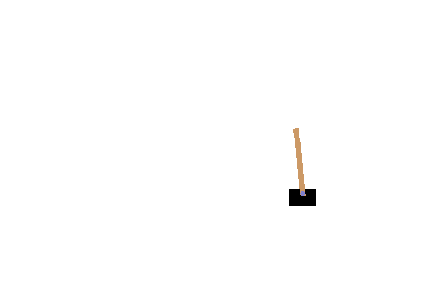
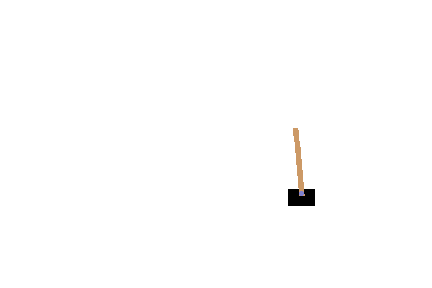
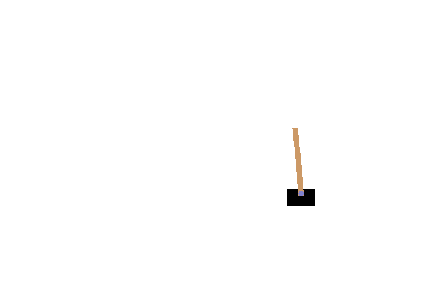
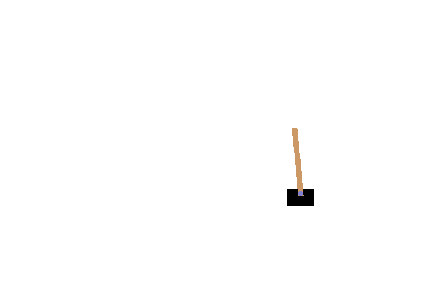
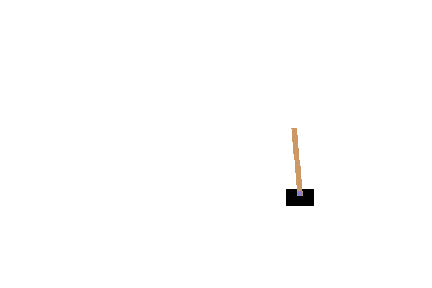
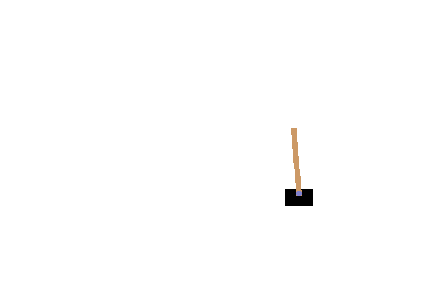
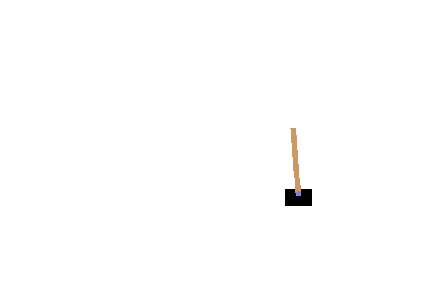
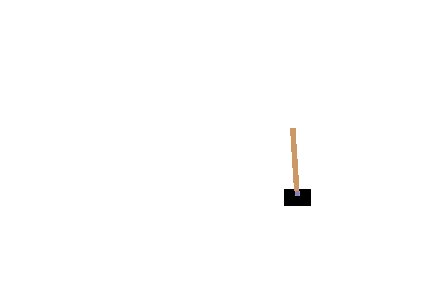
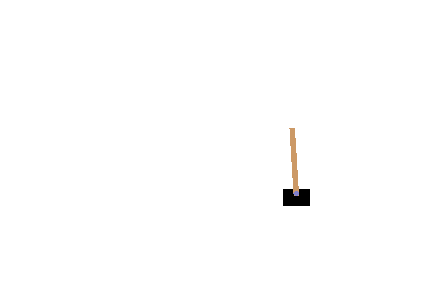
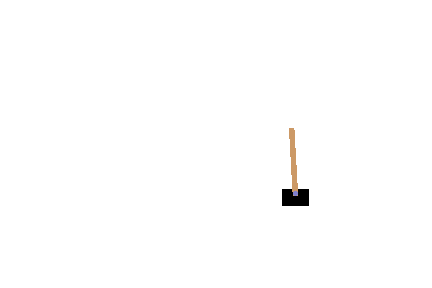
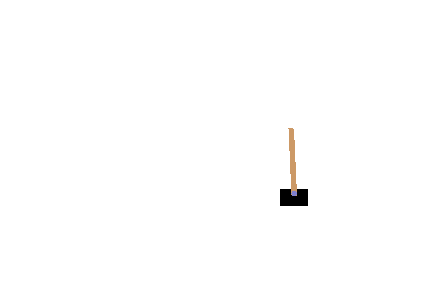
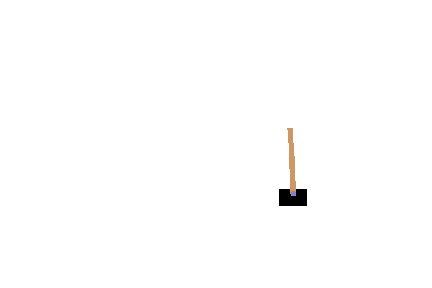
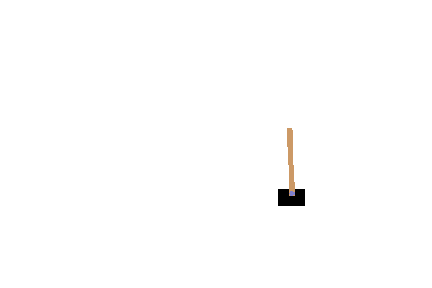
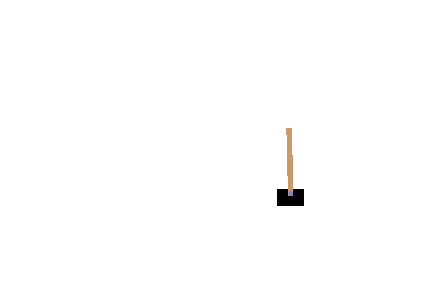
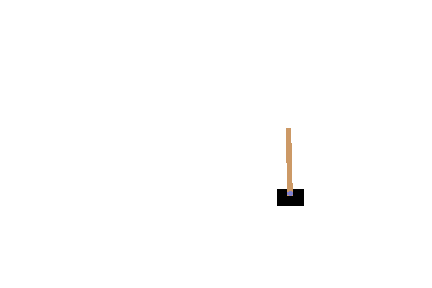
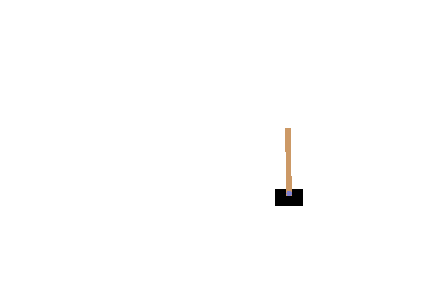
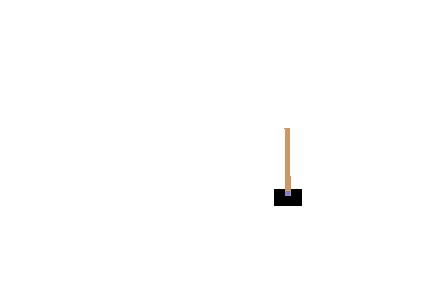
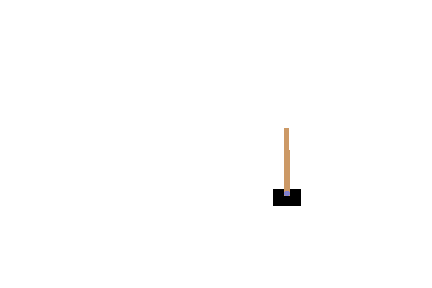
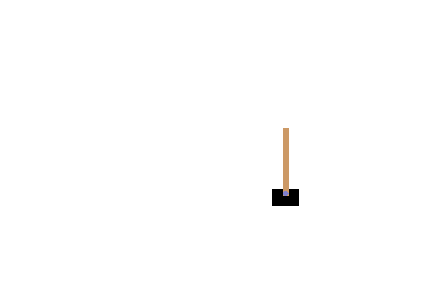
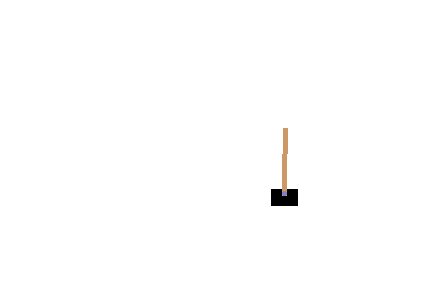
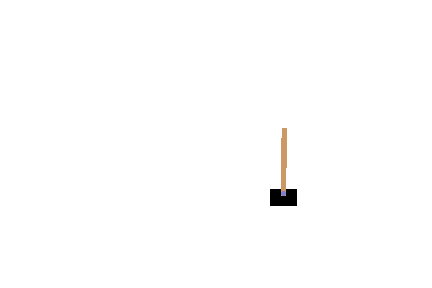
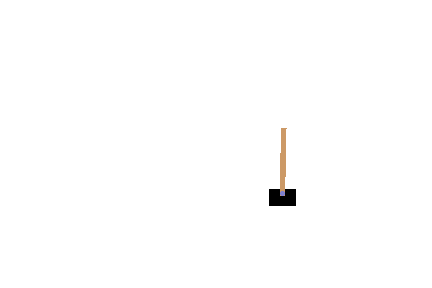
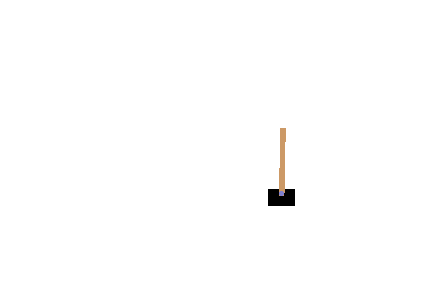
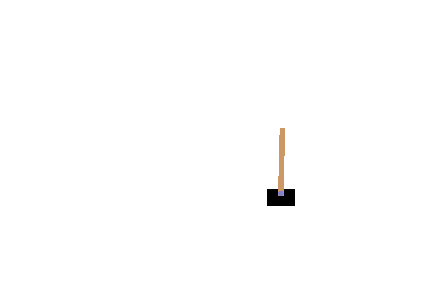
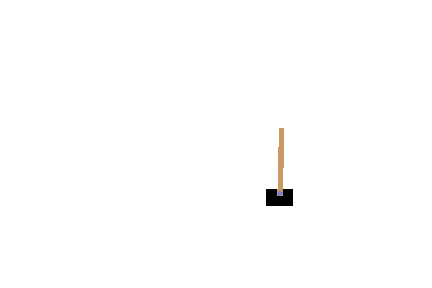
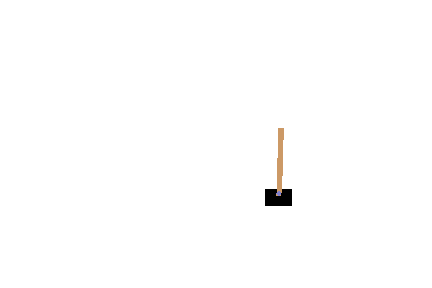
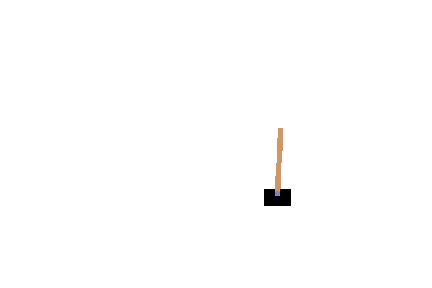
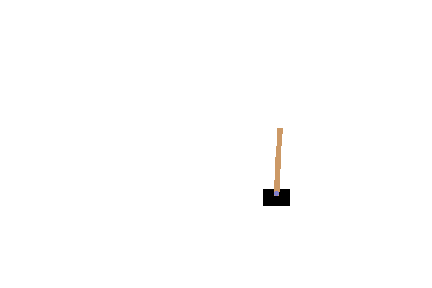
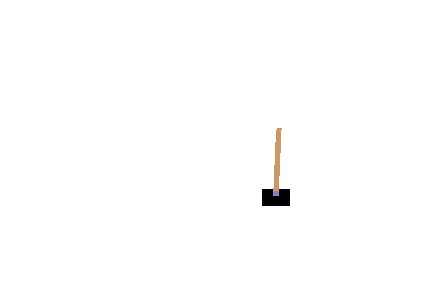
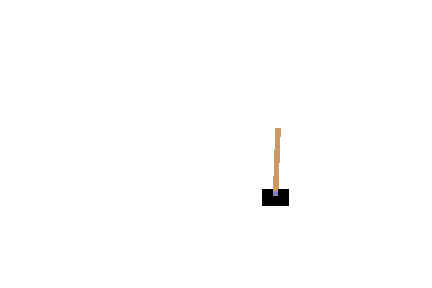
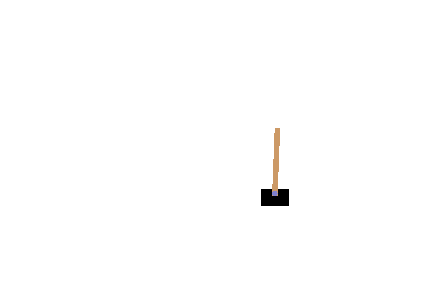
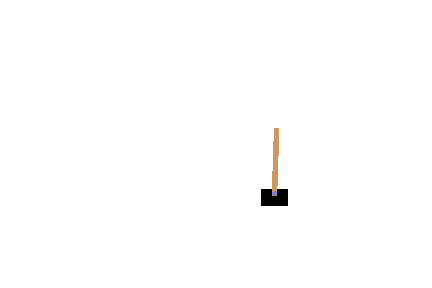
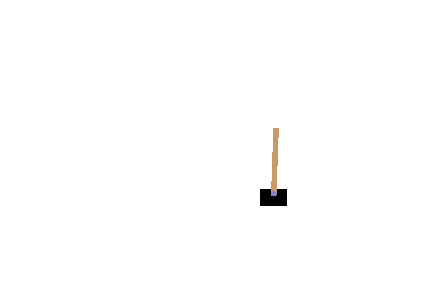
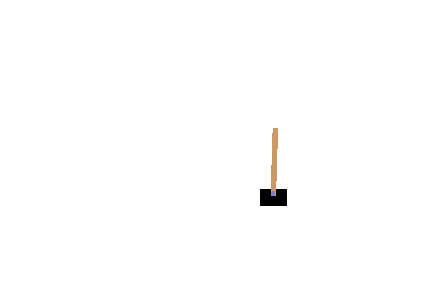
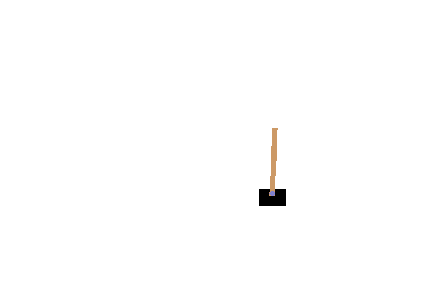
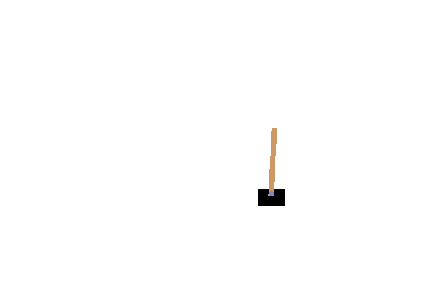
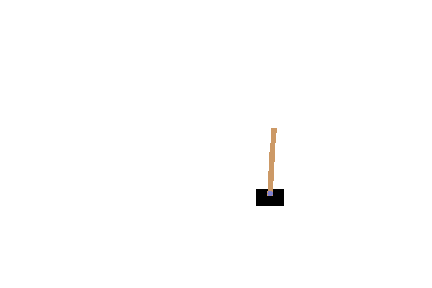
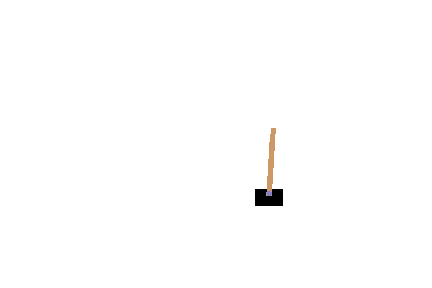
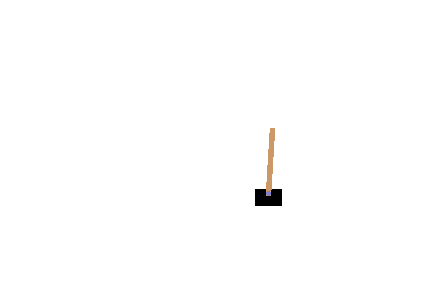
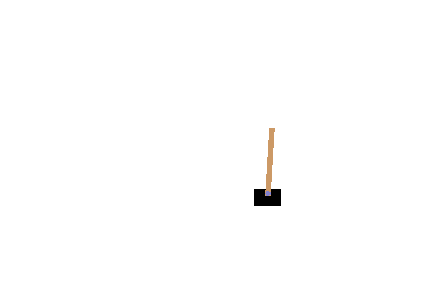
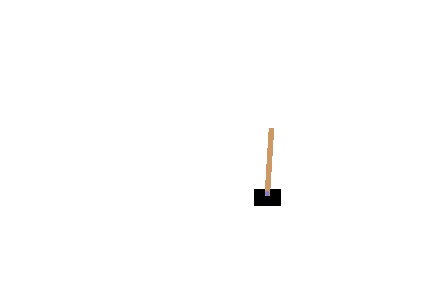
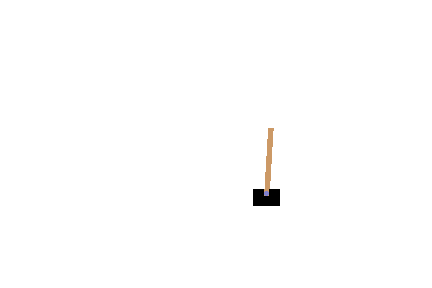
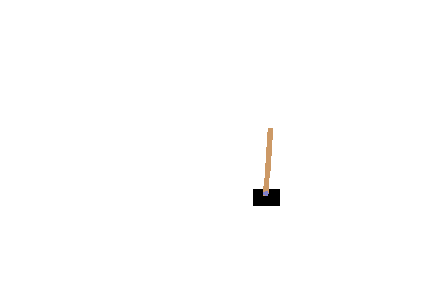
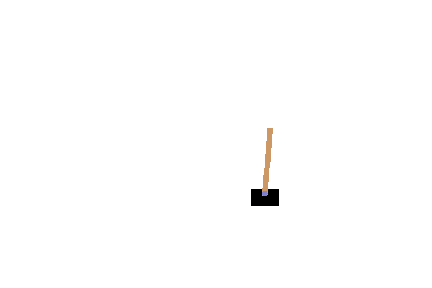
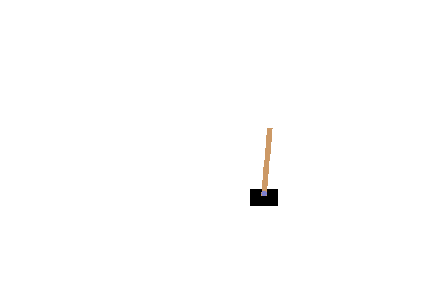
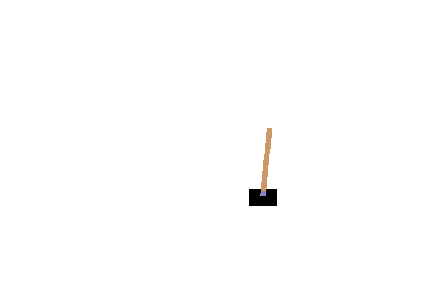
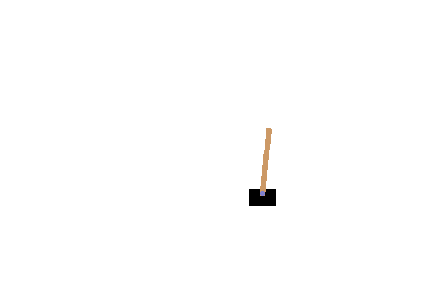
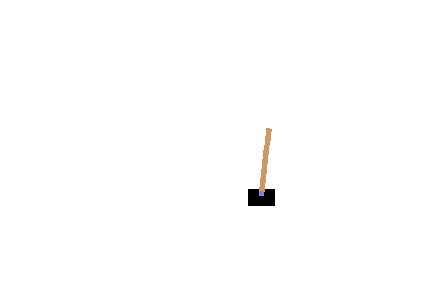
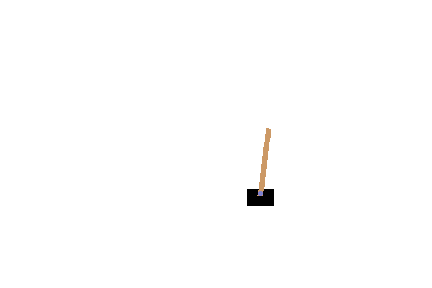
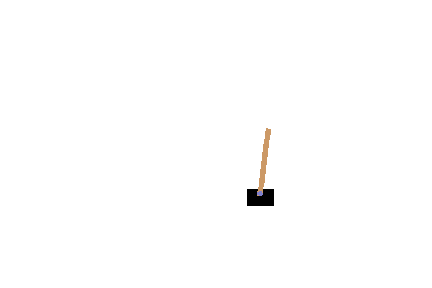
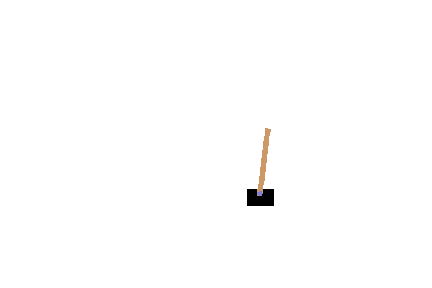
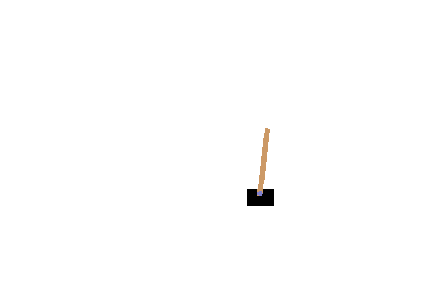
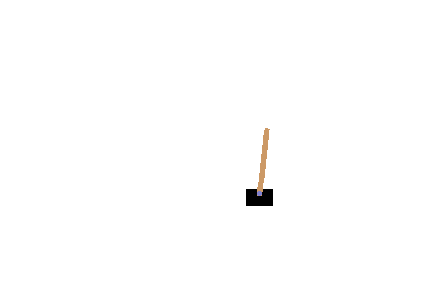
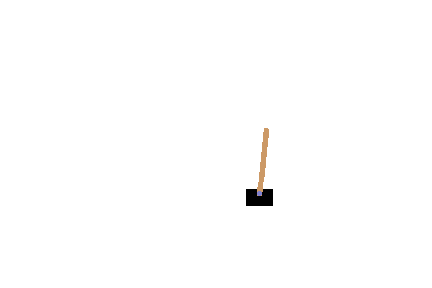
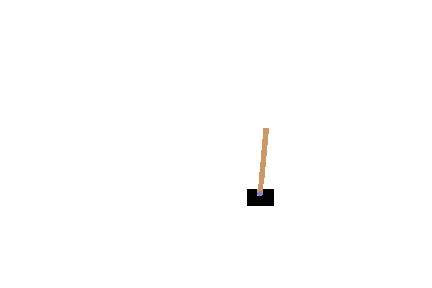
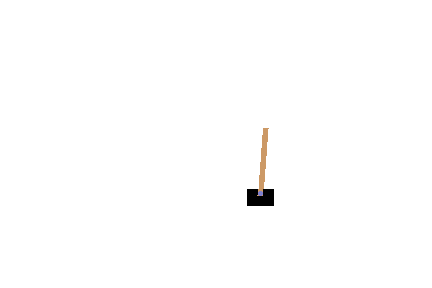
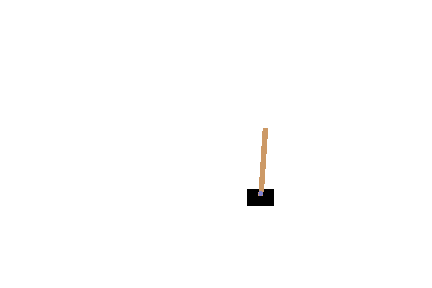
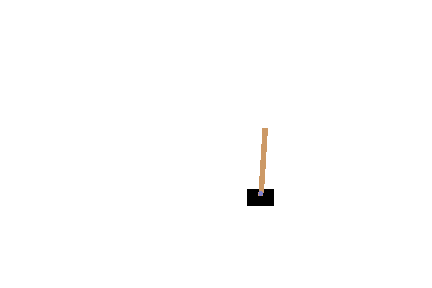
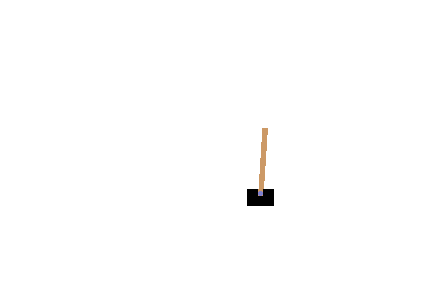
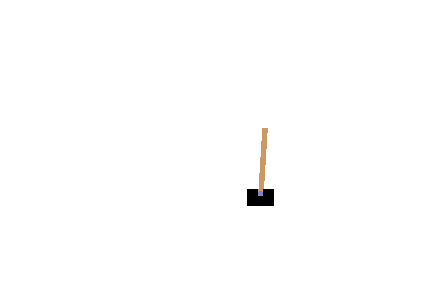
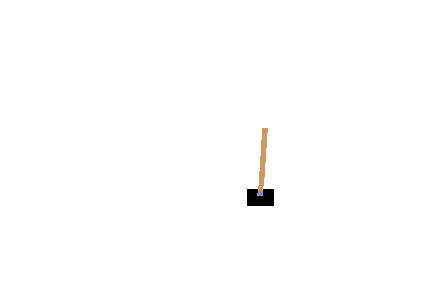
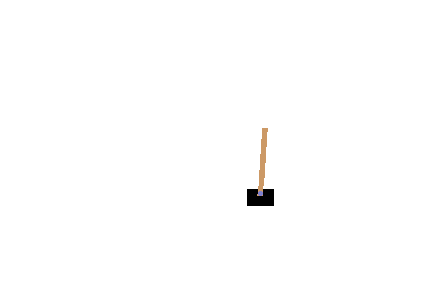
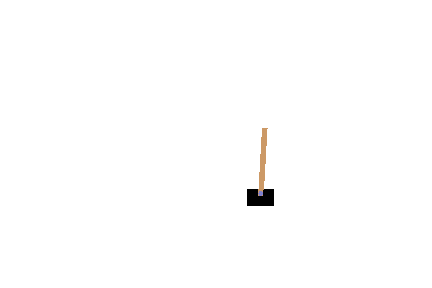
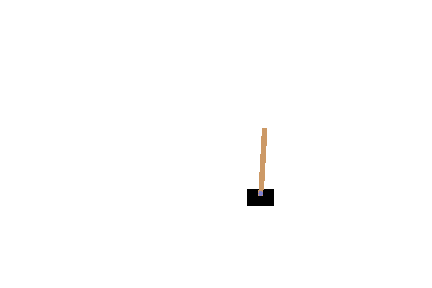
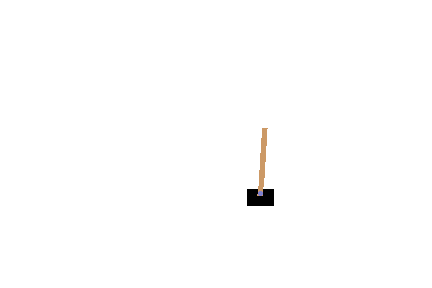
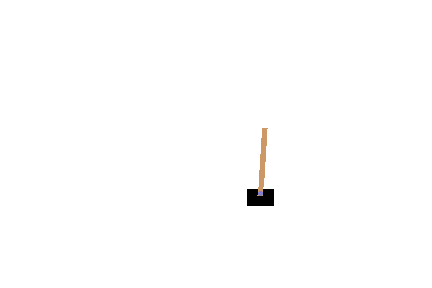
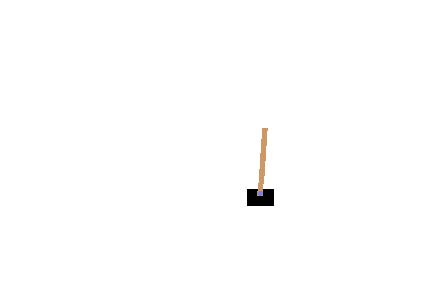
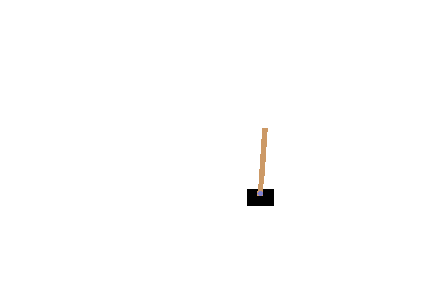
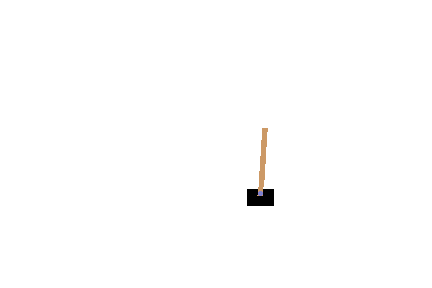
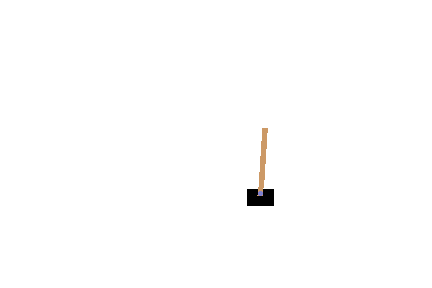
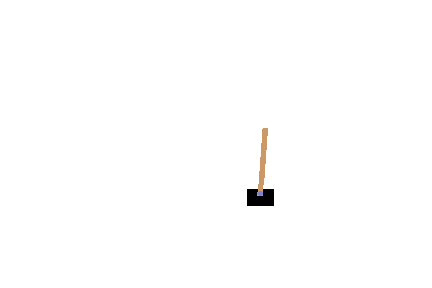
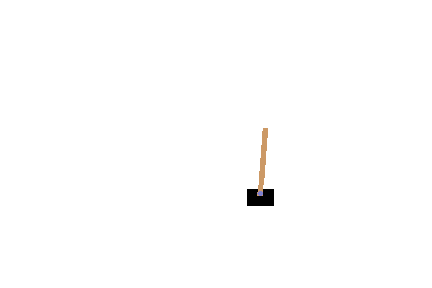
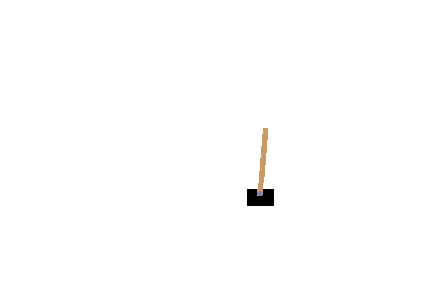
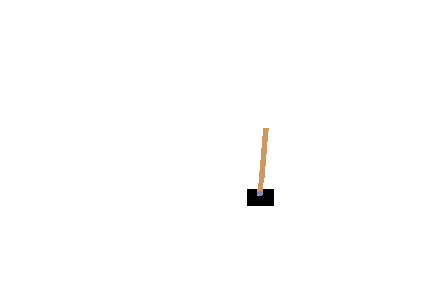
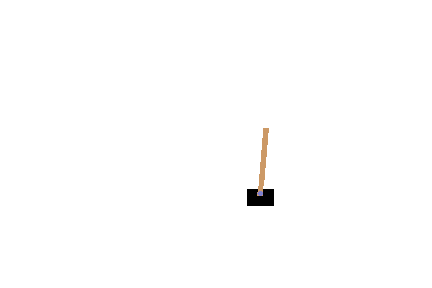
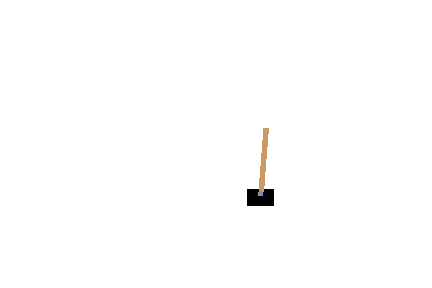
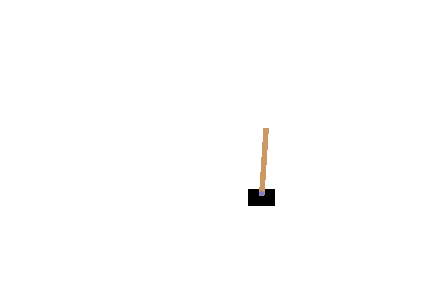
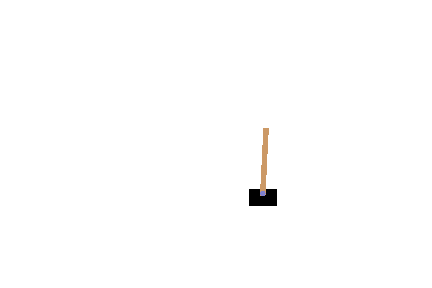
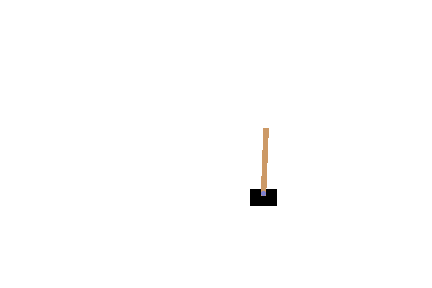
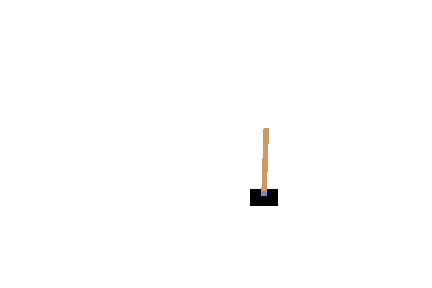
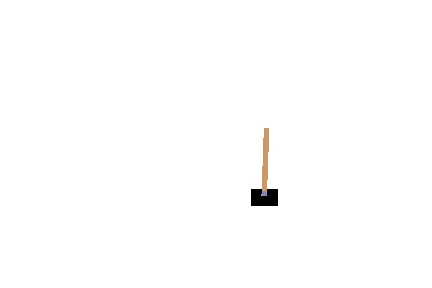
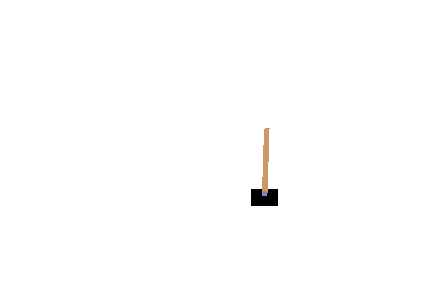
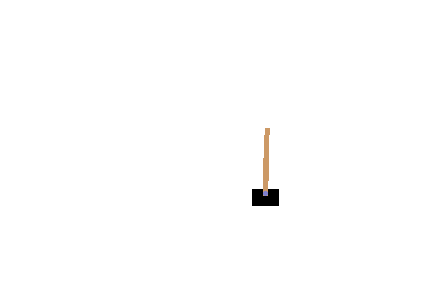
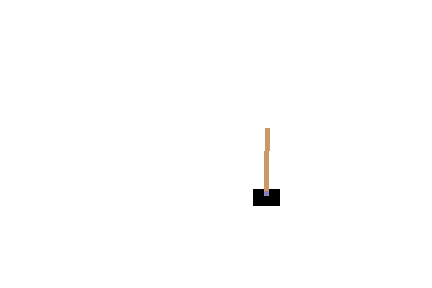
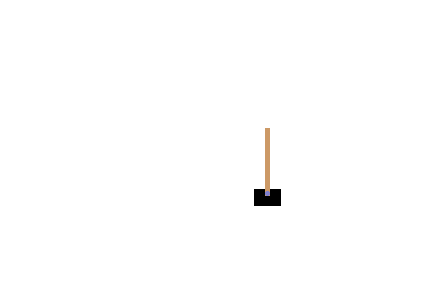
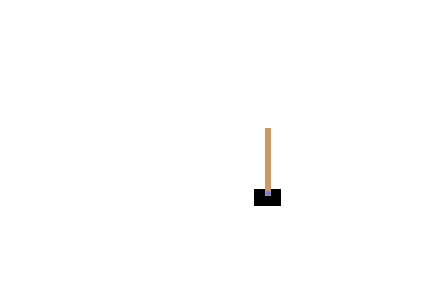
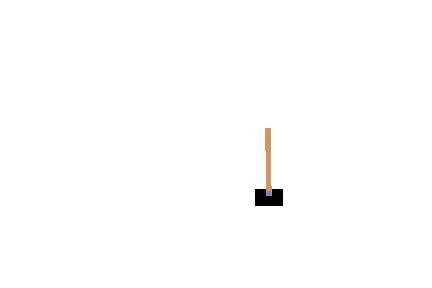
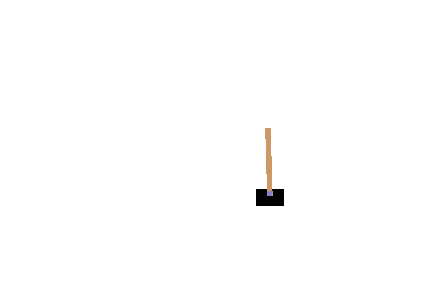
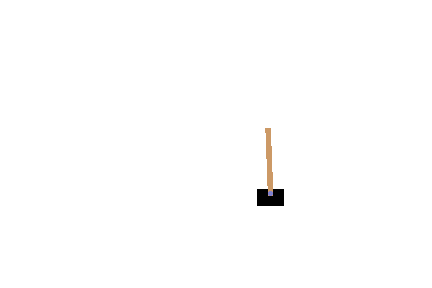
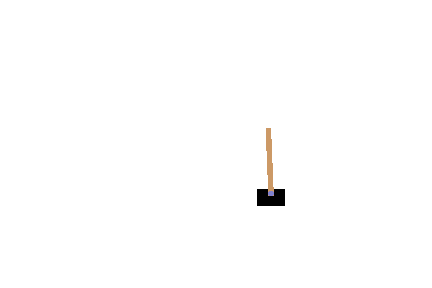
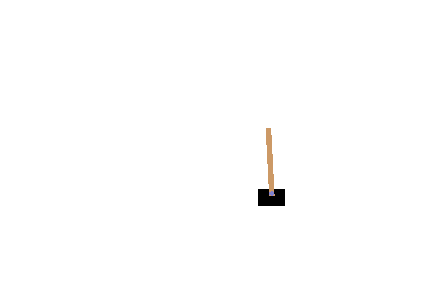
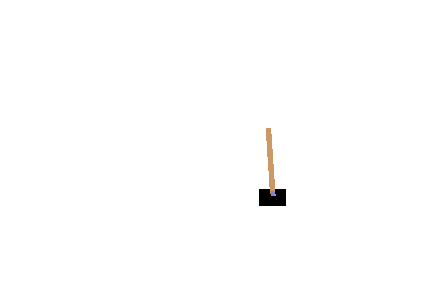
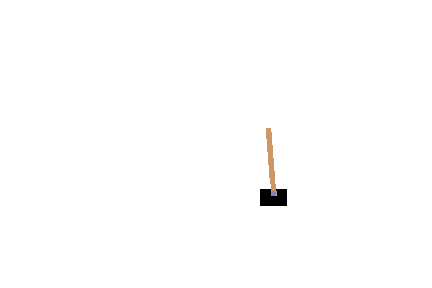
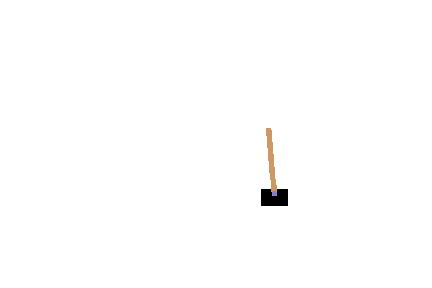
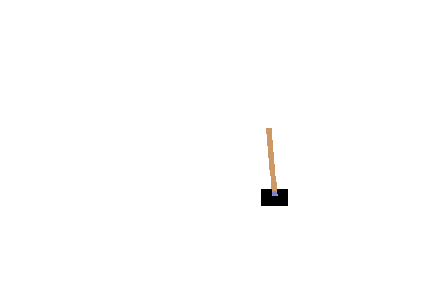
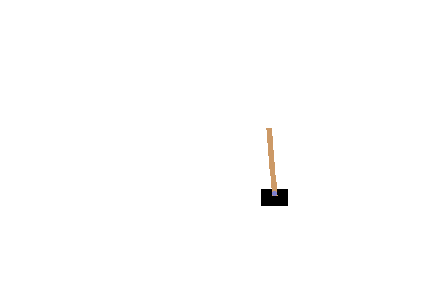
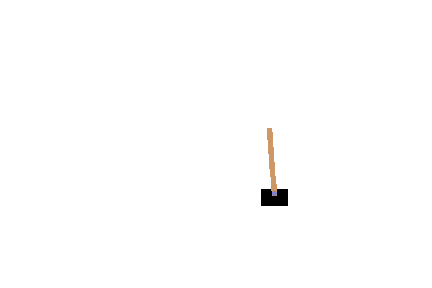
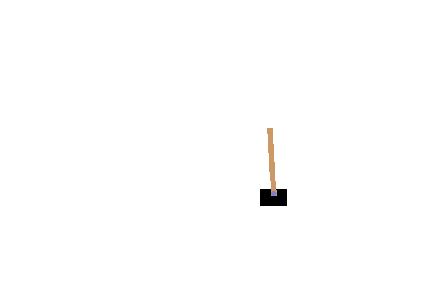
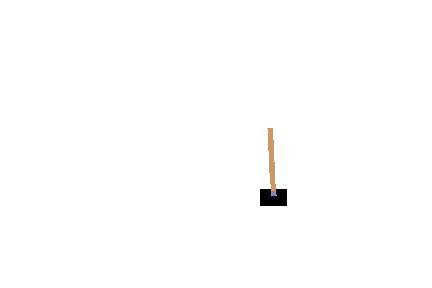
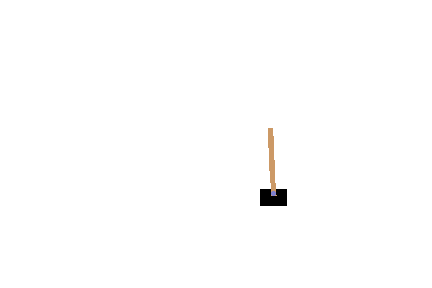
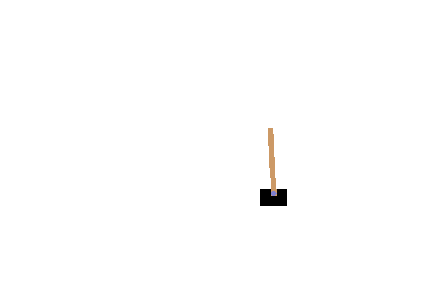
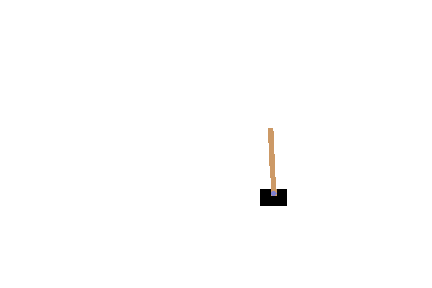
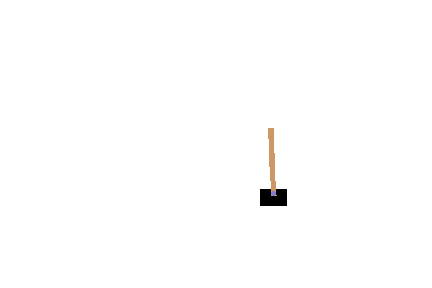
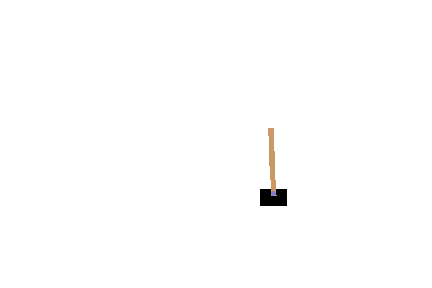
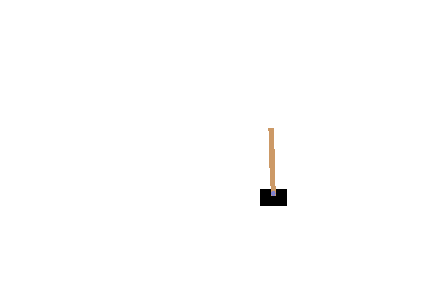
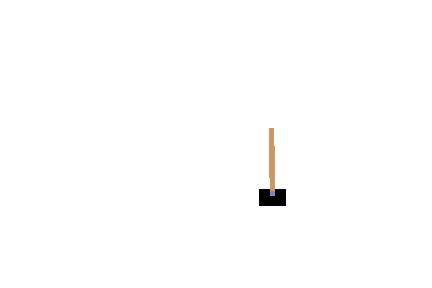
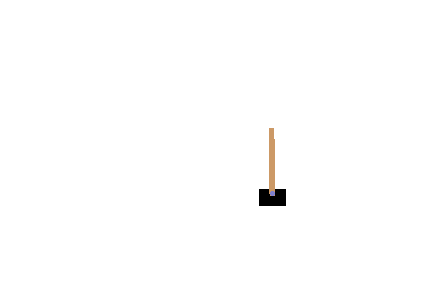
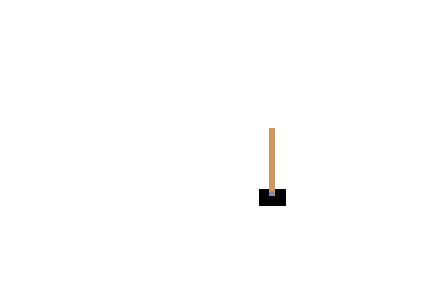
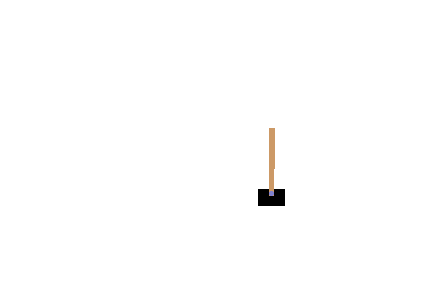
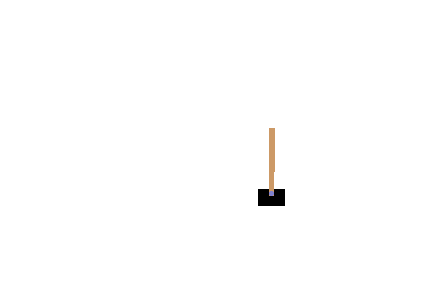
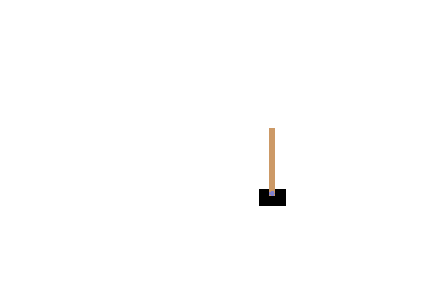
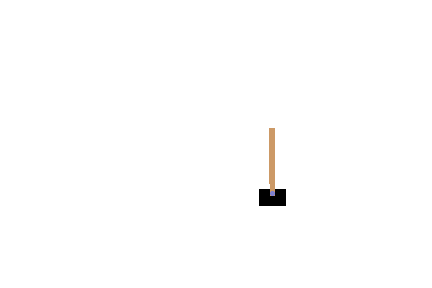
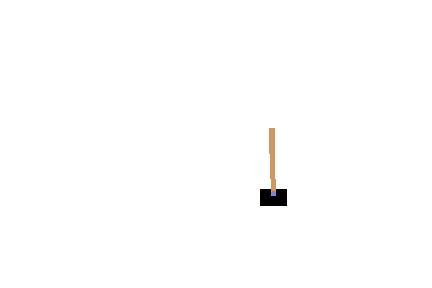
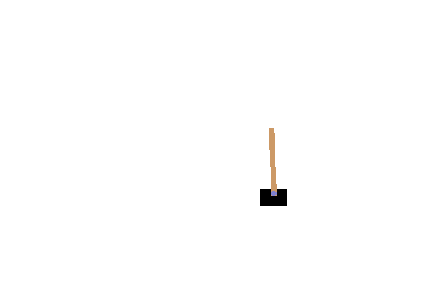
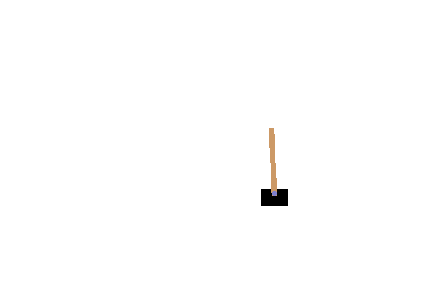
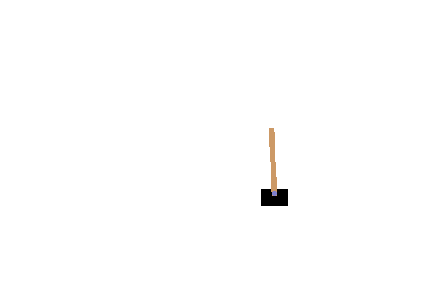
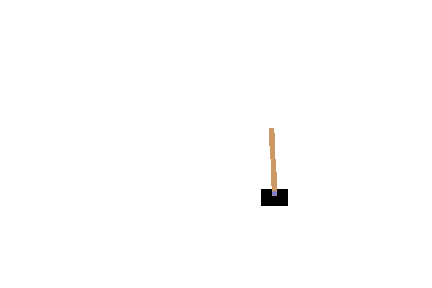
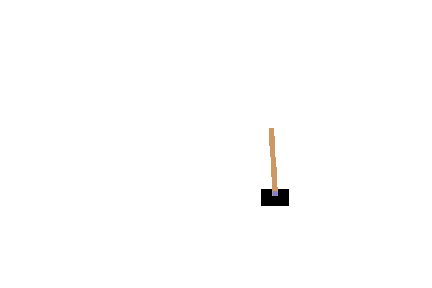
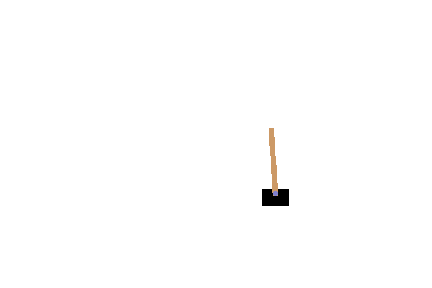
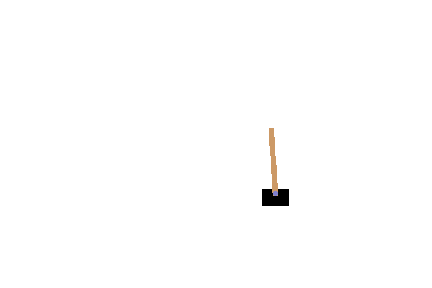
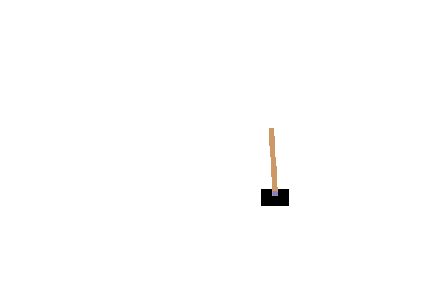
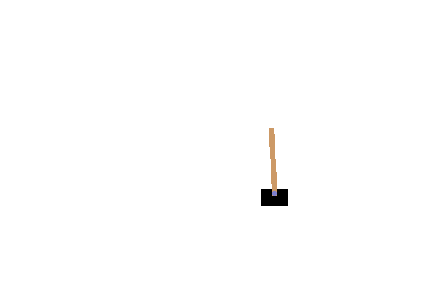
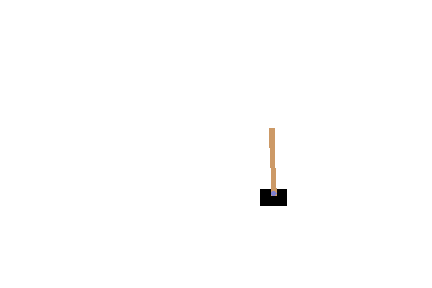
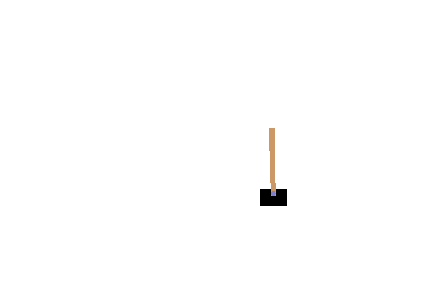
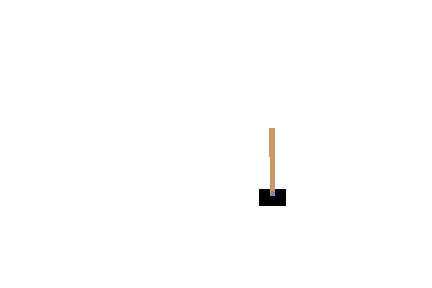
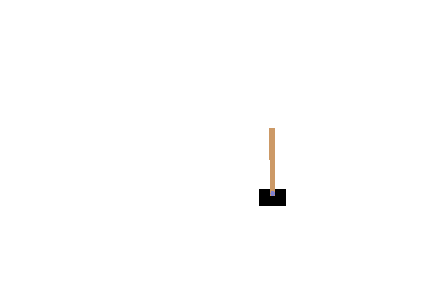
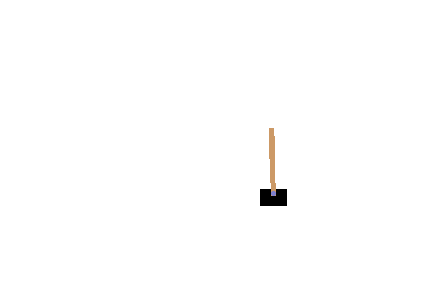
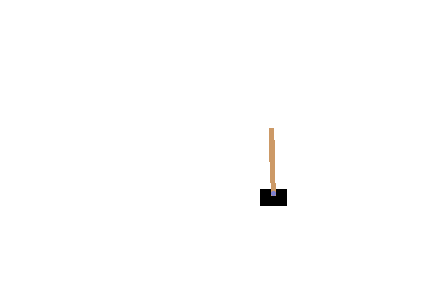
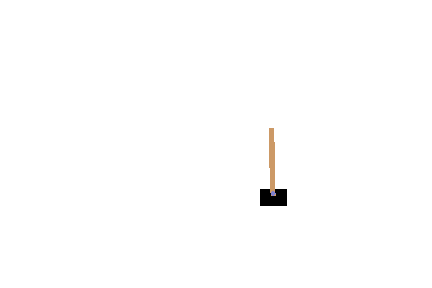
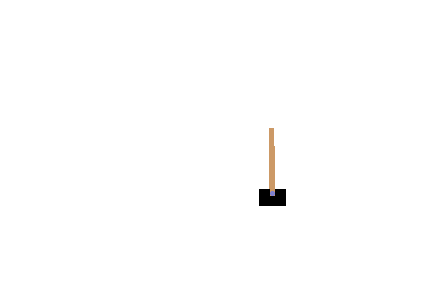
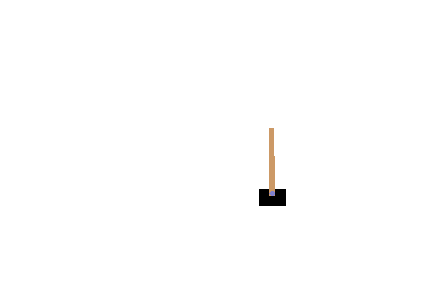
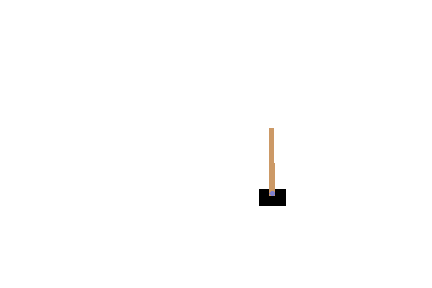
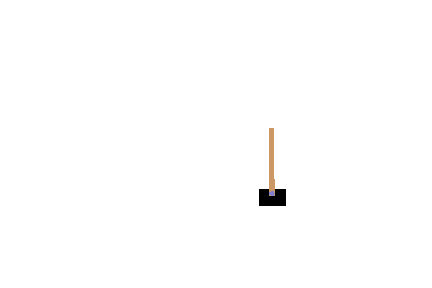
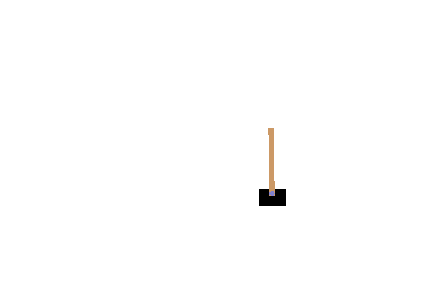
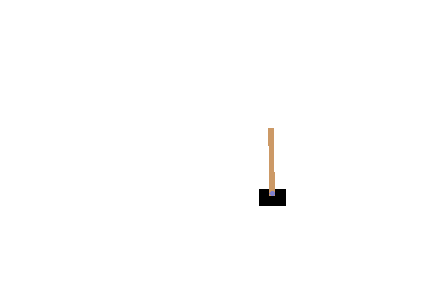
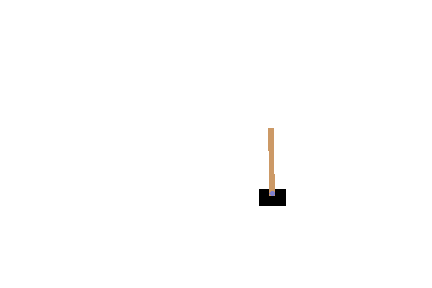
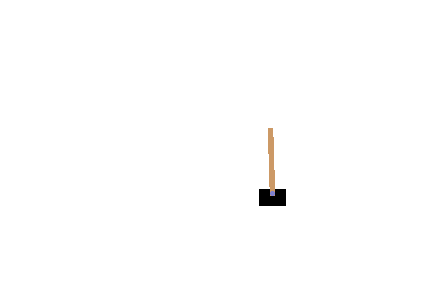
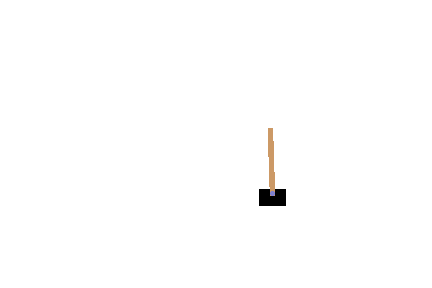
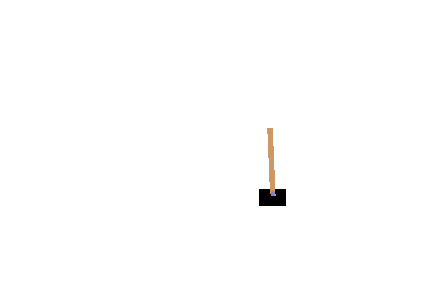
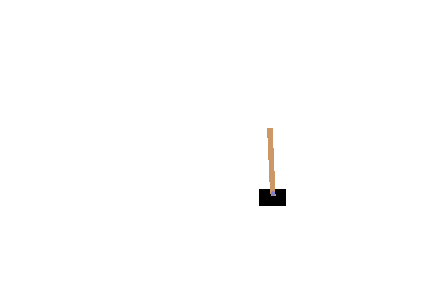

In [11]:
_, frames = play_one_mc(env, pmodel, vmodel, GAMMA, render=True)
env.render(close=True)
display_frames_as_gif(frames)